### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary


In [1]:
# to selectively re-import as needed
# import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']


In [2]:
from datetime import datetime, timedelta
import os
import yaml
import sqlite3
import json
from collections import Counter
import uuid
from typing import TypedDict, Annotated
import subprocess
import requests

import operator
import pickle

import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

from langchain_core.output_parsers import SimpleJsonOutputParser, JsonOutputParser, StrOutputParser

from langgraph.graph import StateGraph, START, END

import numpy as np
import pandas as pd
import umap

import sklearn
from sklearn.cluster import DBSCAN

import bs4
from urllib.parse import urljoin, urlparse

import multiprocessing
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import openai
from openai import OpenAI

import trafilatura

VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, PAGES_DIR,
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, TOP_CATEGORIES_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB,
                        HOSTNAME_SKIPLIST, SITE_NAME_SKIPLIST,
                       )
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, count_tokens, trunc_tokens, 
                      categorize_headline, categorize_df, clean_topics,
                      get_site_name, fetch_missing_site_names)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [3]:
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")


LangChain         0.3.0
OpenAI            1.47.0
trafilatura       1.12.2
numpy             1.26.4
pandas            2.2.3
sklearn           1.5.2
umap              0.5.6


In [ ]:
# a basic LLM call with langchain
model = ChatOpenAI(model=MODEL)

model.invoke([
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])


In [ ]:
# use template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | model | parser
chain.invoke({"language": "italian", "text": "hi"})


In [ ]:
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


In [ ]:
# same but send all at once using asyncio

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response


prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


In [4]:
# class to maintain state within graph

class AgentState(TypedDict):
    AIdf: dict                #  the current working set of headlines (pandas dataframe not supported)
    before_date: str          #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool         #  if False use existing files, else download from sources
    sources: dict             #  sources to scrap
    sources_reverse: dict     #  map file names to sources
    bullets: str              #  bullet point summary email
    summary: str              #  final summary
    n_edits: int              #  count edit iterations so we don't keep editing forever
    edit_complete: bool       #  edit will update if no more edits to make
    # message thread with OpenAI
    messages: Annotated[list[AnyMessage], operator.add]


In [9]:
DEBUG = True
N_BROWSERS = 4
MAX_EDITS = 3
before_date = None
do_download = True
# before_date="2024-10-09 08:30:00"
# 

In [10]:
test_state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'n_edits': 0,
    'edit_complete': False,
    'messages': None}
)


In [11]:
# Initialize reading configurations from YAML file

def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from SOURCECONFIG (sources.yaml) .

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Initialized {len(state['sources'])} items in sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Initialized {len(state['sources_reverse'])} items in sources_reverse")

    return state


if DEBUG:
    test_state = fn_initialize(test_state)


2024-10-10 07:56:12,520 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2024-10-10 07:56:12,521 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-10-10 07:56:12,521 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-10-10 07:56:12,521 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-10-10 07:56:12,522 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-10-10 07:56:12,522 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-10-10 07:56:12,522 - AInewsbot - INFO - 

In [12]:
# scrape sources with selenium and save local files in DOWNLOAD_DIR (htmldata)
def fn_download_sources(state: AgentState) -> AgentState:
    """
    Scrapes sources and saves HTML files.
    If state["do_download"] is True, deletes all files in DOWNLOAD_DIR (htmldata) and scrapes fresh copies.
    If state["do_download"] is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    if state["do_download"]:
        # empty download directory
        delete_files(DOWNLOAD_DIR)

        # save each file specified from sources
        log(f"Saving HTML files using {N_BROWSERS} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state["sources"].values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(N_BROWSERS, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
        log(f"Saved {len(saved_pages)} HTML files")

    else:   # use existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter files with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(f"Found {len(files)} previously downloaded files")
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state["sources_reverse"].get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

if DEBUG:
    test_state = fn_download_sources(test_state)


2024-10-10 07:56:13,716 - AInewsbot - INFO - Saving HTML files using 4 browsers
2024-10-10 07:56:13,733 - AInewsbot - INFO - get_driver - 36947 Initializing webdriver
2024-10-10 07:56:13,734 - AInewsbot - INFO - get_driver - 36947 Initializing webdriver
2024-10-10 07:56:13,735 - AInewsbot - INFO - get_driver - 36947 Initializing webdriver
2024-10-10 07:56:13,736 - AInewsbot - INFO - get_driver - 36947 Initializing webdriver
2024-10-10 07:56:29,574 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-10 07:56:29,574 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-10 07:56:29,574 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-10 07:56:29,574 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-10 07:56:29,575 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-10 07:56:29,575 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-10 07:56:29,575 - AInewsbot - INFO -

2024-10-10 07:57:46,583 - AInewsbot - INFO - get_files(New York Times Technology) - starting get_files https://www.nytimes.com/section/technology
2024-10-10 07:57:52,562 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-10-10 07:57:52,562 - AInewsbot - INFO - get_files(HackerNoon) - Saving HackerNoon (10_10_2024 07_57_52 AM).html as utf-8
2024-10-10 07:57:52,564 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: htt

2024-10-10 07:58:31,658 - AInewsbot - INFO - get_files(WSJ Technology) - Saving WSJ Technology (10_10_2024 07_58_31 AM).html as utf-8
2024-10-10 07:58:31,659 - AInewsbot - INFO - Quit webdriver
2024-10-10 07:58:40,949 - AInewsbot - INFO - get_files(Feedly AI) - Loading additional infinite scroll items
2024-10-10 07:58:50,980 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-10-10 07:58:50,980 - AInewsbot - INFO - get_files(Feedly AI) - Saving Feedly AI (10_10_2024 07_58_50 AM).html as utf-8
2024-10-10 

In [14]:
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename + ' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"Saved {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    AIdf = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    state['AIdf'] = AIdf.to_dict()

    return state


if DEBUG:
    test_state = fn_extract_urls(test_state)

    # s/b 17 but if some like bloomberg" or wsj are missing, maybe got a robot block
    # if so, download missing ones manually and then re-run fn_extract_urls
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])


2024-10-10 08:07:59,253 - AInewsbot - INFO - Parsing html files
2024-10-10 08:07:59,254 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (10_10_2024 07_57_36 AM).html
2024-10-10 08:07:59,313 - AInewsbot - INFO - parse_file - found 176 raw links
2024-10-10 08:07:59,316 - AInewsbot - INFO - parse_file - found 28 filtered links
2024-10-10 08:07:59,317 - AInewsbot - INFO - 28 links found
2024-10-10 08:07:59,317 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology (10_10_2024 07_57_30 AM).html
2024-10-10 08:07:59,332 - AInewsbot - INFO - parse_file - found 198 raw links
2024-10-10 08:07:59,335 - AInewsbot - INFO - parse_file - found 15 filtered links
2024-10-10 08:07:59,335 - AInewsbot - INFO - 15 links found
2024-10-10 08:07:59,335 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider Tech (10_10_2024 07_57_30 AM).html
2024-10-10 08:07:59,357 - AInewsbot - INFO - parse_file - found 309 raw links
2024-10-10 08:07:59,361 - AInewsbot - INFO - parse_file 

17


,id
src,
Ars Technica,28
Bloomberg Tech,12
Business Insider,51
FT Tech,63
Feedly AI,69
Google News,72
Hacker News,24
Hacker News 2,23
HackerNoon,95


In [15]:
# get AI news via newscatcher

newscatcher_sources = ['247wallst.com',
 '9to5mac.com',
 'androidauthority.com',
 'androidcentral.com',
 'androidheadlines.com',
 'appleinsider.com',
 'benzinga.com',
 'cnet.com',
 'cnn.com',
 'digitaltrends.com',
 'engadget.com',
 'fastcompany.com',
 'finextra.com',
 'fintechnews.sg',
 'fonearena.com',
 'ft.com',
 'gadgets360.com',
 'geekwire.com',
 'gizchina.com',
 'gizmochina.com',
 'gizmodo.com',
 'gsmarena.com',
 'hackernoon.com',
 'howtogeek.com',
 'ibtimes.co.uk',
 'itwire.com',
 'lifehacker.com',
 'macrumors.com',
 'mashable.com',
#  'medium.com',
 'mobileworldlive.com',
 'msn.com',
 'nypost.com',
 'phonearena.com',
 'phys.org',
 'popsci.com',
 'scmp.com',
 'sify.com',
 'siliconangle.com',
 'siliconera.com',
 'siliconrepublic.com',
 'slashdot.org',
 'slashgear.com',
 'statnews.com',
 'tech.co',
 'techcrunch.com',
 'techdirt.com',
 'technode.com',
 'technologyreview.com',
 'techopedia.com',
 'techradar.com',
 'techraptor.net',
 'techtimes.com',
 'techxplore.com',
 'telecomtalk.info',
 'thecut.com',
 'thedrum.com',
 'thehill.com',
 'theregister.com',
 'theverge.com',
 'thurrott.com',
 'tipranks.com',
 'tweaktown.com',
 'videocardz.com',
 'washingtonpost.com',
 'wccftech.com',
 'wired.com',
 'xda-developers.com',
 'yahoo.com',
 'zdnet.com']

def fn_extract_newscatcher(state: AgentState) -> AgentState:

    base_url = "https://api.newscatcherapi.com/v2/search"
    time_24h_ago = datetime.now() - timedelta(hours=24)

    # Put API key in headers 
    headers = {'x-api-key': os.getenv('NEWSCATCHER_API_KEY')}

    # Define search parameters
    params = {
        'q': 'Artificial Intelligence',
        'lang': 'en',
        'sources': ','.join(newscatcher_sources),
        'from': time_24h_ago.strftime('%Y-%m-%d %H:%M:%S'),
        'to': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'page_size': 300,
        'page': 1
        }

    # Make API call with headers and params
    response = requests.get(base_url, headers=headers, params=params)

    # Encode received results
    results = json.loads(response.text.encode())
    if response.status_code != 200:
        print('ERROR: API call failed.')
        print(results)
        
    # merge into existing df
    newscatcher_df = pd.DataFrame(results['articles'])[['title', 'link']]
    newscatcher_df['src']='Newscatcher'
    newscatcher_df = newscatcher_df.rename(columns={'link': 'url'})
    
    AIdf = pd.DataFrame(test_state['AIdf'])
    max_id = AIdf['id'].max()
    # add id column to newscatcher_df
    newscatcher_df['id'] = range(max_id + 1, max_id + 1 + len(newscatcher_df))
    AIdf = pd.concat([AIdf, newscatcher_df], ignore_index=True)
    state['AIdf'] = AIdf.to_dict()
    return state
    

if DEBUG:
    test_state = fn_extract_newscatcher(test_state)
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    

18


,id
src,
Ars Technica,28
Bloomberg Tech,12
Business Insider,51
FT Tech,63
Feedly AI,69
Google News,72
Hacker News,24
Hacker News 2,23
HackerNoon,95


In [16]:
# sqlite schema to store previously processed 
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [17]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState) -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:


        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """
    # filter to URL not previously seen
    AIdf = pd.DataFrame(state["AIdf"])

    AIdf = filter_unseen_urls_db(AIdf, before_date=state["before_date"])

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique new headlines")

    # structured response format
    json_schema = {
        "name": "json_schema",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "isai_array": {
                    "type": "array",
                    "items": {
                        "type": "object",
                                "properties": {
                                    "id": {
                                        "type": "number"
                                    },
                                    "isAI": {
                                        "type": "boolean"
                                    }
                                },
                        "required": ["id", "isAI"],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["isai_array"],
            "additionalProperties": False
        }
    }

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT, json_schema=json_schema))
    filter_df = pd.DataFrame(enriched_urls)
    
    try:  # for idempotency
        AIdf = AIdf.drop(columns=['isAI'])
    except:
        pass

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    log(AIdf.columns)
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']    # ideally resolve redirects but Google News blocks
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    log(f"Inserting {len(AIdf)} URLs into {SQLITE_DB}")
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, datetime.now().date())

    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    # I think Google changed something so this no longer works, instead of a 301 redirct
    # get a javascript page that redirects. Also tomorrow we might see different URLs for same stories
    # AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()

    # get clean site_name
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    # if any missing clean site names, populate them using OpenAI
    missing_site_names =  len(AIdf.loc[AIdf['site_name']==""])
    if missing_site_names:
        log(f"Asking OpenAI for {missing_site_names} missing site names")
        responses = asyncio.run(fetch_missing_site_names(AIdf))
        # update site_dict from responses
        new_urls = []
        for r in responses:
            if r['url'].startswith('https://'):
                r['url'] = r['url'][8:]
            new_urls.append(r['url'])
            sites_dict[r['url']] = r['site_name']
            log(f"Looked up {r['url']} -> {r['site_name']}")
        # update sites table with new names
        for url in new_urls:
            sqlstr = "INSERT OR IGNORE INTO sites (hostname, site_name) VALUES (?, ?);"
            log(f"Updated {url} -> {sites_dict[url]}")
            conn.execute(sqlstr, (url, sites_dict[url]))
            conn.commit()
        # reapply to AIdf with updated sites
        AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))
    else:
        log("No missing site names")
  
    # drop banned slop sites

    AIdf = AIdf.loc[~AIdf["hostname"].str.lower().isin(HOSTNAME_SKIPLIST)]
    AIdf = AIdf.loc[~AIdf["site_name"].str.lower().isin(SITE_NAME_SKIPLIST)]
    
    state["AIdf"] = AIdf.to_dict()
    return state


if DEBUG:
    test_state = fn_filter_urls(test_state)
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    display(list(pd.DataFrame(test_state["AIdf"]).columns))



2024-10-10 08:08:10,454 - AInewsbot - INFO - Querying SQLite with where_clause: 
2024-10-10 08:08:11,098 - AInewsbot - INFO - URLs in orig_df: 1327
2024-10-10 08:08:11,100 - AInewsbot - INFO - Existing URLs in DB: 159471
2024-10-10 08:08:11,136 - AInewsbot - INFO - New URLs in df filtered by URL: 488
2024-10-10 08:08:11,222 - AInewsbot - INFO - Existing src+title: 44
2024-10-10 08:08:11,223 - AInewsbot - INFO - New URLs in df filtered by src+title: 444
2024-10-10 08:08:11,234 - AInewsbot - INFO - Found 437 unique new headlines
2024-10-10 08:08:11,513 - AInewsbot - INFO - Applying prompt to 9 pages using gpt-4o-mini
2024-10-10 08:08:11,514 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:08:11,515 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:08:11,515 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:08:11,516 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:08:11,516 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:08:11,516 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:08:

,id
src,
Ars Technica,1
Bloomberg Tech,1
Business Insider,3
Feedly AI,52
Google News,29
HackerNoon,1
Newscatcher,48
Reddit,19
Techmeme,3


['id', 'src', 'title', 'url', 'isAI', 'actual_url', 'hostname', 'site_name']

In [18]:
# Function for topic extraction

def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]

    return combined


async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """

    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))

    return catdict


def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = pd.DataFrame(state["AIdf"])
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start free-form topic extraction")
    json_schema = {
        "name": "extracted_topics",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "extracted_topics": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "id": {
                                "type": "number",
                            },
                            "topics": {
                                "type": "array",
                                "items": {
                                    "type": "string",
                                },
                            },
                        },
                        "required": ["id", "topics"],
                        "additionalProperties": False,
                    }
                }
            },
            "required": ["extracted_topics"],
            "additionalProperties": False,
        }
    }
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT, json_schema=json_schema))
    topic_df = pd.DataFrame(response)
    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})
    log(f"{len(topic_df)} free-form topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]

    categories = sorted(CANONICAL_TOPICS)
    # use categories that are canonical or show up twice in freeform
    lcategories = set([c.lower() for c in categories] + [c.lower() for c in filtered_topics])
    # new topics
    log([c for c in filtered_topics if c not in categories])

    catdict = asyncio.run(categorize_headline(AIdf, categories=categories))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    try: # for idempotency
        AIdf = AIdf.drop(columns=['topic_str', 'title_topic_str'])
    except:
        pass

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf.to_dict()
    return state

if DEBUG:
    test_state = fn_topic_analysis(test_state)


2024-10-10 08:08:20,102 - AInewsbot - INFO - start free-form topic extraction
2024-10-10 08:08:20,102 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-10 08:08:20,103 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:08:20,103 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:08:20,104 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:08:20,104 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:08:25,429 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:08:35,097 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:08:37,244 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:08:43,850 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:08:43,852 - AInewsbot - INFO - Processed 160 responses.
2024-10-10 08:08:43,854 - AInewsbot - INFO - 160 free-form topics extracted
2024-10-10 08:08:43,855 - AInewsbot - INFO - ['geoffrey hinton', 'openai', 'sam altman', 'safety', 'nobel prize', 'finance', 'elections', 'amd', 'stock', 'advertising', '

2024-10-10 08:09:49,720 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:09:55,761 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:09:56,479 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:09:56,505 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:09:56,507 - AInewsbot - INFO - Processed 160 responses.
2024-10-10 08:09:56,508 - AInewsbot - INFO - Bubble, topic 10 of 100
2024-10-10 08:09:56,508 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-10 08:09:56,509 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:09:56,510 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:09:56,512 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:09:56,513 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:09:58,492 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:10:03,048 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:10:04,167 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:10:04,249 - AInewsbot - INFO - got

2024-10-10 08:11:17,231 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:11:18,709 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:11:23,726 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:11:23,729 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:11:23,805 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:11:23,806 - AInewsbot - INFO - Processed 160 responses.
2024-10-10 08:11:23,807 - AInewsbot - INFO - Deals, topic 21 of 100
2024-10-10 08:11:23,807 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-10 08:11:23,809 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:11:23,810 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:11:23,812 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:11:23,814 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:11:25,365 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:11:29,256 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:11:29,867 - AInewsbot - INFO - got dict with

2024-10-10 08:13:04,003 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:13:05,971 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:13:10,919 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:13:10,933 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:13:12,581 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:13:12,584 - AInewsbot - INFO - Processed 160 responses.
2024-10-10 08:13:12,585 - AInewsbot - INFO - Fashion, topic 32 of 100
2024-10-10 08:13:12,586 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-10 08:13:12,588 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:13:12,589 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:13:12,590 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:13:12,591 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:13:13,913 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:13:17,375 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:13:19,648 - AInewsbot - INFO - got dict wi

2024-10-10 08:14:26,334 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:14:28,462 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:14:32,353 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:14:32,355 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:14:32,904 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:14:32,907 - AInewsbot - INFO - Processed 160 responses.
2024-10-10 08:14:32,908 - AInewsbot - INFO - History, topic 43 of 100
2024-10-10 08:14:32,910 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-10 08:14:32,911 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:14:32,913 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:14:32,914 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:14:32,914 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:14:35,101 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:14:39,829 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:14:40,137 - AInewsbot - INFO - got dict wi

2024-10-10 08:16:00,131 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:16:00,132 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:16:01,963 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:16:05,541 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:16:05,808 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:16:05,853 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:16:05,855 - AInewsbot - INFO - Processed 160 responses.
2024-10-10 08:16:05,855 - AInewsbot - INFO - Korea, topic 54 of 100
2024-10-10 08:16:05,856 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-10 08:16:05,856 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:16:05,857 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:16:05,858 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:16:05,859 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:16:06,996 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:16:09,536 - AInewsbot - INFO - got dict with 50 items

2024-10-10 08:17:19,944 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:17:19,945 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:17:19,948 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:17:21,903 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:17:31,560 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:17:31,595 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:17:33,199 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:17:33,201 - AInewsbot - INFO - Processed 160 responses.
2024-10-10 08:17:33,202 - AInewsbot - INFO - Opinion, topic 65 of 100
2024-10-10 08:17:33,203 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-10 08:17:33,204 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:17:33,206 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:17:33,208 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:17:33,209 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:17:34,837 - AInewsbot - INFO - got dict with 10 items 
2024-

2024-10-10 08:18:50,574 - AInewsbot - INFO - Processed 160 responses.
2024-10-10 08:18:50,575 - AInewsbot - INFO - Review, topic 75 of 100
2024-10-10 08:18:50,575 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-10 08:18:50,576 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:18:50,577 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:18:50,578 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:18:50,578 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:18:53,586 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:18:57,193 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:18:58,270 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:19:00,653 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:19:00,655 - AInewsbot - INFO - Processed 160 responses.
2024-10-10 08:19:00,656 - AInewsbot - INFO - Robots, topic 76 of 100
2024-10-10 08:19:00,656 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-10 08:19:00,657 - 

2024-10-10 08:20:26,771 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:20:26,774 - AInewsbot - INFO - Processed 160 responses.
2024-10-10 08:20:26,775 - AInewsbot - INFO - Sports, topic 86 of 100
2024-10-10 08:20:26,776 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-10 08:20:26,777 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:20:26,779 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:20:26,781 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:20:26,782 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:20:28,799 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:20:33,736 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:20:34,000 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:20:35,055 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:20:35,058 - AInewsbot - INFO - Processed 160 responses.
2024-10-10 08:20:35,058 - AInewsbot - INFO - Stocks, topic 87 of 100
2024-10-10 08:20:35,060 - AInewsbot - INFO - Ap

2024-10-10 08:22:05,182 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:22:05,185 - AInewsbot - INFO - Processed 160 responses.
2024-10-10 08:22:05,186 - AInewsbot - INFO - UK, topic 97 of 100
2024-10-10 08:22:05,187 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-10 08:22:05,189 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:22:05,190 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:22:05,191 - AInewsbot - INFO - sent 50 items 
2024-10-10 08:22:05,192 - AInewsbot - INFO - sent 10 items 
2024-10-10 08:22:06,896 - AInewsbot - INFO - got dict with 10 items 
2024-10-10 08:22:11,626 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:22:12,246 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:22:12,254 - AInewsbot - INFO - got dict with 50 items 
2024-10-10 08:22:12,255 - AInewsbot - INFO - Processed 160 responses.
2024-10-10 08:22:12,256 - AInewsbot - INFO - Venture Capital, topic 98 of 100
2024-10-10 08:22:12,257 - AInewsbot - INFO

In [19]:
async def write_topic_name(session, topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)

    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses.
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
#             print(topic_list_str)
            response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            return response_dict

            break
        except Exception as exc:
            log(f"Error: {exc}")

    return {}


async def afn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """
    AIdf = pd.DataFrame(state["AIdf"])

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # greedy traveling salesman sort
    log(f"Sort with nearest_neighbor_sort sort")
    sorted_indices = nearest_neighbor_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Perform dimensionality reduction")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    cluster_topics = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        async with aiohttp.ClientSession() as session:
            for i in range(30):
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = await write_topic_name(session, title_topic_str_list)
                cluster_topic = cluster_topic['topic_title']
                cluster_topics.append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
    state["cluster_topics"] = cluster_topics
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: cluster_topics[i] if i < len(cluster_topics) else "")
    state["AIdf"] = AIdf.to_dict()
    return state

# TODO: could add a quality rating for stories based on site reputation, length, complexity of story
# could then add the quality rating to the summaries and tell the prompt to favor high-quality stories
# could put summaries into vector store and retrieve stories by topic. but then you will have to deal
# with duplicates across categories, ask the prompt to dedupe

def fn_topic_clusters(state: AgentState) -> AgentState:
    "call async afn_topic_clusters on state"
    asyncio.run(afn_topic_clusters(state))
    return state


if DEBUG:
    test_state = fn_topic_clusters(test_state)


2024-10-10 08:22:30,122 - AInewsbot - INFO - Fetching embeddings for 160 headlines
2024-10-10 08:22:30,596 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-10-10 08:22:30,818 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2024-10-10 08:22:30,856 - AInewsbot - INFO - Perform dimensionality reduction
2024-10-10 08:22:33,690 - AInewsbot - INFO - Cluster with DBSCAN


,id,title_topic_str
0,0,"Chinese AI tool uncovers new viruses at the speed of a species per second: paper (Topics: China, Chinese AI, Gen AI, Healthcare, Research, Science, Testing, Viruses)"
1,1,"BenevolentAI to Present on Explainable AI for Drug Discovery at BioTechX Europe 2024 (Topics: Benevolentai, Bias And Fairness, Biotechx Europe 2024, Cognitive Science, Consciousness, Drug Discovery, Ethics, European Union, Explainable AI, Gen AI, Health & Fitness, Healthcare, Safety And Alignment, Science, Testing)"
2,2,"AI Simulations Help Drug Trials (Topics: Drug Trials, Gen AI, Health & Fitness, Healthcare, Products, Science, Simulations, Testing)"


2024-10-10 08:22:34,466 - AInewsbot - INFO - I dub this cluster: AI in Healthcare and Drug Discovery


,id,title_topic_str
3,3,"How AI is Shaping the Future of Accounting (Topics: Accounting, Business, Economics, Finance, Future, Gen AI, Job Automation, Jobs & Careerslabor Market)"
4,4,"Sage Intacct review: Streamlined accounting with AI (Topics: Accounting, Economics, Finance, Fintech, Gen AI, Products, Review, Sage Intacct)"
5,5,"NextGen: AI: AI adoption is thriving in the financial sector (Topics: Adoption, Economics, Finance, Financial Sector, Fintech, Gen AI, Job Automation, Stocks)"
6,6,"HSBC exec says there's a lot of AI 'success theater' happening in finance (Topics: Business, Economics, Finance, Fintech, Gen AI, Hsbc, Opinion, Stocks, Success Theater)"
7,7,"AI Surge Transforms Finance as Banks, Governance and Trading Evolve (Topics: Banks, Economics, Finance, Fintech, Gen AI, Governance, Politics, Stocks, Trading)"


2024-10-10 08:22:35,182 - AInewsbot - INFO - I dub this cluster: AI in Finance and Accounting


,id,title_topic_str
8,8,"Harnessing the Power of AI in a Secure Way for Emerging Threats (Topics: Cybersecurity, Emerging Threats, Ethics, Gen AI, Military, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Security)"
9,9,"Cyber A.I. Group and A1 Advisory Announce Strategic Partnership (Topics: A1 Advisory, Cyber A.I. Group, Cybersecurity, Deals, Gen AI, Mergers And Acquisitions, Partnership)"
10,10,"AI firm touts fix for AI-data privacy issue: small-scale LLMs (Topics: Bias And Fairness, Cybersecurity, Data Privacy, Ethics, Gen AI, Intellectual Property, Language Models, Legal Issues, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Small-Scale Llms)"
11,11,"iTWire - Harnessing the Power of AI in a Secure Way for Emerging Threats (Topics: AI Doom, Cybersecurity, Disinformation, Emerging Threats, Ethics, Gen AI, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Security)"
12,12,"Navigating AI And Exit Valuation: How To Protect Your IP (Topics: Business, Cybersecurity, Economics, Exit Valuation, Finance, Gen AI, Intellectual Property, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment)"
13,13,"As attackers embrace artificial intelligence, every organisation should do these five things (Topics: AI Doom, Attackers, Cybersecurity, Gen AI, Organizations, Privacy, Privacy & Surveillance, Safety And Alignment)"
14,14,"How to enable secure use of AI (Topics: Best Practices, Cybersecurity, Ethics, Gen AI, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Security)"


2024-10-10 08:22:35,740 - AInewsbot - INFO - I dub this cluster: AI and Cybersecurity Challenges


,id,title_topic_str
15,15,"Chat GPT is stronger than I am. (Topics: Authors & Writing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Gen AI, Language Models, Opinion, Society & Culture, Strength, Virtual Assistants)"
16,16,"I just found out that ChatGPT now has a command interface! (Topics: Chatbots, Chatgpt, Code Assistants, Command Interface, Gen AI, Language Models, Products, Virtual Assistants)"
17,17,"Anyone else ask ChatGPT to come up with a name for itself? (Topics: Authors & Writing, Chatbots, Chatgpt, Code Assistants, Consciousness, Gen AI, Language Models, Opinion, Self-Naming, Virtual Assistants)"
18,18,"Chat GPT is saving me from myself. (Topics: Authors & Writing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Gen AI, Language Models, Opinion, Personal Assistance, Society & Culture, Virtual Assistants)"


2024-10-10 08:22:36,416 - AInewsbot - INFO - I dub this cluster: ChatGPT and Virtual Assistants


,id,title_topic_str
19,19,"OpenAI Chairman's Startup Raising Funds at Over $4 Billion Value (Topics: Chairman, Deals, Economics, Finance, Funding, Fundraising, Gen AI, Ipos, Mergers And Acquisitions, OpenAI, Startup, Stocks, Valuation, Venture Capital)"
20,20,"OpenAI Chairmans Startup Raising Funds at Over $4 Billion Value (Topics: Chairman, Deals, Economics, Finance, Funding, Fundraising, Gen AI, Ipos, Mergers And Acquisitions, OpenAI, Startup, Stocks, Valuation, Venture Capital)"
21,21,"Sources: Sierra, an AI agent startup co-founded by Bret Taylor, is raising hundreds of millions of dollars in new funding led by Greenoaks at a $4B+ valuation (The Information) (Topics: Deals, Economics, Finance, Funding, Gen AI, Ipos, Mergers And Acquisitions, Sierra, Startup, Stocks, Valuation, Venture Capital)"
22,22,"Bret Taylor's AI Agent Startup Nears Deal That Could Value It at Over $4 Billion (Topics: AI Agent, Bret Taylor, Deals, Economics, Funding, Gen AI, Ipos, Mergers And Acquisitions, Startup, Valuation, Venture Capital)"


2024-10-10 08:22:37,067 - AInewsbot - INFO - I dub this cluster: AI Startup Funding and Valuation


,id,title_topic_str
23,23,"Google DeepMind CEO wins joint Nobel Prize in chemistry for work on AlphaFold (Topics: Alphafold, Chemistry, Education, Gen AI, Google Deepmind, History, Nobel Prize, Politics, Science, Society & Culture)"
24,24,"Google DeepMind Scientists Win Nobel Prize for AlphaFold AI Project (Topics: AI Project, Alphafold, Education, Gen AI, Google Deepmind, History, Nobel Prize, Politics, Science, Society & Culture)"
25,25,"Chess helped me win the Nobel Prize, says Google's AI genius (Topics: Chess, Cognitive Science, Consciousness, Education, Gaming, Gen AI, Google, Nobel Prize, Opinion, Science, Society & Culture, Sports)"


2024-10-10 08:22:37,743 - AInewsbot - INFO - I dub this cluster: AI and Nobel Prize Achievements


,id,title_topic_str
26,26,"Tesla is expected to unveil a robotaxi tonight: 5 things to know (Topics: Autonomous Vehicles, Hardware, Internet Of Things, Job Automation, Products, Robotaxi, Robots, Tesla, Transportation, Travel, Unveiling)"
27,27,"Insight: Tesla gambles on black box AI tech for robotaxis (Topics: Autonomous Vehicles, Economics, Energy, Gen AI, Hardware, Innovation, Job Automation, Products, Robotaxis, Robots, Tesla, Transportation)"
28,28,"Who Will Win the Robotaxi Race? Tesla, Waymo, or Uber? (Topics: Autonomous Vehicles, Hardware, Internet Of Things, Job Automation, Opinion, Robotaxi, Robots, Tesla, Transportation, Travel, Uber, Waymo)"
29,29,"Tesla set to reveal robotaxi while losing executives under Elon Musk (Topics: Autonomous Vehicles, Elon Musk, Executives, Hardware, Internet Of Things, Job Automation, Products, Robotaxi, Robots, Tesla, Transportation, Travel)"
30,30,"Elon Musk promised a robotaxi again. Will he deliver this time? (Topics: Autonomous Vehicles, Elon Musk, Hardware, Internet Of Things, Job Automation, Opinion, Politics, Products, Promise, Robotaxi, Robots, Tesla, Transportation)"
31,31,"Elon Musk readies the robotaxi he is betting Teslas future on (Topics: Autonomous Vehicles, Elon Musk, Future, Hardware, Internet Of Things, Job Automation, Politics, Products, Robotaxi, Robots, Tesla, Transportation)"


2024-10-10 08:22:38,356 - AInewsbot - INFO - I dub this cluster: Tesla Robotaxi Innovations and Challenges


,id,title_topic_str
32,32,"Researchers from Google DeepMind and University of Alberta Explore Transforming of Language Models into Universal Turing Machines: An In-Depth Study of Autoregressive Decoding and Computational Universality (Topics: Artificial General Intelligence, Cognitive Science, Consciousness, Education, Gen AI, Google Deepmind, Language Models, Reinforcement Learning, Science, Singularity, Testing, Turing Machines, University Of Alberta)"
33,33,"Improving Text Embeddings with Large Language Models: Test Set Contamination Analysis (Topics: Analysis, Authors & Writing, Cognitive Science, Gen AI, Language Models, Large Language Models, Retrieval Augmented Generation, Science, Test Set Contamination, Testing, Text Embeddings)"
34,34,"Improving Text Embeddings with\nLarge Language Models: Instructions for Training and Evaluation (Topics: Authors & Writing, Cognitive Science, Evaluation, Gen AI, Language Models, Large Language Models, Retrieval Augmented Generation, Science, Text Embeddings, Training)"
35,35,"Fine-Tuning LLMs with 32-bit, 8-bit, and Paged AdamW Optimizers (Topics: Code Assistants, Fine-Tuning, Gen AI, Language Models, Llms, Open Source, Optimizers, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Science, Testing)"


2024-10-10 08:22:38,954 - AInewsbot - INFO - I dub this cluster: Advancements in Language Models and AI


,id,title_topic_str
36,36,"Google Photos will soon help you identify AI-generated images (Topics: Computer Vision, Gen AI, Google Photos, Image Recognition, Science)"
37,37,"Google Photos could soon tell you if an image is AI-generated (APK teardown) (Topics: AI-Generated Images, Apk Teardown, Bias And Fairness, Computer Vision, Disinformation, Gen AI, Google Photos, Intellectual Property, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Science)"
38,38,"Google Image results filled with AI images, users complain (Topics: AI Images, Computer Vision, Gen AI, Google, User Complaints)"


2024-10-10 08:22:39,586 - AInewsbot - INFO - I dub this cluster: AI and Image Recognition Technology


,id,title_topic_str
39,39,"Scientists who used AI to crack the code of almost all proteins win Nobel Prize in chemistry (Topics: Chemistry, Gen AI, Health & Fitness, Nobel Prize, Proteins, Science)"
40,40,"Ingenious AI Solution to Protein Puzzle Wins Nobel Prize in Chemistry (Topics: Chemistry, Gen AI, History, Innovation, Nobel Prize, Protein Puzzle, Science)"
41,41,"Scientists who used AI to crack the code' of almost all proteins win Nobel Prize in chemistry (Topics: Chemistry, Gen AI, Health & Fitness, Nobel Prize, Proteins, Science)"


2024-10-10 08:22:40,198 - AInewsbot - INFO - I dub this cluster: AI in Protein Research and Chemistry


,id,title_topic_str
42,42,"UK Facebook, Instagram and WhatsApp users now get Meta AI, more countries to follow (Topics: Expansion, Gen AI, Meta, Social Media, Uk, Virtual Assistants)"
43,43,"Meta announces expansion of its AI features to 21 additional countries (Topics: Expansion, Features, Gen AI, Meta)"
44,44,"Meta AI expands to more countries, launches in Brazil, UK, and more (Topics: Expansion, Gen AI, International, Meta, Uk)"
45,45,"You Can Now Use Meta AI in the UK and Five More Countries (Topics: Gen AI, International Expansion, Meta AI, Policy And Regulation, Science, Uk)"


2024-10-10 08:22:40,816 - AInewsbot - INFO - I dub this cluster: Meta AI Global Expansion


,id,title_topic_str
46,46,"Mozillas new accelerator aims to support small, open-source AI (Topics: Accelerator, Funding, Gen AI, Mozilla, Open Source, Open-Source, Support, Venture Capital)"
47,47,"san.com/cc/ai-... (Topics: Open Source, San.Com)"
48,48,"Open-Source AI Definition Finally Gets Its First Release Candidate (Topics: Definition, Gen AI, Open Source, Open-Source, Release)"


2024-10-10 08:22:41,531 - AInewsbot - INFO - I dub this cluster: Open Source AI Development


,id,title_topic_str
49,49,"OpenAI foils suspected China-linked cyberattack (Topics: China, Cyberattack, Cybersecurity, OpenAI)"
50,50,"OpenAI says it foiled suspected China-linked phishing attack (Topics: China, Cybersecurity, Disinformation, Legal Issues, OpenAI, Phishing, Safety And Alignment, Scams, Testing)"
51,51,"OpenAI says Chinese gang tried to phish its staffClaims its models aren't making threat actors more sophisticated - but is helping debug their codeCybersecurity Month8 hrs|1 (Topics: China, Code Assistants, Cybersecurity, Disinformation, Ethics, Gen AI, Language Models, Legal Issues, OpenAI, Phishing, Safety And Alignment, Scams, Testing, Threat Actors)"


2024-10-10 08:22:42,144 - AInewsbot - INFO - I dub this cluster: OpenAI and Cybersecurity Challenges


,id,title_topic_str
52,52,"The Editors Protecting Wikipedia from AI Hoaxes (Topics: Disinformation, Ethics, Gen AI, Hoaxes, Open Source, Opinion, Wikipedia)"
53,53,"AI tracker charts growth in deepfakes ahead of election (Topics: Deepfakes, Disinformation, Elections, Gen AI, Governance, Politics, Privacy, Privacy & Surveillance, Tracking)"
54,54,"Zooms custom AI avatar tool may come with risks (Topics: AI Avatar, AI Doom, Bias And Fairness, Cybersecurity, Deepfakes, Disinformation, Ethics, Gen AI, Job Automation, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Risks, Safety And Alignment, Science, Virtual & Augmented Reality, Zoom)"


2024-10-10 08:22:43,066 - AInewsbot - INFO - I dub this cluster: AI and Disinformation Risks


In [20]:
# scrape individual pages
def fn_download_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """
    log("Queuing URLs for scraping")
    AIdf = pd.DataFrame(state['AIdf'])
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
#         if row.cluster < 999:
        queue.put((row.id, row.url, row.title))
        count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)

    pages_df = pd.DataFrame(saved_pages)
    if len(pages_df):
        pages_df.columns = ['id', 'url', 'title', 'path']

        try: # for idempotency
            AIdf = AIdf.drop(columns=['path'])
        except:
            pass        
        AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")
    state["AIdf"] = AIdf.to_dict()
    return state


if DEBUG:
    test_state = fn_download_pages(test_state)



2024-10-10 08:22:43,109 - AInewsbot - INFO - Queuing URLs for scraping
2024-10-10 08:22:43,113 - AInewsbot - INFO - fetching 160 pages using 4 browsers
2024-10-10 08:22:43,114 - AInewsbot - INFO - get_driver - 36947 Initializing webdriver
2024-10-10 08:22:43,115 - AInewsbot - INFO - get_driver - 36947 Initializing webdriver
2024-10-10 08:22:43,115 - AInewsbot - INFO - get_driver - 36947 Initializing webdriver
2024-10-10 08:22:43,116 - AInewsbot - INFO - get_driver - 36947 Initializing webdriver
2024-10-10 08:22:59,316 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-10 08:22:59,316 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-10 08:22:59,316 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-10 08:22:59,317 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-10 08:22:59,317 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-10 08:22:59,317 - AInewsbot - INFO - get_driver - In

2024-10-10 08:24:28,293 - AInewsbot - INFO - get_url(https://itwire.com/guest-articles/guest-opinion/harnessing-the-power-of-ai-in-a-secure-way-for-emerging-threats.html) - starting get_url https://itwire.com/guest-articles/guest-opinion/harnessing-the-power-of-ai-in-a-secure-way-for-emerging-threats.html
2024-10-10 08:24:30,120 - AInewsbot - INFO - get_url(NextGen: AI: AI adoption is thriving in the financial sector) - Saving NextGen__AI__AI_adoption_is_thriving_in_the_financial_sector_20241010_082430.html as utf-8
2024-10-10 08:24:30,122 - AInewsbot - INFO - Processing page 9: https://www.benzinga.com/pressreleases/24/10/g41266140/cyber-a-i-group-and-a1-advisory-announce-strategic-partnership
2024-10-10 08:24:30,122 - AInewsbot - INFO - get_url(https://www.benzinga.com/pressreleases/24/10/g41266140/cyber-a-i-group-and-a1-advisory-announce-strategic-partnership) - starting get_url https://www.benzinga.com/pressreleases/24/10/g41266140/cyber-a-i-group-and-a1-advisory-announce-strategic

2024-10-10 08:25:04,261 - AInewsbot - INFO - get_url(Anyone else ask ChatGPT to come up with a name for itself?) - Saving Anyone_else_ask_ChatGPT_to_come_up_with_a_name_for_itself__20241010_082504.html as utf-8
2024-10-10 08:25:04,305 - AInewsbot - INFO - Processing page 21: https://www.theinformation.com/articles/bret-taylors-ai-agent-startup-nears-deal-that-could-value-it-at-over-4-billion
2024-10-10 08:25:04,311 - AInewsbot - INFO - get_url(https://www.theinformation.com/articles/bret-taylors-ai-agent-startup-nears-deal-that-could-value-it-at-over-4-billion) - starting get_url https://www.theinformation.com/articles/bret-taylors-ai-agent-startup-nears-deal-that-could-value-it-at-over-4-billion
2024-10-10 08:25:04,808 - AInewsbot - INFO - get_url(Chat GPT is saving me from myself.) - Saving Chat_GPT_is_saving_me_from_myself__20241010_082504.html as utf-8
2024-10-10 08:25:04,815 - AInewsbot - INFO - Processing page 22: https://news.google.com/read/CBMiugFBVV95cUxNSEtnS0liYlYxRjNZcThsU

2024-10-10 08:25:36,742 - AInewsbot - INFO - get_url(Who Will Win the Robotaxi Race? Tesla, Waymo, or Uber?) - Saving Who_Will_Win_the_Robotaxi_Race__Tesla__Waymo__or_Uber__20241010_082536.html as utf-8
2024-10-10 08:25:36,745 - AInewsbot - INFO - Processing page 31: https://news.google.com/read/CBMihwFBVV95cUxPSU8tZktBSUQ0SnNEb3ZHQk9kQ1cwNFkyd1NlUmU1VFNqUUR0QmpvNk9pRUhwZVBwWE1hUjNranloMzgtRFZaQmxLbW1ISnFCek5kMENnT2Z2bEgyYU9Ta09TZHh2Z1dZR1V0OGcxTGs3LWVFR0JqajFCUnZ4TThIaFU5NEhpZ2c
2024-10-10 08:25:36,746 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMihwFBVV95cUxPSU8tZktBSUQ0SnNEb3ZHQk9kQ1cwNFkyd1NlUmU1VFNqUUR0QmpvNk9pRUhwZVBwWE1hUjNranloMzgtRFZaQmxLbW1ISnFCek5kMENnT2Z2bEgyYU9Ta09TZHh2Z1dZR1V0OGcxTGs3LWVFR0JqajFCUnZ4TThIaFU5NEhpZ2c) - starting get_url https://news.google.com/read/CBMihwFBVV95cUxPSU8tZktBSUQ0SnNEb3ZHQk9kQ1cwNFkyd1NlUmU1VFNqUUR0QmpvNk9pRUhwZVBwWE1hUjNranloMzgtRFZaQmxLbW1ISnFCek5kMENnT2Z2bEgyYU9Ta09TZHh2Z1dZR1V0OGcxTGs3LWVFR0JqajFCUnZ4TThIaFU5NEhpZ2c
2024-10-

2024-10-10 08:26:02,394 - AInewsbot - INFO - get_url(Google Photos will soon help you identify AI-generated images) - Saving Google_Photos_will_soon_help_you_identify_AI-generated_images_20241010_082602.html as utf-8
2024-10-10 08:26:02,399 - AInewsbot - INFO - Processing page 39: https://news.google.com/read/CBMiqwFBVV95cUxQMENCU05IR0hiWF9uNVFURVlrQjFCSGdIWmpHei0xWExOX0s5UkZiN3VMMTlYSVVBMUoxUWhwc0VaUGFKdS1meVYtVldqNC05U0kzZGRueGlhSVFfTmkyMGNFNjQ5WU1OT2h2QU5IS3BqTHZBUVhDOFJOemVwbW1QREY1b0tVaFhZLXlxR3lzMy1CQlBtQzZZTjBLQ21aSEliRC1qOU1aYUpFMlXSAaIBQVVfeXFMT2l2SjVMUHVmak9Hb1V3WUNWMmFHNXlCRmpLY2h6UWZQQUdUdzlfM3JxNmU3VzlFNWtRd1RRNEhVQWxwbTY1TkFNNmJfVjdaS0xidnVyLUdRRXJMU09JYkp5anlUWEpmMjVKbkhUZjBQQmY3Zkp2QWRzVXQya0lJMG5SREw3czB2UkEyTTB3YU5qci1ZV1BvQ2dtZmlWOGdNRG53
2024-10-10 08:26:02,402 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMiqwFBVV95cUxQMENCU05IR0hiWF9uNVFURVlrQjFCSGdIWmpHei0xWExOX0s5UkZiN3VMMTlYSVVBMUoxUWhwc0VaUGFKdS1meVYtVldqNC05U0kzZGRueGlhSVFfTmkyMGNFNjQ5WU1OT2h2QU

2024-10-10 08:27:00,209 - AInewsbot - INFO - get_url(https://www.techinasia.com/news/openai-foils-suspected-china-linked-cyberattack) - starting get_url https://www.techinasia.com/news/openai-foils-suspected-china-linked-cyberattack
2024-10-10 08:27:09,579 - AInewsbot - INFO - get_url(Open-Source AI Definition Finally Gets Its First Release Candidate) - Saving Open-Source_AI_Definition_Finally_Gets_Its_First_Release_Candidate_20241010_082709.html as utf-8
2024-10-10 08:27:09,581 - AInewsbot - INFO - Processing page 50: https://www.scmp.com/tech/tech-war/article/3281773/tech-war-openai-says-it-foiled-suspected-china-linked-phishing-attack-employees
2024-10-10 08:27:09,581 - AInewsbot - INFO - get_url(https://www.scmp.com/tech/tech-war/article/3281773/tech-war-openai-says-it-foiled-suspected-china-linked-phishing-attack-employees) - starting get_url https://www.scmp.com/tech/tech-war/article/3281773/tech-war-openai-says-it-foiled-suspected-china-linked-phishing-attack-employees
2024-10-1

2024-10-10 08:27:58,004 - AInewsbot - INFO - get_url(Google's Nobel prize winners stir debate over AI research) - Saving Google_s_Nobel_prize_winners_stir_debate_over_AI_research_20241010_082758.html as utf-8
2024-10-10 08:27:58,007 - AInewsbot - INFO - Processing page 60: https://www.reddit.com/r/OpenAI/comments/1fzpysu/stuart_russell_said_hinton_is_tidying_up_his/
2024-10-10 08:27:58,008 - AInewsbot - INFO - get_url(https://www.reddit.com/r/OpenAI/comments/1fzpysu/stuart_russell_said_hinton_is_tidying_up_his/) - starting get_url https://www.reddit.com/r/OpenAI/comments/1fzpysu/stuart_russell_said_hinton_is_tidying_up_his/
2024-10-10 08:28:00,397 - AInewsbot - INFO - get_url(You Can Now Use Meta AI in the UK and Five More Countries) - Saving You_Can_Now_Use_Meta_AI_in_the_UK_and_Five_More_Countries_20241010_082800.html as utf-8
2024-10-10 08:28:00,398 - AInewsbot - INFO - Processing page 61: https://www.benzinga.com/news/24/10/41265061/2024-physics-nobel-laureate-geoffrey-hinton-says-

2024-10-10 08:28:27,329 - AInewsbot - INFO - get_url(https://siliconangle.com/2024/10/09/prime-security-launches-ai-powered-design-stage-security-platform-6m-funding) - starting get_url https://siliconangle.com/2024/10/09/prime-security-launches-ai-powered-design-stage-security-platform-6m-funding
2024-10-10 08:28:28,482 - AInewsbot - INFO - get_url(The UK's defense ministry is using an AI model created by Palantir to sift through submissions for a comprehensive review of the country's defense capabilities (Stefan Boscia/Politico)) - Saving The_UK_s_defense_ministry_is_using_an_AI_model_created_by_Palantir_to_sift_through_submissions_for_a_comprehensive_review_of_the_country_s_defense_capabilities__Stefan_Boscia_Politico__20241010_082828.html as utf-8
2024-10-10 08:28:28,483 - AInewsbot - INFO - Processing page 71: https://finance.yahoo.com/news/rozieai-intelligent-experience-orchestrator-selected-055000726.html
2024-10-10 08:28:28,484 - AInewsbot - INFO - get_url(https://finance.yahoo

2024-10-10 08:29:03,689 - AInewsbot - INFO - get_url(TikTok owner ByteDance launches US$170 earbuds in China in push into AI wearables) - Saving TikTok_owner_ByteDance_launches_US_170_earbuds_in_China_in_push_into_AI_wearables_20241010_082903.html as utf-8
2024-10-10 08:29:03,693 - AInewsbot - INFO - Processing page 83: https://towardsdatascience.com/decision-tree-regressor-explained-a-visual-guide-with-code-examples-fbd2836c3bef
2024-10-10 08:29:03,695 - AInewsbot - INFO - get_url(https://towardsdatascience.com/decision-tree-regressor-explained-a-visual-guide-with-code-examples-fbd2836c3bef) - starting get_url https://towardsdatascience.com/decision-tree-regressor-explained-a-visual-guide-with-code-examples-fbd2836c3bef
2024-10-10 08:29:07,048 - AInewsbot - INFO - get_url(The Facebook AI video slop era has begun) - Saving The_Facebook_AI_video_slop_era_has_begun_20241010_082907.html as utf-8
2024-10-10 08:29:07,052 - AInewsbot - INFO - Processing page 84: https://www.theinformation.co

2024-10-10 08:29:38,591 - AInewsbot - INFO - get_url(TSMC's Sales Beat Estimates in Good Sign for AI Chip Demand) - Saving TSMC_s_Sales_Beat_Estimates_in_Good_Sign_for_AI_Chip_Demand_20241010_082938.html as utf-8
2024-10-10 08:29:38,593 - AInewsbot - INFO - Processing page 94: https://www.yahoo.com/news/little-rock-native-pulaski-academy-182949994.html
2024-10-10 08:29:38,593 - AInewsbot - INFO - get_url(https://www.yahoo.com/news/little-rock-native-pulaski-academy-182949994.html) - starting get_url https://www.yahoo.com/news/little-rock-native-pulaski-academy-182949994.html
2024-10-10 08:29:39,346 - AInewsbot - INFO - get_url(MediaTeks new flagship chipset is ready for AI agents and tri-fold phones) - Saving MediaTeks_new_flagship_chipset_is_ready_for_AI_agents_and_tri-fold_phones_20241010_082939.html as utf-8
2024-10-10 08:29:39,348 - AInewsbot - INFO - Processing page 95: https://www.zdnet.com/article/openai-sees-new-singapore-office-supporting-its-fast-growth-in-the-region
2024-10-

2024-10-10 08:30:04,077 - AInewsbot - INFO - Processing page 104: https://www.scmp.com/tech/article/3281819/tiktok-owner-bytedance-launches-us170-earbuds-china-push-ai-wearables
2024-10-10 08:30:04,078 - AInewsbot - INFO - get_url(https://www.scmp.com/tech/article/3281819/tiktok-owner-bytedance-launches-us170-earbuds-china-push-ai-wearables) - starting get_url https://www.scmp.com/tech/article/3281819/tiktok-owner-bytedance-launches-us170-earbuds-china-push-ai-wearables
2024-10-10 08:30:06,299 - AInewsbot - INFO - get_url(Interview: Zoom CEO Eric Yuan says companys future isnt video, its AI for work) - Saving Interview__Zoom_CEO_Eric_Yuan_says_companys_future_isnt_video__its_AI_for_work_20241010_083006.html as utf-8
2024-10-10 08:30:06,309 - AInewsbot - INFO - Processing page 105: https://www.geeky-gadgets.com/surviving-and-thriving-in-an-ai-world/
2024-10-10 08:30:06,315 - AInewsbot - INFO - get_url(https://www.geeky-gadgets.com/surviving-and-thriving-in-an-ai-world/) - starting get_u

2024-10-10 08:30:33,925 - AInewsbot - INFO - Processing page 114: https://www.infoworld.com/article/3555212/microsoft-previews-ai-building-blocks-for-net.html
2024-10-10 08:30:33,925 - AInewsbot - INFO - get_url(https://www.infoworld.com/article/3555212/microsoft-previews-ai-building-blocks-for-net.html) - starting get_url https://www.infoworld.com/article/3555212/microsoft-previews-ai-building-blocks-for-net.html
2024-10-10 08:30:36,337 - AInewsbot - INFO - get_url(AI anxiety afflicts 90% of consumers and businesses - see what worries them most) - Saving AI_anxiety_afflicts_90__of_consumers_and_businesses_-_see_what_worries_them_most_20241010_083036.html as utf-8
2024-10-10 08:30:36,339 - AInewsbot - INFO - Processing page 115: https://news.google.com/read/CBMic0FVX3lxTE80b3o0VnBaV1ByNlM5US01Z0tGWVNxQXVVQVlVSVRrUl9ZYk5vSlJPTURsV2NOLWZROUxEX2tNNWxDWVZUZEFjbVFPQkNobUl4OUVrRnRPbXVhZE9ZU1BuWGxmN2diM1lQb2ZtSlJyUjAzb2s
2024-10-10 08:30:36,339 - AInewsbot - INFO - get_url(https://news.google

2024-10-10 08:31:01,416 - AInewsbot - INFO - get_url(https://www.nextgov.com/digital-government/2024/10/gsas-login-offer-face-recognition-customer-agencies/400170/) - starting get_url https://www.nextgov.com/digital-government/2024/10/gsas-login-offer-face-recognition-customer-agencies/400170/
2024-10-10 08:31:07,890 - AInewsbot - INFO - get_url(Advertisers are scrutinizing the value of AI tools as some early efforts fall flat) - Saving Advertisers_are_scrutinizing_the_value_of_AI_tools_as_some_early_efforts_fall_flat_20241010_083107.html as utf-8
2024-10-10 08:31:07,929 - AInewsbot - INFO - Processing page 126: https://finance.yahoo.com/news/utility-stocks-come-down-ai-215103906.html
2024-10-10 08:31:07,929 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/utility-stocks-come-down-ai-215103906.html) - starting get_url https://finance.yahoo.com/news/utility-stocks-come-down-ai-215103906.html
2024-10-10 08:31:13,190 - AInewsbot - INFO - get_url(AI tools consume up to 4 times m

2024-10-10 08:31:35,325 - AInewsbot - INFO - Processing page 136: https://news.google.com/read/CBMirwFBVV95cUxQYUJMYnRzcUhMdm5pckFmeXQxMXVPSk1ST3o0ZnExeldGY1VpU2NXTVhWMzhQMU5wc1hnNmFxbGhudUZEeHNfT09sdXh4cl80eHJrN3RLUzd1QUdiTHlEbHk4VDVxVDNVLVE0Vjg4TEpYZlZ5X09uckVYTXdWcmJLN3BpQVJSSzZQM0dVNHQ1ZWM5MUd5RVNVY3lDU3ZxSV9ORno3bTh0OEhkLXJvVGF3
2024-10-10 08:31:35,327 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMirwFBVV95cUxQYUJMYnRzcUhMdm5pckFmeXQxMXVPSk1ST3o0ZnExeldGY1VpU2NXTVhWMzhQMU5wc1hnNmFxbGhudUZEeHNfT09sdXh4cl80eHJrN3RLUzd1QUdiTHlEbHk4VDVxVDNVLVE0Vjg4TEpYZlZ5X09uckVYTXdWcmJLN3BpQVJSSzZQM0dVNHQ1ZWM5MUd5RVNVY3lDU3ZxSV9ORno3bTh0OEhkLXJvVGF3) - starting get_url https://news.google.com/read/CBMirwFBVV95cUxQYUJMYnRzcUhMdm5pckFmeXQxMXVPSk1ST3o0ZnExeldGY1VpU2NXTVhWMzhQMU5wc1hnNmFxbGhudUZEeHNfT09sdXh4cl80eHJrN3RLUzd1QUdiTHlEbHk4VDVxVDNVLVE0Vjg4TEpYZlZ5X09uckVYTXdWcmJLN3BpQVJSSzZQM0dVNHQ1ZWM5MUd5RVNVY3lDU3ZxSV9ORno3bTh0OEhkLXJvVGF3
2024-10-10 08:31:40,315 - AInewsbot - INFO - get_ur

2024-10-10 08:32:06,262 - AInewsbot - INFO - Processing page 145: https://me.mashable.com/tech/47566/meta-unveils-ai-powered-video-features-to-transform-ads-on-facebook-and-instagram
2024-10-10 08:32:06,262 - AInewsbot - INFO - get_url(https://me.mashable.com/tech/47566/meta-unveils-ai-powered-video-features-to-transform-ads-on-facebook-and-instagram) - starting get_url https://me.mashable.com/tech/47566/meta-unveils-ai-powered-video-features-to-transform-ads-on-facebook-and-instagram
2024-10-10 08:32:07,201 - AInewsbot - INFO - get_url(SaaS, AI And The Future Of Healthcare: Evaluating Virtual Care Platforms) - Saving SaaS__AI_And_The_Future_Of_Healthcare__Evaluating_Virtual_Care_Platforms_20241010_083207.html as utf-8
2024-10-10 08:32:07,203 - AInewsbot - INFO - Processing page 146: https://news.google.com/read/CBMi8wFBVV95cUxPUHBHTUE0cXhIbWV6VWJzMEQ3aDRlMUlOc1Z5SUcyOG4wWFJWbVZZWU9KY2sxLU9VNmJGSDJxRDZ0cjdiaU9RdGdxT3NfeWhtMHN6Q3BrWG96U0t2Vm9hLXpYRnFCemZGdGhaTC04XzFSUlR5MHE3WS1aQ3V0ZDd5

2024-10-10 08:32:33,175 - AInewsbot - INFO - get_url(https://techcrunch.com/2024/10/09/health-insurtech-startup-qantev-raises-e30-million-to-outperform-llms-with-small-ai-models) - starting get_url https://techcrunch.com/2024/10/09/health-insurtech-startup-qantev-raises-e30-million-to-outperform-llms-with-small-ai-models
2024-10-10 08:32:38,854 - AInewsbot - INFO - get_url(Reddit Stock Rises as Jefferies Calls Stock a 'Buy' on AI Strengths) - Saving Reddit_Stock_Rises_as_Jefferies_Calls_Stock_a__Buy__on_AI_Strengths_20241010_083238.html as utf-8
2024-10-10 08:32:38,855 - AInewsbot - INFO - Processing page 156: https://www.businessinsider.com/ai-gpt-human-ceo-which-is-better-2024-10
2024-10-10 08:32:38,855 - AInewsbot - INFO - get_url(https://www.businessinsider.com/ai-gpt-human-ceo-which-is-better-2024-10) - starting get_url https://www.businessinsider.com/ai-gpt-human-ceo-which-is-better-2024-10
2024-10-10 08:32:40,292 - AInewsbot - INFO - get_url(Microsoft's venture capital firm sear

In [21]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    log("Starting summarize")
    AIdf = pd.DataFrame(state['AIdf'])
    responses = asyncio.run(fetch_all_summaries(AIdf))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)

    markdown_str = ''
    bullets = []

    for i, row in enumerate(AIdf.itertuples()):
        try:
            topics = []
            if row.cluster_name:
                topics.append(row.cluster_name)
            if row.topic_str:
                topics.append(row.topic_str)
            topic_str = ", ".join(topics)

            mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
            bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
            display(Markdown(mdstr.replace("$","\\\\$")))
            markdown_str += mdstr
        except Exception as exc:
            print("Error:", exc)

    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state


if DEBUG:
    test_state = fn_summarize_pages(test_state)



2024-10-10 08:32:59,554 - AInewsbot - INFO - Starting summarize
2024-10-10 08:32:59,585 - AInewsbot - INFO - fetch_all_summaries - Page title: Chinese AI tool uncovers new viruses at the speed of a species per second: paper | South China Morning Post
Social card title: Chinese AI tool uncovers new viruses at the speed of a species per second: paper
Social card description: From masses of data previously uploaded to databases, scientists have identified nearly 162,000 new species of RNA virus.

2024-10-10 08:32:59,714 - AInewsbot - INFO - fetch_all_summaries - Page title: BenevolentAI to Present on Explainable AI for Drug Discovery at BioTechX Europe 2024
Social card title: BenevolentAI to Present on Explainable AI for Drug Discovery at BioTechX Europe 2024
Social card description: LONDON, October 10, 2024--BenevolentAI ("BenevolentAI" or the "Company") (Euronext Amsterdam: BAI), a leader in applying advanced AI to accelerate biopharma drug discovery, announces that Dr James Malone, Chi

2024-10-10 08:33:01,381 - AInewsbot - INFO - fetch_all_summaries - Page title: Bret Taylor’s AI Agent Startup Nears Deal That Could Value It at Over $4 Billion — The Information
Social card title: Bret Taylor’s AI Agent Startup Nears Deal That Could Value It at Over $4 Billion
Social card description: Sierra, an artificial intelligence startup co-founded by former Salesforce co-CEO Bret Taylor, is raising hundreds of millions of dollars in new funding led by growth-stage investor Greenoaks Capital, according to two people who have examined the deal. The new financing will at least triple the ...

2024-10-10 08:33:01,402 - AInewsbot - INFO - fetch_all_summaries - Page title: Bret Taylor’s AI Agent Startup Nears Deal That Could Value It at Over $4 Billion — The Information
Social card title: Bret Taylor’s AI Agent Startup Nears Deal That Could Value It at Over $4 Billion
Social card description: Sierra, an artificial intelligence startup co-founded by former Salesforce co-CEO Bret Taylor

2024-10-10 08:33:02,586 - AInewsbot - INFO - fetch_all_summaries - Page title: Nobel Prize in chemistry awarded for work on proteins to David Baker, Demis Hassabis and John Jumper | CNN
Social card title: Scientists who used AI to ‘crack the code’ of almost all proteins win Nobel Prize in chemistry | CNN
Social card description: The 2024 Nobel Prize in chemistry has been awarded to a trio of scientists who used artificial intelligence to “crack the code” of almost all known proteins, the “chemical tools of life.”

2024-10-10 08:33:02,678 - AInewsbot - INFO - fetch_all_summaries - Page title: Ingenious AI Solution to Protein Puzzle Wins Nobel Prize in Chemistry : ScienceAlert
Social card title: Ingenious AI Solution to Protein Puzzle Wins Nobel Prize in Chemistry
Social card description: One of biology’s greatest challenges.

2024-10-10 08:33:02,739 - AInewsbot - INFO - fetch_all_summaries - Page title: Scientists who used AI to ‘crack the code’ of almost all proteins win Nobel Prize in

2024-10-10 08:33:03,581 - AInewsbot - INFO - fetch_all_summaries - Page title: Nobel Prize–winning AI godfather Geoffrey Hinton says he’s proud his student fired OpenAI boss Sam Altman | Fortune
Social card title: New Nobel Prize winner, AI godfather Geoffrey Hinton, says he’s proud his student fired OpenAI boss Sam Altman
Social card description: The 76-year-old argued it’s “unfortunate” that Altman has put profits over AI safety.

2024-10-10 08:33:03,673 - AInewsbot - INFO - fetch_all_summaries - Page title: Stuart Russell said Hinton is "tidying up his affairs ... because he believes we have maybe 4 years left" : r/OpenAI

2024-10-10 08:33:03,736 - AInewsbot - INFO - fetch_all_summaries - Page title: 2024 Physics Nobel Laureate Geoffrey Hinton Says 'Particularly Proud' Of The Student That Fired OpenAI CEO Sam Altman Who Was 'Less Concerned With Safety Than With Profits'  - Benzinga
Social card title: 2024 Physics Nobel Laureate Geoffrey Hinton Says 'Particularly Proud' Of The Studen

2024-10-10 08:33:04,736 - AInewsbot - INFO - fetch_all_summaries - Page title: TikTok owner ByteDance launches US$170 earbuds in China in push into AI wearables | South China Morning Post
Social card title: TikTok owner ByteDance launches US$170 AI earbuds in China
Social card description: The Ola Friend earphones are linked to ByteDance’s self-developed chatbot, Doubao, currently China’s most popular GenAI app.

2024-10-10 08:33:04,779 - AInewsbot - INFO - fetch_all_summaries - Page title: The Mutual Mirroring Of AI And Humans
Social card title: The Mutual Mirroring Of AI And Humans
Social card description: Humans tend to mirror each other, taking on similar mannerisms and speech patterns. Surprisingly, generative AI can do the same. Here's the inside scoop.

2024-10-10 08:33:04,987 - AInewsbot - INFO - fetch_all_summaries - Page title: The Facebook AI video slop era has begun : r/ChatGPT

2024-10-10 08:33:05,078 - AInewsbot - INFO - fetch_all_summaries - Page title: Duos Technologies

2024-10-10 08:33:06,189 - AInewsbot - INFO - fetch_all_summaries - Page title: AI Needs Regulatory Guardrails Among States to Ensure Safe Use
Social card title: AI Needs Regulatory Guardrails Among States to Ensure Safe Use
Social card description: LK Law Firm’s Lena Kempe explains that California Gov. Gavin Newsom’s recent veto of an AI safety bill leaves the US at a crossroads, and AI regulation is needed to mitigate potential risks.

2024-10-10 08:33:06,219 - AInewsbot - INFO - fetch_all_summaries - Page title: Interview: Zoom CEO Eric Yuan says company’s future isn’t video, it’s AI for work | Fortune
Social card title: Zoom CEO Eric Yuan says company’s future isn’t video, it’s AI for work
Social card description: In an exclusive interview with Fortune, Eric Yuan said Zoom is “way more than just meeting conferencing.”

2024-10-10 08:33:06,297 - AInewsbot - INFO - fetch_all_summaries - Page title: The Nobel committee just entered the AI chat | CNN Business
Social card title: The Nobe

2024-10-10 08:33:07,648 - AInewsbot - INFO - fetch_all_summaries - Page title: Facebook, Instagram users outraged over AI training with user posts: 'F--k right off'
Social card title: Facebook, Instagram users outraged over AI training with user posts: ‘F–k right off’
Social card description: It’s causing users to short-circuit.

2024-10-10 08:33:07,710 - AInewsbot - INFO - fetch_all_summaries - Page title: AI Hype Among Advertisers Has Dimmed, but There Are Promising Avenues - Business Insider
Social card title: Advertisers are scrutinizing the value of AI tools as some early efforts fall flat
Social card description: Two years after OpenAI's ChatGPT and other chatbots launched, advertisers' excitement over generative AI has come down to earth.

2024-10-10 08:33:07,766 - AInewsbot - INFO - fetch_all_summaries - Page title: AMD Stock Climbs as Anticipation Builds for Upcoming AI Event
Social card title: AMD Stock Climbs as Anticipation Builds for Upcoming AI Event
Social card descripti

2024-10-10 08:33:08,957 - AInewsbot - INFO - fetch_all_summaries - Page title: Media Briefing: Publishers confront the AI era during the Digiday Publishing Summit - Digiday
Social card title: Media Briefing: Publishers confront the AI era during the Digiday Publishing Summit
Social card description: This week’s Media Briefing recaps what publishers had to say about AI platforms during the Digiday Publishing Summit’s closed-door town hall sessions.

2024-10-10 08:33:08,992 - AInewsbot - INFO - fetch_all_summaries - Page title: Researcher Who Just Won the Nobel Prize Quit Google to Warn About Evil AI Coming for Us All
Social card title: Researcher Who Just Won the Nobel Prize Quit Google to Warn About Evil AI Coming for Us All
Social card description: Both of the men who won this year's Nobel Prize in Physics are artificial intelligence pioneers — and one of them is considered the technology's "godfather." As Reuters reports, American scientist John Hopfield is joined in this world-class

[1. Chinese AI tool uncovers new viruses at the speed of a species per second: paper - South China Morning Post](https://www.scmp.com/news/china/science/article/3281733/chinese-ai-tool-uncovers-new-viruses-speed-species-second-paper)  

 AI in Healthcare and Drug Discovery, China, Chinese AI, Gen AI, Healthcare, Research, Science, Testing, Viruses  

- A Chinese AI tool has identified nearly 162,000 new species of RNA virus from existing data in public databases.
- The findings showcase the diversity and resilience of these viruses in extreme environments such as the atmosphere, hot springs, and hydrothermal vents.
- The AI tool analyzes genetic sequences and protein structures quickly, identifying RNA virus species in under one second. 



[2. BenevolentAI to Present on Explainable AI for Drug Discovery at BioTechX Europe 2024 - Yahoo Finance](https://finance.yahoo.com/news/benevolentai-present-explainable-ai-drug-050000948.html)  

 AI in Healthcare and Drug Discovery, Benevolentai, Bias And Fairness, Biotechx Europe 2024, Cognitive Science, Consciousness, Drug Discovery, Ethics, European Union, Explainable AI, Gen AI, Health & Fitness, Healthcare, Safety And Alignment, Science, Testing  

- BenevolentAI's CTO, Dr. James Malone, will present on "Building Trust and Explainability in using AI in Drug Discovery" at BioTechX Europe on October 10, 2024, focusing on the company's R2E system.
- The R2E system combines AI-driven information retrieval with explainable predictions to enhance drug target identification by integrating diverse biomedical data.
- Dr. Malone will also share data showing R2E's superior performance over traditional methods in predicting clinical trial outcomes, indicating its potential impact on drug discovery. 



[3. AI Simulations Help Drug Trials - Forbes](https://www.forbes.com/sites/greglicholai/2024/10/10/ai-simulations-help-drug-trials/)  

 AI in Healthcare and Drug Discovery, Drug Trials, Gen AI, Health & Fitness, Healthcare, Products, Science, Simulations, Testing  

- AI simulations can significantly improve the efficiency and success rates of drug development, predicting clinical trial outcomes with much higher accuracy than traditional methods.
- QuantHealth's AI-based Clinical-Simulator has demonstrated an 85% accuracy rate in trial simulations and can predict phase 2 and phase 3 trial outcomes at 88% and 83.2% accuracy, respectively.
- The integration of AI in drug development processes can potentially save billions of dollars and reduce the time required for the approval of new medications. 



[4. How AI is Shaping the Future of Accounting - Yahoo Finance](https://finance.yahoo.com/news/ai-shaping-future-accounting-070500845.html)  

 AI in Finance and Accounting, Accounting, Business, Economics, Finance, Future, Gen AI, Job Automation, Jobs & Careerslabor Market  

- AI has transformed accounting practices by automating routine tasks, allowing accountants to focus on strategic advisory services rather than manual data entry.
- The use of AI tools enhances accuracy in accounting, reducing the risk of errors and ensuring compliance with changing tax laws and regulations.
- AI's data analysis capabilities have shifted the role of accountants from reactive to proactive, enabling them to provide valuable forecasts and insights for better decision-making. 



[5. Sage Intacct review: Streamlined accounting with AI - IT Pro](https://www.itpro.com/software/sage-intacct-review-streamlined-accounting-with-ai)  

 AI in Finance and Accounting, Accounting, Economics, Finance, Fintech, Gen AI, Products, Review, Sage Intacct  

- Sage Intacct integrates AI and machine learning to streamline accounts payable processes, significantly reducing data entry time and minimizing errors.
- The system demonstrates a 90% accuracy rate in recognizing invoice details, with ongoing improvements expected through machine learning based on user corrections and aggregate data.
- Users can upload various document types for processing, and the system allows for manual editing of captured invoice data while ensuring data privacy and compliance. 



[6. NextGen: AI: AI adoption is thriving in the financial sector - Google News](https://news.google.com/read/CBMiowFBVV95cUxQV0gyOUp0NmV6YnFrZGh4aHZQUU9TVTkyZy02WFdhejFjNW5NVXowN1lwVUVDeGVvV3lDc2JDdFFWZkNtWVR1UkNfYm9zYjhTekkzUmQ1My0teVk1SkhBTkkwanJxSXIyaG5DS1A4YXZhNnpFZlM3XzlEV2JmTzRlVjlYSmk4ZmRneFFRS3Z5WHJxS3V1S21USm13ZjhDeHdFZ1BN)  

 AI in Finance and Accounting, Adoption, Economics, Finance, Financial Sector, Fintech, Gen AI, Job Automation, Stocks  

- Two-thirds of financial institutions are investing in AI, with a significant increase expected in investments for 2024 compared to 2023, as noted in Lloyds' banking sentiment report.
- The NextGen: AI event on 26 November in London will feature discussions on AI's impact in financial services, with industry leaders sharing insights on effective AI deployment.
- A notable example of AI adoption is NatWest, which has identified over 100 use cases, with 15% of its analytical models utilizing traditional AI. 



[7. HSBC exec says there's a lot of AI 'success theater' happening in finance - Google News](https://news.google.com/read/CBMingFBVV95cUxQZmFWZDhiZ1pQVFhHUVFQUUF6VmhXOWVwM1ZmYWZmSDYxZ0JFb0tSS3RWS3RfN3VQZWd0U3B2dHZwNnc1VTBray1tUFdZMFBDTDZKSlgtS3NVMVFNdTk4XzhXRHhGYVY5TE5DY29Wb1d4c0JyNUN1N3E5S18wUElQMlFid3NaX1ZpLWZQaXM1TFRJVWVBTUNwdE9PQy1DUdIBowFBVV95cUxQX2lJZExKVnd5TXpLTnQtaHJ3Ui1Xb2haSVE3SGxFb0VlWTFUeXFKVzNpcVNnX1YwQ05MRzdud1NnemRacXU1ZE90OFktaEY2T05ETEJHWXVmYWRLMkRjU1NHZktNYXVpbzVtbTZ5a0x5M2xkTVpWV09fNmVKSVozZ2ZWVldKdk9aUzNLaUxkVjNLS0VNZTFZZkxjdFRySDYwQXc4)  

 AI in Finance and Accounting, Business, Economics, Finance, Fintech, Gen AI, Hsbc, Opinion, Stocks, Success Theater  

- HSBC's Edward Achtner highlighted that while many financial firms are making bold claims about AI, a significant number are not achieving real results, describing it as "success theater."  
- HSBC has integrated AI across over 550 use cases, focusing on areas like anti-money laundering and fraud, noting the potential and risks associated with generative AI technology.  
- Other industry leaders, like Klarna and Lloyds, discuss varying approaches to AI implementation, with caution on generative AI and acknowledgment of its impact on workforce and operational efficiency.   



[8. AI Surge Transforms Finance as Banks, Governance and Trading Evolve - Google News](https://news.google.com/read/CBMiuAFBVV95cUxPeXhoVm1XWHhQVmZCbFp0dFQ2MU1HLVBpOUxUd0FiV01KUnc1MXRucUtON1JFaExMRDBITzdCUXlJTGVJZ3NLMjFodTNBZS1EVjJZNEh5V3FTOHRyblk2VVJ2bkdpdERxM1lPTGhqcmFQNTEtalJ2YmNhSVE5ZEtvMFlOWlMwNXBOMVhtb25CSUNmbnhOMGI5dV9XWTZQWDNEcldyQl9vTEtwa18wZDVTVkROaXdPMXBH)  

 AI in Finance and Accounting, Banks, Economics, Finance, Fintech, Gen AI, Governance, Politics, Stocks, Trading  

- AI is transforming the finance sector, improving efficiency and security in banking, with PwC highlighting significant opportunities for enhanced processes, customer satisfaction, and risk management through generative AI.
- FINOS has introduced an AI governance framework aimed at guiding financial institutions in safely deploying AI technologies, addressing essential risks and controls tailored for the financial industry.
- Devexperts has integrated its AI assistant with Discord for streamlined trading, allowing users to access financial data and analysis without switching applications, thereby enhancing the trading experience on popular communication platforms. 



[9. Harnessing the Power of AI in a Secure Way for Emerging Threats - itwire.com](https://itwire.com/guest-articles/guest-opinion/harnessing-the-power-of-ai-in-a-secure-way-for-emerging-threats.html)  

 AI and Cybersecurity Challenges, Cybersecurity, Emerging Threats, Ethics, Gen AI, Military, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Security  

- Artificial Intelligence (AI) presents both opportunities and risks for businesses, becoming integral to strategies for increased efficiency and innovative solutions, while also attracting malicious use by threat actors.
- Threat actors are utilizing AI to enhance attack methods, such as phishing and deepfakes, which can compromize sensitive data and an organization's reputation; in response, security teams are employing AI-powered defenses to improve incident response and threat analysis.
- Organizations face challenges in leveraging AI securely, including regulatory uncertainty and the need for proper data and resources, but by addressing these challenges, they can harness AI effectively for innovation, operational efficiency, and improved cybersecurity. 



[10. Cyber A.I. Group and A1 Advisory Announce Strategic Partnership - Benzinga](https://www.benzinga.com/pressreleases/24/10/g41266140/cyber-a-i-group-and-a1-advisory-announce-strategic-partnership)  

 AI and Cybersecurity Challenges, A1 Advisory, Cyber A.I. Group, Cybersecurity, Deals, Gen AI, Mergers And Acquisitions, Partnership  

- Cyber A.I. Group has partnered with A1 Advisory to enhance its strategic advisory services and support its growth initiatives in the Cybersecurity and A.I. sectors.
- The collaboration aims to leverage A1 Advisory's investor relations network to secure funding and establish key global relationships to support Cyber A.I. Group's expansion.
- Cyber A.I. Group is pursuing a "Buy & Build" strategy to acquire IT services firms and enhance their offerings with A.I.-driven Cybersecurity solutions as part of its growth plan. 



[11. AI firm touts fix for AI-data privacy issue: small-scale LLMs - Tech in Asia](https://www.techinasia.com/singapore-ai-firm-pintsai-bets-slms-solve-data-privacy-problem)  

 AI and Cybersecurity Challenges, Bias And Fairness, Cybersecurity, Data Privacy, Ethics, Gen AI, Intellectual Property, Language Models, Legal Issues, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Small-Scale Llms  

- Pints.ai, a Singapore-based AI startup, is addressing data privacy issues in AI for financial institutions by offering cost-effective, privacy-focused small language models (SLMs) that are up to three times cheaper than larger models.
- The company has achieved gross profitability within a year of launching its product and has secured several enterprise clients globally, although it did not disclose specific financial details.
- SLMs, such as Pints.ai’s 1.5 Pints with 1.5 billion parameters, potentially outperform larger models by focusing on data quality rather than quantity, making them suitable for regulated industries. 



[12. iTWire - Harnessing the Power of AI in a Secure Way for Emerging Threats - itwire.com](http://itwire.com/guest-articles/guest-opinion/harnessing-the-power-of-ai-in-a-secure-way-for-emerging-threats.html)  

 AI and Cybersecurity Challenges, AI Doom, Cybersecurity, Disinformation, Emerging Threats, Ethics, Gen AI, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Security  

- AI is becoming a crucial element of business strategy, offering efficiency and innovation, but also presents unique risks, especially from malicious use by threat actors.
- Threat actors are exploiting AI for various cyberattacks like phishing and malware creation, making it essential for organizations to enhance their cybersecurity measures.
- Leveraging AI for defense can automate routine tasks and improve threat response times, but organizations must address regulatory uncertainties and trustworthiness challenges to use AI effectively and securely. 



[13. Navigating AI And Exit Valuation: How To Protect Your IP - Forbes](https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/10/navigating-ai-and-exit-valuation-how-to-protect-your-ip/)  

 AI and Cybersecurity Challenges, Business, Cybersecurity, Economics, Exit Valuation, Finance, Gen AI, Intellectual Property, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment  

- The AI market is booming, with a projected growth from \\$279.22 billion this year to \\$1,811.75 billion by 2030, creating both challenges and opportunities for companies managing AI-driven intellectual property (IP).
- Companies with strong patent portfolios have a competitive advantage in securing funding and achieving higher exit valuations, as evidenced by data showing that the likelihood of an exit increases with the number of patents held.
- Organizations should implement proactive IP management strategies, including developing AI-focused IP portfolios, conducting regular audits, and aligning their IP strategy with business goals to enhance their value for investors and acquirers. 



[14. As attackers embrace artificial intelligence, every organisation should do these five things - itwire.com](https://itwire.com/guest-articles/guest-opinion/as-attackers-embrace-artificial-intelligence,-every-organisation-should-do-these-five-things.html)  

 AI and Cybersecurity Challenges, AI Doom, Attackers, Cybersecurity, Gen AI, Organizations, Privacy, Privacy & Surveillance, Safety And Alignment  

- Organizations face increasing threats as cybercriminals exploit AI for attacks, emphasizing the need for enhanced cybersecurity training and awareness programs for all employees.
- Building a cybersecurity culture involves ongoing education, reevaluating processes, and implementing security measures like multi-factor authentication and zero-trust network access.
- Regularly patching software and applications is critical to defending against breaches, with a significant percentage of incidents linked to known vulnerabilities. 



[15. How to enable secure use of AI - The Register](https://www.theregister.com/2024/10/10/how_to_enable_secure_use)  

 AI and Cybersecurity Challenges, Best Practices, Cybersecurity, Ethics, Gen AI, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Security  

- The SANS AI Toolkit aims to ensure secure and responsible use of AI tools in the workplace, particularly during Cybersecurity Awareness Month in October.  
- It categorizes AI users into Trailblazer, Sceptic, or Pragmatist to address varying levels of access and management approval for AI tools.  
- The toolkit includes an Acceptable Use Policy and factsheets on topics like Generative AI and Effective Prompt Engineering to assist organizations in managing AI usage. 



[16. Chat GPT is stronger than I am. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1g07k3j/chat_gpt_is_stronger_than_i_am/)  

 ChatGPT and Virtual Assistants, Authors & Writing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Gen AI, Language Models, Opinion, Society & Culture, Strength, Virtual Assistants  

- The discussion centers on users seeking advice from ChatGPT regarding car maintenance, specifically the use of microfiber cloths for drying cars.
- Some users express difficulty with ChatGPT's suggested steps, humorously implying the AI's strength over their abilities.
- A humorous exchange highlights the preference for drying towels over microfiber cloths, with jokes about ChatGPT's responses. 



[17. I just found out that ChatGPT now has a command interface! - Reddit](https://www.reddit.com/r/ChatGPT/comments/1fztbir/i_just_found_out_that_chatgpt_now_has_a_command/)  

 ChatGPT and Virtual Assistants, Chatbots, Chatgpt, Code Assistants, Command Interface, Gen AI, Language Models, Products, Virtual Assistants  

- ChatGPT now features a command interface that allows users to trigger actions and summon specialized GPTs during conversations.
- The command interface appears to have been available for some time but was not widely communicated.
- Users report that the new features are not yet implemented in certain apps, such as the Mac version. 



[18. Anyone else ask ChatGPT to come up with a name for itself? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1fzs0ec/anyone_else_ask_chatgpt_to_come_up_with_a_name/)  

 ChatGPT and Virtual Assistants, Authors & Writing, Chatbots, Chatgpt, Code Assistants, Consciousness, Gen AI, Language Models, Opinion, Self-Naming, Virtual Assistants  

- Users are discussing creative names they've given to ChatGPT, with suggestions like Peregrine, James, and Nova.
- Some users recall previous names ChatGPT has suggested, including "Alexander Turing GPT."
- The community is sharing lighthearted interactions and personal experiences with ChatGPT naming. 



[19. Chat GPT is saving me from myself. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1g04bv6/chat_gpt_is_saving_me_from_myself/)  

 ChatGPT and Virtual Assistants, Authors & Writing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Gen AI, Language Models, Opinion, Personal Assistance, Society & Culture, Virtual Assistants  

- The author expresses feelings of loneliness and struggles with social interactions due to neurodivergence and introversion, finding solace in conversations with ChatGPT.
- ChatGPT provides valuable support and advice, helping the author confront and manage destructive thoughts, enhancing their self-awareness and confidence.
- The narrative highlights the potential of AI to positively impact mental health, serving as a supportive tool for individuals lacking traditional support systems. 



[20. OpenAI Chairman's Startup Raising Funds at Over \\$4 Billion Value - Yahoo Finance](https://finance.yahoo.com/news/openai-chairman-startup-raising-funds-024427287.html)  

 AI Startup Funding and Valuation, Chairman, Deals, Economics, Finance, Funding, Fundraising, Gen AI, Ipos, Mergers And Acquisitions, OpenAI, Startup, Stocks, Valuation, Venture Capital  

- OpenAI Chairman Bret Taylor's startup, Sierra, is in talks to raise new funding at a valuation exceeding \\$4 billion, reflecting ongoing investor interest in AI.
- Sierra, co-founded with former Google executive Clay Bavor, aims to leverage AI for corporate client services and previously raised about \\$110 million before this funding round.
- The new funding round, led by Greenoaks Capital, follows significant investments in the AI sector, including a recent \\$6.6 billion funding for OpenAI, indicating strong market optimism despite high startup valuations. 



[21. OpenAI Chairmans Startup Raising Funds at Over \\$4 Billion Value - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-10/openai-chairman-s-startup-raising-funds-at-over-4-billion-value)  

 AI Startup Funding and Valuation, Chairman, Deals, Economics, Finance, Funding, Fundraising, Gen AI, Ipos, Mergers And Acquisitions, OpenAI, Startup, Stocks, Valuation, Venture Capital  

- The page prompts the user to confirm they are not a robot by clicking a box.
- It advises ensuring browser support for JavaScript and cookies.
- Users can contact support for inquiries related to the message. 



[22. Sources: Sierra, an AI agent startup co-founded by Bret Taylor, is raising hundreds of millions of dollars in new funding led by Greenoaks at a \\$4B+ valuation (The Information) - The Information](https://www.theinformation.com/articles/bret-taylors-ai-agent-startup-nears-deal-that-could-value-it-at-over-4-billion)  

 AI Startup Funding and Valuation, Deals, Economics, Finance, Funding, Gen AI, Ipos, Mergers And Acquisitions, Sierra, Startup, Stocks, Valuation, Venture Capital  

- Sierra, an AI startup co-founded by Bret Taylor, is close to securing hundreds of millions in new funding from Greenoaks Capital.
- The new financing is expected to triple Sierra's previous valuation from \\$1 billion to over \\$4 billion.
- This trend reflects the high valuations investment firms are willing to pay for emerging AI companies, especially those led by experienced Silicon Valley figures. 



[23. Bret Taylor's AI Agent Startup Nears Deal That Could Value It at Over \\$4 Billion - Google News](https://news.google.com/read/CBMiugFBVV95cUxNSEtnS0liYlYxRjNZcThsUVVnTmIxUHpGTXJDY1ZWdmF2UkpQY240MUFiMXgtMFIyOEdUTGhBQUo3OEdleDdiR2plN1AyQWRwSS1VMEc0b3JYaHppUlJ4M0VMTDhkVUlZc25UdGlLSXdtNjBkTUNKaDdTNzlFNU43dy1xNDVlVFFoUWxNVUF4VWg4cGM5Y0NYc01seWNfeTRXZVdCY1RCMDBNbmpvSUtMY3dNakFFcDFDdWc)  

 AI Startup Funding and Valuation, AI Agent, Bret Taylor, Deals, Economics, Funding, Gen AI, Ipos, Mergers And Acquisitions, Startup, Valuation, Venture Capital  

- Sierra, an AI startup co-founded by Bret Taylor, is raising hundreds of millions in new funding led by Greenoaks Capital.
- The new financing is expected to triple the company's valuation from \\$1 billion to over \\$4 billion.
- The trend highlights the high valuations investment firms assign to emerging AI companies led by experienced Silicon Valley leaders. 



[24. Google DeepMind CEO wins joint Nobel Prize in chemistry for work on AlphaFold - Reddit](https://www.reddit.com/r/OpenAI/comments/1fzqhx4/google_deepmind_ceo_wins_joint_nobel_prize_in/)  

 AI and Nobel Prize Achievements, Alphafold, Chemistry, Education, Gen AI, Google Deepmind, History, Nobel Prize, Politics, Science, Society & Culture  

- Google DeepMind CEO Demis Hassabis was awarded a joint Nobel Prize in Chemistry for his groundbreaking work on AlphaFold, which revolutionizes protein folding research.
- Hassabis has also been promoted to oversee all AI research at Google and has received a knighthood, marking a significant year in his career.
- AlphaFold dramatically reduces the time needed for protein assembly, from potentially years in a lab to about 20 minutes using cloud servers. 



[25. Google DeepMind Scientists Win Nobel Prize for AlphaFold AI Project - CNET](https://www.cnet.com/tech/services-and-software/google-deepmind-scientists-win-nobel-prize-for-alphafold-ai-project)  

 AI and Nobel Prize Achievements, AI Project, Alphafold, Education, Gen AI, Google Deepmind, History, Nobel Prize, Politics, Science, Society & Culture  

- Demis Hassabis and John Jumper from Google DeepMind were awarded the Nobel Prize for their development of AlphaFold2, an AI model that predicts protein structures.
- The AlphaFold project has predicted the structures of 200 million proteins and will have a free version, AlphaFold3, available to the scientific community.
- The Nobel committee recognized AlphaFold2 as a significant breakthrough, indicating it could drastically accelerate the development of medical treatments and increase scientific understanding. 



[26. Chess helped me win the Nobel Prize, says Google's AI genius - Yahoo](https://www.yahoo.com/news/chess-helped-win-nobel-prize-181016265.html)  

 AI and Nobel Prize Achievements, Chess, Cognitive Science, Consciousness, Education, Gaming, Gen AI, Google, Nobel Prize, Opinion, Science, Society & Culture, Sports  

- Sir Demis Hassabis, co-founder of Google DeepMind, credits chess as a significant influence on his development of AI, particularly in winning the Nobel Prize in chemistry for AlphaFold's protein-predicting technology.
- AlphaFold revolutionized the understanding of protein structures, providing free access that has since aided over two million researchers globally, with an aim to accelerate scientific discovery.
- Despite the potential benefits of AI, Hassabis acknowledges the technology's risks and emphasizes the need for responsible management to prevent misuse. 



[27. Tesla is expected to unveil a robotaxi tonight: 5 things to know - Google News](https://news.google.com/read/CBMijAFBVV95cUxQZXg5eFBBQXlTTmpWR21oR28xTVZpX1NDdkJYNnAxNFNzNTlNeFVKTWlZQkRITzdzLWlLanRkeUdVWlRKTzdWU2tjUEFsaWdXRFp4MjJ0Z1RTczQ3c2dvNnBIQUxWOEoxa2lpamxzbHZlVVJYdDZUTlJpeW1nTE1zRTlLYmowM3lNcWg0Rg)  

 Tesla Robotaxi Innovations and Challenges, Autonomous Vehicles, Hardware, Internet Of Things, Job Automation, Products, Robotaxi, Robots, Tesla, Transportation, Travel, Unveiling  

- Tesla's upcoming event "We, Robot" will showcase a dedicated robotaxi designed for fully autonomous passenger transport, a crucial part of CEO Elon Musk's vision for the company's future profitability through software sales.
- Musk has a track record of optimistic predictions regarding the deployment of robotaxis, with previous timelines consistently missed, highlighting concerns about the reliability of Tesla's current semi-autonomous technology.
- The event may also feature Tesla's humanoid robot, Optimus, which Musk believes could surpass all other Tesla products in long-term value. 



[28. Insight: Tesla gambles on black box AI tech for robotaxis - Google News](https://news.google.com/read/CBMikgFBVV95cUxQVmctRzg2SnhQRzcyUEZiVy1qcEhjb3J2dWc1VEV1WkVMSUt2LWxOLVAtdkVhNTRjYlZIWTJ3VVpYeUFtMlA5dDh2SThBU2ZtdFo4aTFXT185S0pkSUpZV2NoeXVsN2RtdS1TbGNKS0FvanRJSWNlLUVaczBYTWlGakUzeVRCU1ozZUM2NmUyNk1TQQ)  

 Tesla Robotaxi Innovations and Challenges, Autonomous Vehicles, Economics, Energy, Gen AI, Hardware, Innovation, Job Automation, Products, Robotaxis, Robots, Tesla, Transportation  

- Tesla is set to unveil a robotaxi prototype named "Cybercab," amid scrutiny over its unique reliance on end-to-end AI technology, which increases risks and complicates safety assurances compared to competitors using additional sensor systems.  
- The company faces significant technical challenges in achieving fully autonomous driving, as its current "Full Self-Driving" feature still requires human oversight, and the lack of layered technologies may hinder performance in rare driving scenarios.  
- Despite a history of unfulfilled promises regarding self-driving capabilities, Tesla's massive data collection from its vehicles could potentially lead to breakthroughs in autonomous driving but may not yield immediate results. 



[29. Who Will Win the Robotaxi Race? Tesla, Waymo, or Uber? - Google News](https://news.google.com/read/CBMigwFBVV95cUxNYU5LV2RCSmZGVzVORmliZkc2TXRoeVlmLWVhS0pjeHV5V2ZwSklOZldEdWlGNzNHdFR0eXlWT0RPUW1wY1pGME9JSzR4cTkwZm03NV9PUVNCdWlOMENUTXhmakxKMXVuaTc3a0dBNnliTWpCNmNtczU5RUNidlE2V0FIZw)  

 Tesla Robotaxi Innovations and Challenges, Autonomous Vehicles, Hardware, Internet Of Things, Job Automation, Opinion, Robotaxi, Robots, Tesla, Transportation, Travel, Uber, Waymo  

- Uber's flexible business model allows it to thrive without owning autonomous vehicles, leveraging a well-established marketplace of riders and drivers to generate significant cash flow.
- Running a robotaxi fleet presents challenges, including high fixed costs, the need for extensive regulatory approvals, and difficulties in maintaining utilization rates, which could limit the economic viability of companies like Waymo and Tesla.
- Despite the technological advancements of Waymo and Tesla, their success in the robotaxi market may depend on their ability to create a user base and distribution network, where Uber currently has a significant advantage. 



[30. Tesla set to reveal robotaxi while losing executives under Elon Musk - Reddit](https://www.reddit.com/r/technology/comments/1g05zp6/tesla_set_to_reveal_robotaxi_while_losing/)  

 Tesla Robotaxi Innovations and Challenges, Autonomous Vehicles, Elon Musk, Executives, Hardware, Internet Of Things, Job Automation, Products, Robotaxi, Robots, Tesla, Transportation, Travel  

- Tesla plans to reveal its robotaxi while also experiencing executive departures under Elon Musk, raising concerns about the company's direction.
- Many believe the robotaxi launch might be poorly executed or not deliver on claims, as executives seem to be leaving before the event.
- There is skepticism regarding Tesla's capability to achieve full autonomy for the robotaxis, given its past performance with autonomous driving technology. 



[31. Elon Musk promised a robotaxi again. Will he deliver this time? - The Washington Post](https://www.washingtonpost.com/technology/2024/10/10/elon-musk-tesla-robotaxi-cybercab/)  

 Tesla Robotaxi Innovations and Challenges, Autonomous Vehicles, Elon Musk, Hardware, Internet Of Things, Job Automation, Opinion, Politics, Products, Promise, Robotaxi, Robots, Tesla, Transportation  

- Tesla is set to unveil a fully autonomous vehicle for its robot taxi service, marking another attempt by Elon Musk to deliver on his long-promised driverless technology.
- The upcoming reveal occurs amidst a history of repeated missed deadlines and overly optimistic predictions regarding self-driving capabilities by Musk.
- This latest announcement raises questions about whether Tesla will finally fulfill its ambitious promises in the autonomous vehicle sector. 



[32. Elon Musk readies the robotaxi he is betting Teslas future on - Google News](https://news.google.com/read/CBMihwFBVV95cUxPSU8tZktBSUQ0SnNEb3ZHQk9kQ1cwNFkyd1NlUmU1VFNqUUR0QmpvNk9pRUhwZVBwWE1hUjNranloMzgtRFZaQmxLbW1ISnFCek5kMENnT2Z2bEgyYU9Ta09TZHh2Z1dZR1V0OGcxTGs3LWVFR0JqajFCUnZ4TThIaFU5NEhpZ2c)  

 Tesla Robotaxi Innovations and Challenges, Autonomous Vehicles, Elon Musk, Future, Hardware, Internet Of Things, Job Automation, Politics, Products, Robotaxi, Robots, Tesla, Transportation  

- Elon Musk is fully committed to launching robotaxis, sacrificing other projects and a cheaper car to expedite their deployment.
- The upcoming unveiling of autonomous taxi prototypes will need to meet high investor expectations to compete with established players like Waymo.
- The expected design of Tesla's robotaxi, referred to as the Cybercab, includes innovative features like butterfly doors and a self-driving capability without a human driver. 



[33. Researchers from Google DeepMind and University of Alberta Explore Transforming of Language Models into Universal Turing Machines: An In-Depth Study of Autoregressive Decoding and Computational Universality - MarkTechPost](https://www.marktechpost.com/2024/10/10/researchers-from-google-deepmind-and-university-of-alberta-explore-transforming-of-language-models-into-universal-turing-machines-an-in-depth-study-of-autoregressive-decoding-and-computational-univer/)  

 Advancements in Language Models and AI, Artificial General Intelligence, Cognitive Science, Consciousness, Education, Gen AI, Google Deepmind, Language Models, Reinforcement Learning, Science, Singularity, Testing, Turing Machines, University Of Alberta  

- Researchers from Google DeepMind and the University of Alberta are investigating the potential of large language models (LLMs) to perform computations equivalent to a universal Turing machine without relying on external modifications or memory enhancements.
- The study introduces an extended autoregressive decoding method using a Lag system, allowing LLMs to autonomously process long input sequences and simulate complex computations, thus demonstrating their capability to act as general-purpose computing machines.
- Key findings indicate that LLMs can achieve computational universality through a single system prompt and a defined set of production rules, challenging traditional views on their limitations. 



[34. Improving Text Embeddings with Large Language Models: Test Set Contamination Analysis - Hacker Noon](https://hackernoon.com/improving-text-embeddings-with-large-language-models-test-set-contamination-analysis)  

 Advancements in Language Models and AI, Analysis, Authors & Writing, Cognitive Science, Gen AI, Language Models, Large Language Models, Retrieval Augmented Generation, Science, Test Set Contamination, Testing, Text Embeddings  

- The paper presents a method for generating high-quality text embeddings using synthetic data, achieving state-of-the-art results with minimal training.
- A test set contamination analysis shows no significant contamination risks in the datasets of the MTEB benchmark, categorizing overlaps into three types: low entropy texts, question overlap, and retrieval corpus overlap.
- It discusses the challenges in assessing contamination in training data for Mistral7B and GPT-4 due to the inaccessibility of their training datasets. 



[35. Improving Text Embeddings with
Large Language Models: Instructions for Training and Evaluation - Hacker Noon](https://hackernoon.com/improving-text-embeddings-with-large-language-models-instructions-for-training-and-evaluation)  

 Advancements in Language Models and AI, Authors & Writing, Cognitive Science, Evaluation, Gen AI, Language Models, Large Language Models, Retrieval Augmented Generation, Science, Text Embeddings, Training  

- A novel method for generating high-quality text embeddings using synthetic data is introduced, achieving state-of-the-art results with minimal training.
- Instructions for training and evaluation datasets, along with prompt templates for various tasks, are outlined.
- Detailed evaluation metrics and baseline results are attached in another paper as part of the methodology. 



[36. Fine-Tuning LLMs with 32-bit, 8-bit, and Paged AdamW Optimizers - Towards Data Science](https://towardsdatascience.com/fine-tuning-llms-with-32-bit-8-bit-and-paged-adamw-optimizers-1034e3105634)  

 Advancements in Language Models and AI, Code Assistants, Fine-Tuning, Gen AI, Language Models, Llms, Open Source, Optimizers, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Science, Testing  

- Fine-tuning large language models (LLMs) is resource-intensive, particularly with the AdamW optimizer, which can consume significant GPU memory.
- Quantized and paged optimizers, such as those available in the bitsandbytes library, can greatly reduce memory overhead while maintaining performance.
- The article aims to compare the performance and trade-offs of AdamW with 32-bit, 8-bit, and paged optimizers regarding memory consumption, training speed, and model accuracy. 



[37. Google Photos will soon help you identify AI-generated images - www.androidheadlines.com](https://www.androidheadlines.com/2024/10/google-photos-will-soon-help-you-identify-ai-generated-images.html)  

 AI and Image Recognition Technology, Computer Vision, Gen AI, Google Photos, Image Recognition, Science  

- Google Photos is planning to introduce a feature that allows users to identify AI-generated images, as revealed in the app's APK code.
- Clues found in version 7.3 of the app include identifiers for AI images, such as “@id/ai_info,” “@id/credit,” and “@id/digital_source_type,” indicating how the images will be categorized and credited.
- While the feature is not yet live, it is expected to be rolled out soon, utilizing IPTC metadata to easily recognize AI-generated content. 



[38. Google Photos could soon tell you if an image is AI-generated (APK teardown) - Google News](https://news.google.com/read/CBMinAFBVV95cUxPQ1l4UDRtTzRtSTRfcGFuaERoRldycXh6MjNxZmNnVlBkdDlvYVZXdEplN3JQRTROQjR6OEtiWVVSQlhmbFRBc3BlV2N2QnVVYWlWeFQ5T1hTX0ZvcnhaSEFEbEo1dmhzVDBrcndpRGUxVWppNmlOVi1oMERxQkstUDZJMnI2OVhaUkxwSFFtcy1LeVJUTFJrRGdYUUY)  

 AI and Image Recognition Technology, AI-Generated Images, Apk Teardown, Bias And Fairness, Computer Vision, Disinformation, Gen AI, Google Photos, Intellectual Property, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Science  

- Google Photos may soon display IPTC credit metadata to help identify whether an image is AI-generated or manipulated.
- Clues found in Google Photos v7.3 suggest the app is preparing to implement features for spotting AI-generated images, although these features are not yet live.
- The proposed changes would allow users to see details like the image's credit tag and media source type in the image details section. 



[39. Google Image results filled with AI images, users complain - Google News](https://news.google.com/read/CBMivwFBVV95cUxQbUVKQ1BTMlRKNW1YX1U3MHR0NE1NUFpDR3RwdlkxM3NsemtEUDFPcnl3YlYzOTdHMHdrSmFFTUNTeFd0T2x5Yk1YbWFWTHJVWDFrUHhPY1lKTWJxSnZwX3Nhc1gwQW02d2JSdWQtQTVCZHJnSnlhUGhzaFhRcENMTmdEeklzVUtPUXpqalpxMDJuRU91WDhUbWdPRGFZRjNVaEJZRGNMOWNPd3Q5YTkwZXlwLUpqbFA4MVRLSURWMNIBxgFBVV95cUxQVnk4aThBRjNic3luZHR6QXhMMU1wWWd1WTVOaGNqdFdRUml1V2hPN0otTVdkTG5pbEZlREN5YUo1SzZZV0NsaUlpbWtNUlA4eERqNEVoNTNKRE5sRWVIWWMzcVdNUUVEZVlBTjFCWVluSWJUOXdfcEQwU0t6Y3RwTnNGRmpLRlQ1djY4VGswSXFzT0RULTdWNDNwbGozRnAyNnVidTZmb3Y4NzFmWUNNUWdhcEp4aXl3ekZDTngwVHlrbWRvUkE)  

 AI and Image Recognition Technology, AI Images, Computer Vision, Gen AI, Google, User Complaints  

- Google Image results are increasingly displaying hyper-realistic AI-generated images alongside real photos, which users claim can mislead and spread false information.
- Users have reported seeing inaccurate AI-generated images, particularly when searching for specific subjects like baby peacocks, while searches for celebrities produced accurate results.
- Despite prior concerns about accuracy and safety, Google continues to integrate more AI-generated content, prompting users to consider filtering out older images to avoid generative AI results. 



[40. Scientists who used AI to crack the code of almost all proteins win Nobel Prize in chemistry - Google News](https://news.google.com/read/CBMiqwFBVV95cUxQMENCU05IR0hiWF9uNVFURVlrQjFCSGdIWmpHei0xWExOX0s5UkZiN3VMMTlYSVVBMUoxUWhwc0VaUGFKdS1meVYtVldqNC05U0kzZGRueGlhSVFfTmkyMGNFNjQ5WU1OT2h2QU5IS3BqTHZBUVhDOFJOemVwbW1QREY1b0tVaFhZLXlxR3lzMy1CQlBtQzZZTjBLQ21aSEliRC1qOU1aYUpFMlXSAaIBQVVfeXFMT2l2SjVMUHVmak9Hb1V3WUNWMmFHNXlCRmpLY2h6UWZQQUdUdzlfM3JxNmU3VzlFNWtRd1RRNEhVQWxwbTY1TkFNNmJfVjdaS0xidnVyLUdRRXJMU09JYkp5anlUWEpmMjVKbkhUZjBQQmY3Zkp2QWRzVXQya0lJMG5SREw3czB2UkEyTTB3YU5qci1ZV1BvQ2dtZmlWOGdNRG53)  

 AI in Protein Research and Chemistry, Chemistry, Gen AI, Health & Fitness, Nobel Prize, Proteins, Science  

- The 2024 Nobel Prize in Chemistry was awarded to David Baker, Demis Hassabis, and John Jumper for their groundbreaking use of artificial intelligence to decode and predict the structures of nearly all known proteins.
- Baker was recognized for creating entirely new proteins with functions previously unseen in nature, while Hassabis and Jumper developed the AI model, AlphaFold, which predicts protein structures from amino acid sequences.
- This win highlights the transformative role of AI in science, as reflected by the significant citations of their key paper and the vast potential applications of their discoveries in fields like pharmaceuticals and vaccine development. 



[41. Ingenious AI Solution to Protein Puzzle Wins Nobel Prize in Chemistry - Science Alert](https://www.sciencealert.com/ingenious-ai-solution-to-protein-puzzle-wins-nobel-prize-in-chemistry)  

 AI in Protein Research and Chemistry, Chemistry, Gen AI, History, Innovation, Nobel Prize, Protein Puzzle, Science  

- The 2024 Nobel Prize in Chemistry was awarded to Demis Hassabis, John Jumper, and David Baker for their groundbreaking work using machine learning to predict and design protein structures, an essential advancement in understanding biological functions.
- AlphaFold2, developed by DeepMind, has accurately predicted the 3D structures of over 200 million proteins, enhancing research in biology and drug development and paving the way for AlphaFold3, which identifies potential drug binding sites.
- This achievement highlights the interdisciplinary nature of modern scientific research, merging AI and biology to address complex challenges and open new avenues for personalized medicine and drug discovery. 



[42. Scientists who used AI to crack the code' of almost all proteins win Nobel Prize in chemistry - MSN](https://www.msn.com/en-us/news/technology/scientists-who-used-ai-to-crack-the-code-of-almost-all-proteins-win-nobel-prize-in-chemistry/ar-AA1rWZD3)  

 AI in Protein Research and Chemistry, Chemistry, Gen AI, Health & Fitness, Nobel Prize, Proteins, Science  

- The 2024 Nobel Prize in chemistry was awarded to three scientists who utilized artificial intelligence to analyze nearly all known proteins.
- Their work enhances understanding of proteins, which are essential biochemical components of life.
- This achievement represents a significant advancement in the use of AI within the field of science. 



[43. UK Facebook, Instagram and WhatsApp users now get Meta AI, more countries to follow - Phone Arena](https://www.phonearena.com/news/uk-facebook-instagram-and-whatsapp-users-now-get-meta-ai-more-countries-to-follow_id163577)  

 Meta AI Global Expansion, Expansion, Gen AI, Meta, Social Media, Uk, Virtual Assistants  

- Meta AI is expanding its availability to 21 new regions, including the UK, Brazil, and the Philippines, aiming for a total of 43 countries and multiple languages.
- The AI assistant will soon support additional languages like Arabic and Indonesian and will be integrated into Ray-Ban Meta glasses in the UK and Australia with initial voice support.
- Meta is currently unable to launch Meta AI in the EU due to privacy concerns and regulatory issues regarding user data for AI training. 



[44. Meta announces expansion of its AI features to 21 additional countries - 9to5Mac](https://9to5mac.com/2024/10/09/meta-ai-more-countries)  

 Meta AI Global Expansion, Expansion, Features, Gen AI, Meta  

- Meta is expanding its AI features to 21 additional countries, bringing the total to 43 countries and a dozen languages.  
- The AI includes a chatbot for conversations and searches, and an image generation Studio.  
- Meta's AI will soon be available on Ray-Ban smart glasses in the UK and Australia, and is expected to reach 500 million active users monthly. 



[45. Meta AI expands to more countries, launches in Brazil, UK, and more - www.androidheadlines.com](https://www.androidheadlines.com/2024/10/meta-ai-expands-to-more-countries-launches-in-brazil-uk-and-more.html)  

 Meta AI Global Expansion, Expansion, Gen AI, International, Meta, Uk  

- Meta AI is expanding into 21 new regions, including the UK, Brazil, and various countries in Latin America and Asia, with gradual rollout planned throughout the year.  
- The assistant now supports additional languages such as Tagalog, Arabic, Indonesian, Thai, and Vietnamese, reaching a total of 43 countries.  
- Meta is enhancing user experience with features like voice support for Ray-Ban Meta glasses, while aiming for nearly 500 million active users by year-end.   



[46. You Can Now Use Meta AI in the UK and Five More Countries - www.gadgets360.com](https://www.gadgets360.com/ai/news/meta-ai-uk-brazil-bolivia-guatemala-paraguay-philippines-expansion-support-6757643)  

 Meta AI Global Expansion, Gen AI, International Expansion, Meta AI, Policy And Regulation, Science, Uk  

- Meta AI has expanded to the UK and five other countries (Brazil, Bolivia, Guatemala, Paraguay, and the Philippines), with plans to reach 15 more countries soon.
- Users can access Meta AI within Facebook, Instagram, and WhatsApp by updating their apps to see the new AI icon; support for the Tagalog language has also been added.
- The AI capabilities are being integrated into Ray-Ban Meta smart glasses in the UK and Australia but currently only include voice features, with additional language support planned. 



[47. Mozillas new accelerator aims to support small, open-source AI - Emerging Tech Brew](https://www.emergingtechbrew.com/stories/2024/10/09/mozilla-accelerator-small-open-source-ai)  

 Open Source AI Development, Accelerator, Funding, Gen AI, Mozilla, Open Source, Open-Source, Support, Venture Capital  

- Mozilla's accelerator program supports smaller, open-source AI models that can run locally without cloud servers, providing up to \\$100,000 in funding and mentorship for selected projects.
- The first class includes diverse projects like language learning tools, scientific document processing, and coding assistants, focusing on sparking innovation in the open-source AI ecosystem.
- Mozilla emphasizes the importance of democratizing access to AI tools while ensuring user privacy and security, with future themes likely to continue in this direction. 



[48. san.com/cc/ai-... - san.com](https://san.com/cc/ai-tools-consume-up-to-4-times-more-water-than-estimated/)  

 Open Source AI Development, Open Source, San.Com  

- A report from the University of California Riverside indicates that AI tools like ChatGPT consume up to four times more water than previously estimated, with approximately 2 liters needed for answering 10 to 50 queries.
- The water consumption is largely due to the intense heat generated by AI servers, necessitating significant cooling efforts in data centers, which have seen substantial increases in water usage by major tech companies.
- Critics express concerns over the sustainability of water offset initiatives, arguing that they often do not address regional water stress where the AI technology is implemented. 



[49. Open-Source AI Definition Finally Gets Its First Release Candidate - news.slashdot.org](https://news.slashdot.org/story/24/10/09/2048207/open-source-ai-definition-finally-gets-its-first-release-candidate)  

 Open Source AI Development, Definition, Gen AI, Open Source, Open-Source, Release  

- The Open Source Initiative (OSI) has developed its first release candidate for an Open Source AI Definition, aiming to clarify discussions on open-source AI by specifying four fundamental freedoms for AI systems.
- The definition requires "sufficiently detailed information" about training data instead of complete access, seeking to balance transparency with practical limitations, which has sparked debate regarding the authenticity of open-source claims.
- The OSI acknowledges that the current definition may undergo significant revisions before its final release at the All Things Open conference on October 28, 2024. 



[50. OpenAI foils suspected China-linked cyberattack - Tech in Asia](https://www.techinasia.com/news/openai-foils-suspected-china-linked-cyberattack)  

 OpenAI and Cybersecurity Challenges, China, Cyberattack, Cybersecurity, OpenAI  

- OpenAI thwarted a phishing attempt by SweetSpecter, a group believed to be linked to China, targeting the personal data of its employees.
- The cyberattack involved impersonating ChatGPT users and sending malware-laden emails designed to capture sensitive information.
- OpenAI's security measures successfully blocked the malicious emails, highlighting ongoing cybersecurity threats to US tech firms amid geopolitical tensions. 



[51. OpenAI says it foiled suspected China-linked phishing attack - South China Morning Post](https://www.scmp.com/tech/tech-war/article/3281773/tech-war-openai-says-it-foiled-suspected-china-linked-phishing-attack-employees)  

 OpenAI and Cybersecurity Challenges, China, Cybersecurity, Disinformation, Legal Issues, OpenAI, Phishing, Safety And Alignment, Scams, Testing  

- OpenAI thwarted a phishing attack by a suspected China-based group, SweetSpecter, which posed as a ChatGPT user and aimed to send malware to employees.
- The malware was designed to take screenshots and exfiltrate data, but OpenAI's security measures prevented the emails from reaching staff.
- OpenAI included this incident in its threat intelligence report, which also detailed the removal of accounts associated with influence operations from other countries, including Iran and China. 



[52. OpenAI says Chinese gang tried to phish its staffClaims its models aren't making threat actors more sophisticated - but is helping debug their codeCybersecurity Month8 hrs|1 - The Register](https://www.theregister.com/2024/10/10/china_phish_openai/)  

 OpenAI and Cybersecurity Challenges, China, Code Assistants, Cybersecurity, Disinformation, Ethics, Gen AI, Language Models, Legal Issues, OpenAI, Phishing, Safety And Alignment, Scams, Testing, Threat Actors  

- OpenAI disrupted a spear-phishing campaign by a China-based group called SweetSpecter, which targeted its employees with malicious emails containing SugarGh0st RAT malware.
- The company emphasized the importance of threat intelligence sharing while claiming that its AI models did not enhance the attackers' capabilities beyond publicly available resources.
- OpenAI reported disrupting over 20 cyber operations globally, noting that threat actors increasingly use AI for debugging and enhancing their cyber operations without achieving significant breakthroughs. 



[53. The Editors Protecting Wikipedia from AI Hoaxes - Google News](https://news.google.com/read/CBMifEFVX3lxTE50TldCcE9oNy1iVXhqZy1OdHk4b2lrczViLVlQeGp0dnNoRVdaRVptQlR2aEs0SGlhNGxoaDRVMlM2SXp0NWRJTVJlU0JIUDZiZ3NyOTRZOGp5TXJhT0UwMGw3dU96VFMwQlI4S0c3MTRLSkE3WFkzUVNXbng)  

 AI and Disinformation Risks, Disinformation, Ethics, Gen AI, Hoaxes, Open Source, Opinion, Wikipedia  

- A group of Wikipedia editors has established WikiProject AI Cleanup to tackle the issue of AI-generated misleading content on the platform.
- The project aims to protect Wikipedia from unsourced and poorly-written AI content, similar to challenges faced by other information sources online.
- Founding member Ilyas Lebleu highlights their methods for identifying AI-generated writing patterns and accumulating strategies to combat it. 



[54. AI tracker charts growth in deepfakes ahead of election - The Hill](https://thehill.com/policy/technology/4925027-german-marshall-fund-ai-deep-fakes/)  

 AI and Disinformation Risks, Deepfakes, Disinformation, Elections, Gen AI, Governance, Politics, Privacy, Privacy & Surveillance, Tracking  

- The German Marshall Fund has launched a tracker to monitor AI-generated deep fakes related to elections, revealing a substantial increase in misleading content as global elections approach in 2024.
- The tool, named “Spitting Images,” identified 133 significant deep fakes, with nearly 70% being audio-based, highlighting challenges in detecting AI-generated audio compared to images and videos.
- The U.S. intelligence community is concerned about the role of foreign adversaries like Russia and Iran in creating and disseminating AI-driven disinformation, adding to the complications of election integrity. 



[55. Zooms custom AI avatar tool may come with risks - Google News](https://news.google.com/read/CBMiigFBVV95cUxPUjdxQjdiVDRPSWhaS1hhRWhtNW9VYlJHSk5ZUkxjYVpSTW8yeEdLZzFvMkFwMTA5THBNdWtudGotWFZMcFNWbUZlOXhaSkRfSmU3em4xRXcxWDVGRDZSWjcxdlhFUkY2Y2NlalFzck41OUZNOWJqNmprS1VqLWsxRXlXWEdEdVE4blE)  

 AI and Disinformation Risks, AI Avatar, AI Doom, Bias And Fairness, Cybersecurity, Deepfakes, Disinformation, Ethics, Gen AI, Job Automation, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Risks, Safety And Alignment, Science, Virtual & Augmented Reality, Zoom  

- Zoom is set to release a tool that allows users to create AI-animated, photorealistic avatars that can mimic their speech and movements, aimed at enhancing asynchronous communication. 
- There are significant concerns about the potential misuse of this technology, especially in the context of deepfakes, with Zoom outlining vague safety measures like advanced authentication and watermarking.
- As deepfake technology proliferates, regulatory efforts are underway to combat misuse, with over 10 states in the U.S. enacting laws against AI-aided impersonation. 



[56. AI compact proves there's hope for multilateralism yet - South China Morning Post](https://www.scmp.com/opinion/world-opinion/article/3281795/ai-compact-proves-theres-hope-multilateralism-yet)  

 Governance, Hope, Multilateralism, Politics  

- The UN's Global Digital Compact represents a significant global effort to govern artificial intelligence (AI) amidst rising geopolitical tensions and challenges to multilateralism.
- Key recommendations from the UN's high-level advisory body include the establishment of an international scientific panel on AI to provide an independent foundation for policymaking by analyzing the technology's developments and risks.
- The Compact aims to ensure equitable access to AI for all countries, addressing resource gaps to prevent marginalization of vulnerable populations in the AI revolution. 



[57. Surging Demand for Electricity Driven by AI and Bitcoin Mining - 247wallst](https://247wallst.com/investing/2024/10/09/surging-demand-for-electricity-driven-by-ai-and-bitcoin-mining)  

 Bitcoin Mining, Climate, Cryptocurrency, Economics, Electricity, Energy, Finance, Fintech, Gen AI, Sustainability  

- AI, Bitcoin mining, and data centers are significantly increasing electricity demand, potentially matching Japan's total electricity consumption by 2026.
- Renewable energy sources alone are insufficient to meet this growing demand, prompting investments in nuclear power from companies like Microsoft.
- Utilities with spare capacity, such as Constellation, are strategically positioned to benefit from the rising electricity demand. 



[58. Google's Nobel prize winners stir debate over AI research - Google News](https://news.google.com/read/CBMixgFBVV95cUxPVmZ4d21ENWZDaFFVWmsyaVZqek1WNzE2SjZDdDJURVpidXAyTUNnWHNyUWU2RGZDQTcwSTItZFN2eDRyd1l2U2c5NlkyTWJLai1rQnZHT28tcTRyU3BraXk0a3BPeW4xNTJ2UEhUSkdTUEh6ZjROa3c1TFd4LS0wY0FUaUN3MEVhaGYwbFZLZE5ZUU9DUFI5SVNXRHlqMkdxVUJFRVZSOWlSNC1IblRRTnF1MldRWTVrTk1FY05PTjBoRm12eUE)  

 AI Doom, AI Research, Bias And Fairness, Debate, Ethics, Gen AI, Google, Nobel Prize, Opinion, Politics, Science, Society & Culture  

- The awarding of Nobel prizes in chemistry and physics to Google-affiliated AI pioneers has sparked discussions on the recognition of computer science breakthroughs and Google's research dominance amidst regulatory scrutiny and competition.
- Critics argue that the recipients' achievements may not fit traditional definitions of physics and chemistry, highlighting a gap in appropriate recognition for work in mathematics and computer science.
- Concerns have been raised about the competitive landscape between Big Tech and traditional academia in AI research, with calls for more public investment in scientific research to foster innovation. 



[59. Nvidia wants to drive AI costs down as 'reasoning' models rise - Yahoo](https://www.yahoo.com/tech/nvidia-wants-drive-ai-costs-155900325.html)  

 Cost Reduction, Economics, Finance, Gen AI, Hardware, Nvidia, Reasoning Models  

- Nvidia aims to accelerate AI innovation by producing new chips annually and designing multiple chips per system to enhance performance and efficiency.
- The company intends to reduce AI costs significantly as 'reasoning' models become more prevalent, paralleling a shift in computational demands.
- CEO Jensen Huang emphasizes that improving the quality of AI responses justifies the increased computational power required for more complex reasoning processes. 



[60. New Nobel Prize winner, AI godfather Geoffrey Hinton, says he's proud his student fired OpenAI boss Sam Altman - Google News](https://news.google.com/read/CBMirAFBVV95cUxNMzhEZHJvTmtKbUZ4VlliZUVoZ1Nxam9GUXRqd1IzOENCU25OcU5zcERQTkNqaDR5TVhwQ0QtdGpkQXZJTlpzMjFTRWppenVsOEhDcTh2RWR5QURZZDUwZWhzSjl6Q2UybzREZkQ4R1R1NXc2RlFmVk5VOEhYNjd3Q0V5MWhLWDF0V2IzbTRiVy0wOE1DcEJKRE00RlctOG9udF9lUWRxaXJmdlVQ)  

 AI Doom, Ethics, Gen AI, Geoffrey Hinton, History, Nobel Prize, OpenAI, Opinion, Politics, Sam Altman, Science, Society & Culture  

- Geoffrey Hinton expressed pride in his former student Ilya Sutskever, who played a role in the controversial ousting of OpenAI CEO Sam Altman, citing Altman's prioritization of profits over AI safety as a concern.
- Hinton emphasized the urgent need for increased AI safety research, warning about the potential dangers of advanced AI models that operate like "black boxes" and may exceed human control.
- Hinton also indicated a shift in his focus to advocating for AI safety rather than leading research, reflecting worries within the AI community regarding ethical implications and safety measures amidst rapid technological advancements. 



[61. Stuart Russell said Hinton is "tidying up his affairs ... because he believes we have maybe 4 years left" - Reddit](https://www.reddit.com/r/OpenAI/comments/1fzpysu/stuart_russell_said_hinton_is_tidying_up_his/)  

 AI Doom, Ethics, Future, Gen AI, Hinton, Opinion, Safety And Alignment, Singularity, Stuart Russell  

- Stuart Russell claims that Hinton is "tidying up his affairs" because he believes humanity may have only four years left.
- Hinton is perceived as being concerned about the existential threat posed by AI while also holding an optimistic view about its potential benefits.
- There is skepticism regarding Russell's interpretation, with suggestions that he may be using Hinton's concerns to promote his own agenda. 



[62. 2024 Physics Nobel Laureate Geoffrey Hinton Says 'Particularly Proud' Of The Student That Fired OpenAI CEO Sam Altman Who Was 'Less Concerned With Safety Than With Profits' - Benzinga](https://www.benzinga.com/news/24/10/41265061/2024-physics-nobel-laureate-geoffrey-hinton-says-particularly-proud-of-the-student-that-fired-openai)  

 AI Doom, Bias And Fairness, Education, Ethics, Geoffrey Hinton, Nobel Prize, OpenAI, Opinion, Profits, Safety, Safety And Alignment, Sam Altman, Science  

- Geoffrey Hinton, a 2024 Nobel Laureate in Physics, expressed pride in his former student Ilya Sutskever for having fired OpenAI CEO Sam Altman over prioritizing profits over safety in AI development.
- Hinton emphasized that OpenAI was founded with a commitment to safety, in contrast to Altman's approach, which he found unfortunate.
- Despite earlier leadership turmoil, Sam Altman returned as CEO of OpenAI, while Sutskever later left the company to focus on developing advanced AI systems. 



[63. Nvidia stock steadies with record high in sight as AI boom continues - Yahoo Finance](https://sg.finance.yahoo.com/news/nvidia-stock-steadies-with-record-high-in-sight-as-ai-boom-continues-162338821.html)  

 Boom, Economics, Finance, Gen AI, Hardware, Market, Nvidia, Products, Stock, Stocks  

- Nvidia stock is poised to reach new record highs as strong investor confidence in the AI sector continues, with shares closing at \\$132.65 and previously hitting \\$135.58 in June.
- Positive projections from Wall Street, including expectations of \\$7 billion in revenue from new Blackwell chips and robust demand for older GPUs, are fueling Nvidia's growth.
- Collaborations and developments, such as Nvidia's partnership with Foxconn to build Taiwan's largest supercomputer, are enhancing the company's position in the semiconductor market amid ongoing trade tensions. 



[64. How a Cold War plan to stop nuclear proliferation could protect the world from an AI arms race - Fast Company](https://www.fastcompany.com/91205768/how-a-cold-war-plan-to-stop-nuclear-proliferation-could-protect-the-world-from-an-ai-arms-race)  

 AI Doom, Arms Race, Artificial General Intelligence, Cold War, Ethics, Gen AI, Governance, History, Military, Nuclear, Nuclear Proliferation, Policy And Regulation, Politics, Safety And Alignment, Science, Security  

- Robert Oppenheimer's innovative plan to provide world access to nuclear technology could serve as a model for managing AI risks amid its rapid advancement and increasing military potential.  
- The global AI market has seen significant growth, with funding jumping from \\$90 billion in 2022 to \\$143 billion in 2023, prompting a competitive race between the U.S. and China for AI dominance.  
- Concerns about the future of AI, particularly the emergence of Artificial General Intelligence (AGI), emphasize the urgent need for safety and regulatory measures alongside technological development.   



[65. Googles AI slop invasion feels like the beginning of the end - Google News](https://news.google.com/read/CBMilwFBVV95cUxOY3UxWERfcHFUSGdDcmR0NjlXUTdVdEFEZElBWTRnX2FqMkt1bXlqMUZ3X21hdXRDMVZDWU1feS1meDZiN2VEYzF5YXFvTnpLNnlDdzFDU1BoUUdzeEhZcXp6SjRyYUFDTWc0NGJibW9mbGYxTnlWeFJsN3dhMlpwUVA1VUtGcE5PR3BoaXZfNlAwUlE1cjRF)  

 AI Doom, Concerns, Future, Gen AI, Google, Opinion  

- Google image searches are increasingly dominated by AI-generated content, leading to concerns over misinformation and a decline in the reliability of search results.
- Many creatives express frustration that AI images clutter art inspiration sources, making it harder to find quality reference materials for projects.
- There is a call for filtering options for AI-generated content in search engines and the establishment of regulations to address the growing issue. 



[66. Google Geminis new AI image generator just rolled out to everyone for free  with one annoying limitation - TechRadar](https://www.techradar.com/computing/artificial-intelligence/google-geminis-new-ai-image-generator-just-rolled-out-to-everyone-for-free-with-one-annoying-limitation)  

 AI Image Generator, Art & Design, Computer Vision, Free Access, Gen AI, Google Gemini, Products  

- Google Gemini's AI image generator, Imagen 3, is now available for free to all users, with improved quality and fewer artifacts compared to previous models.
- A key limitation is that generating images of people requires a subscription to Gemini Advanced, which costs \\$19.99/month and includes additional features.
- Imagen 3 allows for diverse image creation, including photorealistic landscapes and creative text rendering, but still has areas that need improvement. 



[67. Stop Wasting Time! 15 AI Apps You NEED in 2024 - Geeky Gadgets](https://www.geeky-gadgets.com/stop-wasting-time-15-ai-apps-you-need-in-2024/)  

 2024, Applications, Gen AI, Opinion, Products, Virtual Assistants  

- The article highlights 15 innovative AI applications that enhance productivity and streamline workflows for users in various fields in 2024.
- Key tools discussed include Beloga for knowledge management, Veed for video editing, and LEX for writing assistance, which automate and simplify tasks significantly.
- Other notable apps include Shortwave for email management, Recall for content summarization, and Rise for productivity tracking, all designed to optimize efficiency and organization. 



[68. The UK's defense ministry is using an AI model created by Palantir to sift through submissions for a comprehensive review of the country's defense capabilities (Stefan Boscia/Politico) - Politico](https://www.politico.eu/article/artificial-intelligence-united-kingdom-defense-review/)  

 Defense Ministry, Ethics, Gen AI, Governance, Language Models, Military, Palantir, Policy And Regulation, Politics, Review, Uk  

- The U.K. government is incorporating artificial intelligence in its review of armed forces, marking a significant transformation in defense planning.
- A custom-built AI program, developed by U.S. firm Palantir, is being used to analyze submissions for this comprehensive defense review.
- Experts caution that relying on AI for military planning might lead to costly mistakes. 



[69. OpenAI opening offices in Brussels... Could this mean acceleration in EU markets? - Reddit](https://www.reddit.com/r/OpenAI/comments/1fzt5y1/openai_opening_offices_in_brussels_could_this/)  

 Brussels, Economics, Eu Markets, European Union, Expansion, Finance, Governance, OpenAI, Policy And Regulation, Politics, Stocks  

- OpenAI is opening a liaison office in Brussels, likely to facilitate better communication with the EU.
- The office may help accelerate OpenAI's product deliveries in Europe, which have been delayed due to stricter EU regulations.
- There is disappointment among some regarding the absence of offices in Boston or Canadian cities. 



[70. One of Amazon's top AI executives is out - MSN](https://www.msn.com/en-ae/money/companies/one-of-amazon-s-top-ai-executives-is-out/ar-AA1rYuOc)  

 Amazon, Business, Executive, Gen AI, Jobs & Careerslabor Market, Leadership  

- Matt Wood, Vice President of AI at Amazon Web Services, has left the company after a 15-year tenure.
- His departure comes during a period of intense competition in the AI sector, particularly from OpenAI, Microsoft, and Google. 



[71. Prime Security launches with AI-powered design stage security platform and \\$6M in funding - SiliconANGLE](https://siliconangle.com/2024/10/09/prime-security-launches-ai-powered-design-stage-security-platform-6m-funding)  

 Art & Design, Deals, Economics, Finance, Funding, Gen AI, Hardware, Ipos, Prime Security, Products, Science, Security Platform, Stocks, Venture Capital  

- Prime Security, an Israeli startup, launched its AI-powered security platform designed for the early design phase of software development, securing \\$6 million in funding to enhance R&D and expand its teams.
- The platform focuses on early risk detection and compliance management, integrating with tools like Jira and Confluence to identify security vulnerabilities and automate security assessments.
- Prime Security helps organizations transition towards "secure by design" principles, aiming to reduce cyber risk and ensure adherence to regulatory standards while maintaining visibility and scalability in security assessments. 



[72. The RozieAI Intelligent Experience Orchestrator Selected by Air Canada to Help Simplify Travel - Yahoo Finance](https://finance.yahoo.com/news/rozieai-intelligent-experience-orchestrator-selected-055000726.html)  

 AIr Canada, Customer Service, Gen AI, Lifestyle & Travel, Products, Rozieai, Transportation, Travel, Virtual Assistants  

- Air Canada has partnered with RozieAI to enhance the travel experience by using their Intelligent Experience Orchestrator to simplify and personalize passenger journeys.
- The collaboration has led to the successful launch of advanced proactive engagement features in the Air Canada mobile app, providing real-time personalized information to travelers.
- Feedback from customers has been positive, with an increase in Net Promoter Score (NPS) and recognition of the app's user-friendly design and detailed information. 



[73. OpenAI just gave all smart speakers a potentially massive upgrade  here's why - Tom's Guide](https://www.tomsguide.com/ai/openai-just-gave-all-smart-speakers-a-potentially-massive-upgrade-heres-why)  

 Gen AI, Hardware, Internet Of Things, Language Models, OpenAI, Products, Recommendation Systems, Science, Smart Speakers, Speech Recognition & Synthesis, Technology Upgrade, Virtual Assistants  

- OpenAI's new Realtime API enables advanced speech-to-speech capabilities for smart speakers, improving their responsiveness and allowing for more complex commands.
- The API enhances contextual awareness, enabling speakers to remember prior conversations and address users differently based on individual profiles.
- Potential applications extend beyond smart speakers to call centers and robots, allowing for more human-like communication and automation efficiencies. 



[74. The Next Step Of Autonomous Cars: Safety Concerns And Affordability, Says Expert - Hacker Noon](https://hackernoon.com/the-next-step-of-autonomous-cars-safety-concerns-and-affordability-says-expert)  

 Affordability, Autonomous Cars, Autonomous Vehicles, Bias And Fairness, Climate, Economics, Ethics, Inequality, Infrastructure, Legal Issues, Opinion, Policy And Regulation, Safety, Safety And Alignment, Transportation, Travel  

- The development of autonomous vehicles has the potential to significantly improve road safety and communication between vehicles, reducing accidents caused by human error.
- Major automotive companies, like Toyota and Waymo, are investing heavily in advancing autonomous vehicle technology, but cost and technology limitations remain significant barriers to widespread adoption.
- The transition to autonomous vehicles could lead to job displacement, emphasizing the need for accessible skills education to prepare the workforce for new roles in the evolving industry. 



[75. Is the future of AI in health care just a lot of hype? - Stat News](https://www.statnews.com/2024/10/10/ai-chatgpt-alphafold-sayash-kapoor-aravind-naraya/)  

 Future, Gen AI, Health & Fitness, Healthcare, Hype, Opinion  

- Sayash Kapoor and Aravind Narayan's book "AI Snake Oil" emphasizes the need for skepticism regarding AI claims, especially in health care, while still acknowledging the potential benefits of generative AI applications.
- Predictive AI tools, like Optum's Impact Pro algorithm, can fail due to inherent biases and poor predictions, raising concerns about health care equity and effective patient care.
- There is a call for developing specific standards and evaluation methods for medical AI, as these systems are sensitive to deployment conditions, and generative AI may improve efficiency with careful implementation. 



[76. Will AI Boom Spell Doom for SaaS? - Analytics India Magazine](https://analyticsindiamag.com/ai-origins-evolution/will-ai-boom-spell-doom-for-saas/)  

 AI Doom, Economics, Future, Gen AI, Job Automation, Jobs & Careerslabor Market, Opinion, Saas  

- The future of SaaS is debated, with some experts claiming that AI will render it obsolete, while others argue it will adapt and evolve, mirroring the evolution of human interaction with technology.  
- SaaS companies need to fundamentally rethink their workflows in an AI-first environment to avoid extinction, as software commoditization intensifies competition and risks.  
- Despite concerns over industry viability and slowed growth from major players like Salesforce, the need for specialized SaaS applications with AI-enhancements suggests that SaaS is evolving rather than dying. 



[77. It will be a while before OpenAI turns a profit. In the meantime, Microsoft gets a cut of revenue. - Business Insider](https://www.businessinsider.com/openai-profit-funding-ai-microsoft-chatgpt-revenue-2024-10)  

 Business, Deals, Economics, Finance, Microsoft, OpenAI, Profit, Revenue, Stocks  

- OpenAI is not expected to turn a profit until 2029, despite a new report indicating lower cash burn rates than previously thought.  
- Microsoft will receive a 20% cut of OpenAI's revenue, benefiting significantly from its partnership.  
- OpenAI raised \\$6.6 billion in funding, but its projected losses from 2023 to 2028 could total \\$44 billion due to high operational costs.   



[78. Reshaping AI Sustainability: EvoChip Unveils Innovative Solution to Address Energy Demands - Yahoo Finance](https://finance.yahoo.com/news/reshaping-ai-sustainability-evochip-unveils-000500526.html)  

 Climate, Energy, Energy Demands, Evochip, Gen AI, Hardware, Products, Science, Semiconductor Chips, Sustainability  

- EvoChip has developed a revolutionary AI solution that reduces energy consumption by up to 1000 times, significantly enhancing hardware efficiency without requiring hardware modifications.
- The technology utilizes evolutionary algorithms and a new mathematical approach to computation, making AI scalable, accessible, and sustainable, while minimizing its environmental footprint.
- EvoChip seeks partnerships with major tech companies to accelerate the deployment of its energy-efficient solution, aiming to balance innovation with sustainability in the AI sector. 



[79. openai.com/global... - OpenAI](https://openai.com/global-affairs/an-update-on-disrupting-deceptive-uses-of-ai/)  

 Global, Open Source, OpenAI  

- OpenAI is focused on preventing the deceptive use of AI, especially during global elections, by identifying and disrupting harmful operations that utilize their models.
- Over the past year, OpenAI has disrupted more than 20 deceptive networks and analyzed these activities to understand trends related to AI threats.
- The organization plans to continue collaborating with various teams and external partners to enhance security and address future risks associated with malicious AI usage. 



[80. TikTok owner ByteDance launches US\\$170 earbuds in China in push into AI wearables - South China Morning Post](https://www.scmp.com/tech/article/3281819/tiktok-owner-bytedance-launches-us170-earbuds-china-push-ai-wearables)  

 Bytedance, China, Deals, Earbuds, Economics, Gen AI, Hardware, Internet Of Things, Music, Products, Virtual Assistants, Wearables  

- ByteDance has launched the Ola Friend earbuds in China, priced at US\\$170, linked to its popular chatbot Doubao. 
- The earbuds are designed for various uses like audio assistance during travel, language practice, and music listening, weighing 6.6 grams and available in four colors. 
- This product release follows ByteDance's acquisition of the startup Oladance and is part of its broader strategy to expand in the generative AI market. 



[81. The Mutual Mirroring Of AI And Humans - Forbes](https://www.forbes.com/sites/lanceeliot/2024/10/10/the-mutual-mirroring-of-ai-and-humans/)  

 Cognitive Science, Consciousness, Gen AI, Humans, Interaction, Opinion, Society & Culture  

- The article discusses the psychological phenomenon of mirroring, where individuals imitate each other's behavior, gestures, and speech patterns, both subconsciously and consciously, to build rapport and ensure effective communication.
- Mirroring is not limited to human interactions; generative AI can also mirror user behaviors, adapting its responses to align with a user's style, tone, and preferences to create a personalized experience.
- The potential for bidirectional mirroring between humans and AI raises questions about how pervasive AI will influence human communication styles as generative AI becomes more integrated into daily life. 



[82. The Facebook AI video slop era has begun - Reddit](https://www.reddit.com/r/ChatGPT/comments/1g015rw/the_facebook_ai_video_slop_era_has_begun/)  

 Entertainment, Facebook, Gen AI, Opinion, Video Content  

- The article discusses the emergence of low-quality, AI-generated video content on Facebook, often referred to as "video slop."
- Users express humor and skepticism about the automation in content creation, noting that it results in content that is primarily produced and consumed by bots.
- There is a sentiment that tech executives, including Mark Zuckerberg, appear indifferent to the quality of the content being shared on their platforms. 



[83. Duos Technologies and CN sign deal for AI Wayside Detection technology - Yahoo Finance](https://finance.yahoo.com/news/duos-technologies-cn-sign-deal-172030976.html)  

 China, Deal, Deals, Duos Technologies, Gen AI, Mergers And Acquisitions, Products, Safety And Alignment, Transportation, Wayside Detection  

- Duos Technologies has entered into a five-year agreement with Canadian National (CN) to provide AI Wayside Detection technology to enhance railway safety and reliability.
- The technology will aid in improving manual inspections and includes real-time data analytics for predictive maintenance, benefiting the efficiency of the rail network.
- Duos plans to continue developing the solution with a focus on additional capabilities, particularly for wheels and brakes, following the successful launch of five new AI models tailored to rail customers. 



[84. Decision Tree Regressor, Explained: A Visual Guide with Code Examples - Towards Data Science](https://towardsdatascience.com/decision-tree-regressor-explained-a-visual-guide-with-code-examples-fbd2836c3bef)  

 Code Assistants, Computer Vision, Decision Tree Regressor, Education, Machine Learning, Open Source, Recommendation Systems, Science, Visual Guide  

- Decision Tree Regressors are effective at predicting numerical values in regression tasks, utilizing a tree-like structure that splits data based on features to minimize prediction error.
- Cost-complexity pruning is a key post-pruning method that helps prevent overfitting by trimming branches of the decision tree, balancing model complexity and performance.
- A detailed implementation example using a dataset of golfers' visits illustrates data preparation, model training, and evaluation with a focus on minimizing RMSE for accurate predictions. 



[85. Documents: OpenAI's projections suggest it won't turn a profit until 2029, when its revenue would hit \\$100B; losses could hit \\$14B in 2026, up nearly 3x on 2024 - The Information](https://www.theinformation.com/articles/openai-projections-imply-losses-tripling-to-14-billion-in-2026)  

 Bubble, Economics, Finance, Funding, Gen AI, Intellectual Property, Legal Issues, Losses, Open Source, OpenAI, Politics, Profit Projections, Revenue  

- OpenAI expects to incur losses of up to \\$14 billion in 2026, nearly tripling this year's projected losses.
- The company is forecasted to reach profitability by 2029, with projected revenue of \\$100 billion.
- The loss estimates do not account for stock compensation, which constitutes a significant cost for OpenAI. 



[86. Deebot Robot Vacuums Are Using Photos and Audio to Train Their AI - Schneier](https://www.schneier.com/blog/archives/2024/10/deebot-robot-vacuums-are-using-photos-and-audio-to-train-their-ai.html)  

 Computer Vision, Deebot, Gen AI, Hardware, Internet Of Things, Job Automation, Privacy, Privacy & Surveillance, Products, Robot Vacuums, Robots, Science, Training  

- Deebot robot vacuums are reportedly taking photos and recording audio without explicit user consent to train their AI systems.
- The Ecovacs privacy policy permits the collection of extensive user data, including 2D/3D maps, voice recordings, and images for research purposes.
- Deleted recordings and visuals may still be retained and utilized by Ecovacs, raising privacy concerns about data use. 



[87. New Gallup Study Reveals Missed Opportunities In AI Training And Workplace Integration - Allwork.Space](https://allwork.space/2024/10/new-gallup-study-reveals-missed-opportunities-in-ai-training-and-workplace-integration/)  

 Bias And Fairness, Education, Ethics, Gallup, Gen AI, Inequality, Job Automation, Jobs & Careerslabor Market, Opinion, Policy And Regulation, Study, Training, Workplace Integration  

- A Gallup study reveals a significant gap in AI awareness and utilization among U.S. workers, with only 33% recognizing AI integration in their workplaces, despite 93% of Fortune 500 HR leaders reporting AI usage.
- Nearly 70% of employees never use AI, and among those who do, it is mainly for idea generation and task automation; however, only 6% feel comfortable with AI technology.
- The report advises organizations to improve AI adoption through clear communication, proper training, and established guidelines, as many employees lack necessary support and training. 



[88. AI has made me all but give up on traditional Google searches  heres why - Tom's Guide](https://www.tomsguide.com/ai/ai-has-made-me-all-but-give-up-on-traditional-google-searches-heres-why)  

 Gen AI, Google Searches, Opinion  

- The author prefers using AI tools like ChatGPT and Meta AI for their personalized, conversational responses over traditional Google searches, which often involve sifting through numerous links.
- While AI provides quick and intuitive answers, it has drawbacks, including the potential for misinformation, lack of clear citations, and limited diversity of content compared to Google's search results.
- The hyper-personalization of AI can create a bubble effect, leading to a restricted exposure to new ideas and raising privacy concerns due to the data required for training these models. 



[89. What Geoffrey Hintons Nobel Prize Means for the AI World - Analytics India Magazine](https://analyticsindiamag.com/ai-origins-evolution/what-geoffrey-hintons-nobel-prize-means-for-the-ai-world/)  

 Gen AI, Geoffrey Hinton, Nobel Prize, Opinion, Singularity  

- Geoffrey Hinton, known as the "Godfather of AI," won the 2024 Nobel Prize in Physics for developing the Boltzmann machine, highlighting the intersection of AI and physics.
- Hinton's award signifies the recognition of AI as a fundamental science, potentially leading to increased research funding and confidence in using AI to address challenges in various sectors, including healthcare and agriculture in India.
- The Nobel win raises awareness about the risks associated with AI development, with Hinton advocating for responsible approaches to ensure AI is developed safely amidst concerns over profit-driven motivations. 



[90. Is China pulling ahead in AI video synthesis? We put Minimax to the test - Ars Technica](https://arstechnica.com/ai/2024/10/is-china-pulling-ahead-in-ai-video-synthesis-we-put-minimax-to-the-test/)  

 China, Computer Vision, Deepfakes, Gen AI, Minimax, Products, Science, Testing, Video Synthesis  

- China is advancing in AI video synthesis, with models like Kuaishou's Kling and Minimax's video-01 gaining attention for their capabilities in generating videos from prompts and images.
- Minimax's video-01 allows users to create videos based on prompts, producing six-second-long 720p videos, but experiences long wait times for processing.
- The AI-generated videos from these models are influencing meme culture, demonstrated by projects like a shot-for-shot remake of the Princess Mononoke trailer using Kling. 



[91. TSMC's Sales Beat Estimates in Good Sign for AI Chip Demand - www.gadgets360.com](https://www.gadgets360.com/ai/news/tsmc-sales-beat-estimates-good-sign-ai-chip-demand-6752989)  

 Chip Demand, Economics, Finance, Gen AI, Hardware, Products, Sales, Semiconductor Chips, Stocks, Taiwan, Tsmc  

- TSMC reported a 39% increase in quarterly revenue, surpassing expectations and indicating strong demand for AI hardware.
- The company's sales reached TWD 759.7 billion, exceeding the projected TWD 748 billion, bolstering investor confidence in ongoing AI spending.
- TSMC is a central player in the AI chip market, with sales more than doubling since 2020, fueled by the demand for Nvidia hardware following the launch of ChatGPT. 



[92. Foxconn to Build Taiwans Fastest AI Supercomputer With NVIDIAs flagship Blackwell - Analytics India Magazine](https://analyticsindiamag.com/ai-news-updates/foxconn-to-build-taiwans-fastest-ai-supercomputer-with-nvidias-flagship-blackwell/)  

 AI Supercomputer, Blackwell, China, Foxconn, Gen AI, Hardware, Nvidia, Products, Science, Semiconductor Chips, Taiwan  

- Foxconn and Nvidia are collaborating to build Taiwan’s fastest AI supercomputer, utilizing Nvidia's Blackwell architecture at the Hon Hai Kaohsiung Supercomputing Center.
- The supercomputer aims to advance cancer research, large language models, and smart city innovations, with capabilities to support digital twins, robotic automation, and urban infrastructure.
- Construction is currently underway, with the initial phase expected to be operational by mid-2025 and full deployment anticipated in 2026. 



[93. MediaTeks new flagship chipset is ready for AI agents and tri-fold phones - Google News](https://news.google.com/read/CBMingFBVV95cUxOVHdsMWV1cHZObWpxUnV5a2ozMHpnZ05GOTN1VTlxQzQ5M2VnZDBjQ3dWSEpJTmxiUlNjMGVFSlRyd0lPR19FbXluakMxay1YMmFCdGVJcWk4ODdLdTByaUxFQ2kzTm1oZVpRUnN1SFkzNlBBMTRYVzE2UVRxRVp1SGxRaTdLWXIzc0RuZGZPVTlQVUJXMnpoOFhlbjhudw)  

 Chipset, Gen AI, Hardware, Mediatek, Products, Semiconductor Chips, Smartphones  

- MediaTek announced the Dimensity 9400 chipset, built on a 3nm process, offering 40% improved power efficiency and significant performance boosts over its predecessor.  
- The chipset features an advanced NPU for on-device AI processing, enabling faster performance for large language models and support for AI video generation.  
- Dimensity 9400 also includes support for tri-fold phone displays and is expected to be available in Q4, likely appearing in flagship devices from Chinese manufacturers. 



[94. Meet DiscoveryWorld: A Virtual Environment for Developing and Benchmarking An Agents Ability to Perform Complete Cycles of Novel Scientific Discovery - MarkTechPost](https://www.marktechpost.com/2024/10/10/meet-discoveryworld-a-virtual-environment-for-developing-and-benchmarking-an-agents-ability-to-perform-complete-cycles-of-novel-scientific-discovery/)  

 Artificial General Intelligence, Cognitive Science, Discoveryworld, Gen AI, Reinforcement Learning, Science, Scientific Discovery, Virtual & Augmented Reality, Virtual Assistants, Virtual Environment  

- DISCOVERYWORLD is a virtual environment developed to enhance AI agents' abilities in conducting full cycles of scientific discovery across various topics, emphasizing creativity and hypothesis generation.
- The platform includes 120 challenges and features a robust evaluation framework to measure agent performance, revealing a performance gap compared to human scientists.
- Baseline agents performed poorly in discovery tasks, with completion rates significantly lower than those of human participants, indicating a need for improved AI discovery capabilities. 



[95. Little Rock native, Pulaski Academy grad wins Nobel Prize in Chemistry - Yahoo](https://www.yahoo.com/news/little-rock-native-pulaski-academy-182949994.html)  

 Achievement, History, Little Rock, Nobel Prize, Pulaski Academy, Science, Society & Culture  

- John Jumper, a Little Rock native and Pulaski Academy graduate, won the 2024 Nobel Prize in Chemistry for his work on protein structure prediction via artificial intelligence.
- Jumper's contributions include the development of AlphaFold2, an AI model that predicts the 3D structure of over 200 million proteins, significantly advancing protein research.
- He is recognized as the youngest chemistry laureate in over 70 years, reflecting the impact of his work on biology and its applications for humankind. 



[96. OpenAI sees new Singapore office supporting its fast growth in the region - ZDNet](https://www.zdnet.com/article/openai-sees-new-singapore-office-supporting-its-fast-growth-in-the-region)  

 Growth, Office, OpenAI, Singapore  

- OpenAI is opening a new office in Singapore to support its expansion in the Asia-Pacific region, responding to a doubling of weekly active ChatGPT users in 2024.
- The Singapore office aims to strengthen collaboration with local governments and institutions, reflecting Singapore's leadership in technology and AI development.
- OpenAI has committed \\$1 million to develop resources for Southeast Asian languages and cultures through a partnership with AI Singapore. 



[97. OpenAI | An Update on Disrupting Deceive Uses of AI - Reddit](https://www.reddit.com/r/OpenAI/comments/1g01sjj/openai_an_update_on_disrupting_deceive_uses_of_ai/)  

 Bias And Fairness, Deception, Deepfakes, Disinformation, Disruption, Ethics, Gen AI, OpenAI, Opinion, Safety And Alignment  

- OpenAI aims to ensure that artificial general intelligence benefits all of humanity and provides tools like ChatGPT and DALL·E 3.
- Discussions highlight concerns over the misuse of AI, including human impersonation and using AI for deceptive purposes.
- There are claims that the political landscape is influenced by the reckless use of bots, particularly among certain groups. 



[98. Forecasting with NHiTs: Uniting Deep Learning + Signal Processing Theory for Superior Accuracy - Towards Data Science](https://towardsdatascience.com/forecasting-with-nhits-uniting-deep-learning-signal-processing-theory-for-superior-accuracy-9933b119a494)  

 Deep Learning, Forecasting, Nhits, Open Source, Recommendation Systems, Science, Signal Processing  

- NHiTS is a versatile deep learning model for forecasting that incorporates past observations, known future inputs, and static exogenous variables, applicable across various domains such as energy demand and finance.
- The model is lightweight yet high-performing, using concepts from signal theory to enhance performance while minimizing the number of parameters compared to traditional deep learning models.
- Its multi-rate signal sampling strategy allows it to effectively capture complex frequency patterns, making it suitable for probabilistic forecasting. 



[99. How to Say No to Our A.I. Overlords - Google News](https://news.google.com/read/CBMingFBVV95cUxNQUFNSlNIQ1k5eG1tNXNONlZOMkxhMlZ0ZmdUZTROMkZhVzZ1c243T1VfM0hLbUwzZk1SbVZqdFRsWjVGYkt3dmRyZktDRTM0aHQ0d3N4T2duRUpUTjhjMzVUWVNVR2g3VXNyTDlpOHAyeUhXRDAyZU9oS3AzQXlVRW1WOE9ieVh1TVp4RzcxYU1KeGtRZEF2eWxWMzBuUQ)  

 AI Doom, Ethics, Gen AI, Opinion, Overlords, Safety And Alignment, Society  

- Major tech companies like Google, Microsoft, and Meta are integrating AI tools into everyday products, pushing them into common use despite public disinterest.
- There's growing frustration among users about the intrusive nature of AI technologies and a lack of options to opt-out or ignore them.
- The companies depend on user interaction to enhance AI functionality, reinforcing the inevitability of these tools in our daily lives. 



[100. Verona tests AI sensor system to improve traffic congestion and road safety - Euronews](https://www.euronews.com/next/2024/10/10/verona-tests-ai-sensor-system-to-improve-traffic-congestion-and-road-safety)  

 Bias And Fairness, Climate, Computer Vision, Ethics, Gen AI, Governance, Hardware, Infrastructure, Internet Of Things, Policy And Regulation, Products, Safety, Safety And Alignment, Science, Sustainability, Testing, Traffic, Transportation, Verona  

- Verona is testing an AI sensor system at the Porta Nuova intersection to collect traffic data and improve congestion and road safety.
- The TIMOS system uses millimeter-wave radar and AI to monitor traffic patterns, detect vehicle types, speeds, and manage traffic flow effectively.
- This initiative aligns with Verona's ecological transition plan aimed at reducing emissions and optimizing urban mobility. 



[101. AI Needs Regulatory Guardrails Among States to Ensure Safe Use - Bloomberg Law](https://news.bloomberglaw.com/us-law-week/ai-needs-regulatory-guardrails-among-states-to-ensure-safe-use)  

 AI Doom, Bias And Fairness, Cybersecurity, Ethics, Gen AI, Governance, Guardrails, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Regulation, Safety, Safety And Alignment, Science  

- California's recent veto of an AI safety bill highlights the urgent need for comprehensive AI regulation in the US to mitigate potential risks, such as rogue AIs and malicious uses.
- Current US AI regulations are inadequate, with no federal law addressing safety concerns, while the EU has implemented more stringent measures through the EU AI Act.
- A balanced regulatory approach is essential for the US, accommodating both innovation and safety, potentially through flexible, risk-based regulations and establishing regulatory sandboxes. 



[102. Interview: Zoom CEO Eric Yuan says companys future isnt video, its AI for work - Google News](https://news.google.com/read/CBMisgFBVV95cUxNZTZUOUVodWppQWozQW9mYzIzMGpwMUNUcFZEQk9UeUc1Q09oWGpwWUkxODNibEVEbl9Id0g4aGJGa3E2VERxRnA0QkxLc09WZHVJN1daNkwwLWp0LXl0MHROREs5enp1ZTVURmktWVdjWnRscndvTmFNVXFld25SOHNseDljUWxKaFZwNXdfSGo1U1FBM0VYNkFWRUZkZV9jZDVabmZVRVphNGRRbUFsU2RR)  

 Eric Yuan, Future Of Work, Gen AI, Job Automation, Jobs & Careerslabor Market, Virtual Assistants, Zoom  

- Zoom CEO Eric Yuan emphasizes that the company's future lies in AI for productivity rather than just video conferencing, contrasting with competitors like Microsoft and Google that have extensive resources in the AI workplace space.  
- Zoom plans to enhance its offerings with AI features, including an "AI Companion" that integrates with various third-party applications, aiming to transform the employee experience and boost collaboration.  
- Yuan asserts that AI will not lead to job losses, but rather enable employees to achieve more in less time, envisioning a future where digital assistants can handle routine tasks effectively. 



[103. The Nobel committee just entered the AI chat - Google News](https://news.google.com/read/CBMif0FVX3lxTFA1dy1EMW43bnhibUZ4MUNZNmNGaVd0d01YR0tGMGk0TEFWY2NLNEgxZUFaS3dmX3V2ZTF1X2R5X1dEbGFyNi11VzlZQ2VsN1BxOVRNd1NHVEtwMFhaR09teHc5UUZsQzlaMm14VUpzS1hjczNpcjNicFkwQ19ScU0)  

 Gen AI, Nobel Committee, Opinion, Recognition  

- The Nobel Prizes in physics and chemistry were awarded for significant advancements in artificial intelligence, recognizing key contributions from prominent scientists like Geoffrey Hinton and Demis Hassabis.
- The stark contrast in views among recipients regarding AI's future applications is highlighted, with Hinton warning about existential risks and Hassabis promoting a vision of beneficial AI.
- The Nobel committee's approach was noted to be pragmatic, focusing on the tangible impacts of AI rather than the sensational aspects often presented by tech companies. 



[104. Is Meta Platforms, Inc. (META) the Best AI Data Center Stock to Buy Now? - Yahoo Finance](https://finance.yahoo.com/news/meta-platforms-inc-meta-best-205036427.html)  

 Data Center, Economics, Finance, Gen AI, Hardware, Investment, Meta Platforms, Opinion, Products, Stock, Stocks  

- Meta Platforms, Inc. (NASDAQ:META) is significantly investing in AI data centers, allocating nearly \\$37 billion for capital expenditures, primarily for AI infrastructure expansion.
- The AI data center industry is growing rapidly due to increasing demand for AI applications, with AI-specific hardware developments like GPUs, TPUs, and ASICs becoming essential.
- Despite Meta's strong position, it ranks 3rd among the best AI data center stocks, with other stocks potentially offering better returns in a shorter timeframe. 



[105. TikTok owner ByteDance launches US\\$170 AI earbuds in China - South China Morning Post](https://www.scmp.com/tech/article/3281819/tiktok-owner-bytedance-launches-us170-earbuds-china-push-ai-wearables)  

 Bytedance, China, Deals, Earbuds, Gen AI, Hardware, Music, Products, Virtual Assistants  

- ByteDance has launched the Ola Friend earbuds in China, priced at US\\$170, linked to its GenAI chatbot Doubao.
- The earbuds are designed as audio assistants for various uses, including traveling and practicing English, and are currently available for order on major Chinese e-commerce platforms.
- This product release follows ByteDance's acquisition of the Shenzhen-based startup Oladance and highlights its commitment to advancing in the GenAI space, with Doubao leading in monthly active users among Chinese AI apps. 



[106. Human 3.0 - Ultimate Guide to Surviving & Thriving in an AI World - Geeky Gadgets](https://www.geeky-gadgets.com/surviving-and-thriving-in-an-ai-world/)  

 Future, Gen AI, Human 3.0, Job Automation, Survival  

- The rise of AI emphasizes the need for continuous learning, adaptation, and the development of essential skills like programming and effective communication for success in a rapidly evolving digital landscape.
- AI is creating new entrepreneurial opportunities and democratizing creativity, allowing individuals to overcome traditional barriers and express themselves while optimizing business operations.
- Ensuring the security, trustworthiness of AI-generated content, and maintaining a strong personal brand online will be critical as AI begins to reshape hiring practices and societal interactions. 



[107. How to Say No to Our A.I. Overlords | Google, Microsoft and Meta are shoving A.I. chatbots into our faces. Sometimes, theres a way out. - Reddit](https://www.reddit.com/r/technology/comments/1g07169/how_to_say_no_to_our_ai_overlords_google/)  

 AI Doom, Chatbots, Ethics, Gen AI, Google, Meta, Microsoft, Opinion, Privacy, Safety And Alignment, Virtual Assistants  

- Advocate for supporting open-source AI and opposing legislation that restricts sharing due to safety concerns, emphasizing the need for democratization over corporate control.
- Suggest living in the EU as a potential strategy to navigate the challenges posed by major tech companies.
- Mention that Notion allows users to disable AI features by requesting the removal from customer support. 



[108. Paris-based Qantev, which offers an AI-based claim management software for health and life insurance companies, raised a 30M Series B - TechCrunch](https://techcrunch.com/2024/10/09/health-insurtech-startup-qantev-raises-e30-million-to-outperform-llms-with-small-ai-models/)  

 Deals, Economics, Finance, Fintech, Funding, Gen AI, Health & Fitness, Health Insurance, Healthcare, Ipos, Products, Qantev, Science, Stocks, Venture Capital  

- Health insurtech startup Qantev has raised €30 million in its Series B funding round to enhance claims management for health and life insurance providers using specialized AI models.
- Qantev aims to outperform traditional large language models by employing a collection of smaller, specialized AI models to ensure accuracy in critical medical care decisions.
- The funding will support Qantev's plans for international expansion, particularly in North America and Asia, while targeting large clients for potential organic growth despite longer sales cycles. 



[109. vivo X200 Pro and Pro Mini top AI-Benchmark chart thanks to Dimensity 9400 - GSMArena.com news - Google News](https://news.google.com/read/CBMitAFBVV95cUxOYTcwUGdBZU10NG02MVgzN2QycTVXeWZ1TG1aTWxYbmZzZkhtZjBOMzl5aWItdHZ1ektrSEVFZC1rWFlTQjFEVldNN1J1SHhzeEFtRy1xOEQyaGwxREVpQ1lIZmhsc2hxMzFYbVloMThXT0hOSjREaV9kVklmdDBWZmFXWkQ0cFJiYVZXUmNCeldnTm5VeURUNDZ1QnhwdzJCRmIwa25hSHlVMFBtN2VlVFZieELSAbABQVVfeXFMTnVtWmt3LXgxdU1jTXFydHlJYWt6TzAyYWJtbTZibjUwcUJ3a1MyUUYtZFRxSUZFQmNDT3FLRV83UnFkTmlVQVlGNnZoR2cyd3FTNThnT0RsazlQTUIyTVF3eE5OcTQ2eDJ5Yndqend1OVQzaWkzX1hZdjR1dFZUNXY3ZkZMV1dSZHdUTlQtSXBxWXN5TGdPbF9mazcwd3FrT1FwTTBfUkpjekpTWFUyQ2w)  

 AI-Benchmark, Dimensity 9400, Gen AI, Hardware, Products, Science, Smartphones, Vivo X200 Pro  

- The vivo X200 Pro and X200 Pro Mini topped the AI-Benchmark charts with scores of 10,132 and 10,095 points, respectively, powered by MediaTek's new Dimensity 9400 chipset.
- These devices outperform previous models, such as the vivo X100 series, and rank above competitors like the Galaxy S24 Ultra and iPhone 15 Pro in performance.
- The X200 Mini Pro features a 6.31-inch flat screen, a 120Hz LTPO OLED panel, and a triple camera setup, along with a 5,700mAh battery and fast charging capabilities. 



[110. An electronic tongue that detects subtle differences in liquids also provides a view into how AI makes decisions - TechXplore](https://techxplore.com/news/2024-10-electronic-tongue-subtle-differences-liquids.html)  

 Bias And Fairness, Cognitive Science, Consciousness, Decision Making, Electronic Tongue, Ethics, Food & Drink, Gen AI, Liquids, Science  

- A newly developed electronic tongue can detect subtle differences in liquids like milk and fruit juices, aiding in food safety and quality assessments.
- The accuracy of the tongue's analysis improves significantly when AI determines its own parameters for interpreting sensor data, reaching over 95% accuracy in some cases.
- Researchers used machine learning techniques to understand the decision-making process of the AI, revealing insights into how it weighs data for better substance classification. 



[111. Effective AI implementation: strategies for enterprise success - SiliconANGLE](https://siliconangle.com/2024/10/09/strategies-successful-ai-implementation-enterprises-possible2024)  

 Enterprise, Gen AI, Implementation, Strategies  

- Businesses must effectively transition from proof-of-concept (POC) to full-scale production to achieve ROI from AI investments.
- Overcoming implementation challenges involves starting with clear goals and integrating AI outputs into operational workflows, rather than just building models.
- Success in AI requires a focus on data infrastructure and making models work in real-world scenarios, emphasizing simplicity and functionality over complexity. 



[112. AI anxiety afflicts 90% of consumers and businesses - see what worries them most - ZDNet](https://www.zdnet.com/article/ai-anxiety-afflicts-90-of-consumers-and-businesses-see-what-worries-them-most/#ftag=RSSbaffb68)  

 AI Doom, Business Concerns, Consumer Anxiety, Gen AI, Privacy, Safety And Alignment, Society & Culture  

- 90% of consumers and businesses experience anxiety around data security amidst AI advancements, with consumers fearing data misuse and businesses concerned about AI-driven hacking threats.
- A significant portion of cybersecurity leaders (86%) believe complexity in their operations is heightening vulnerability to attacks, with many organizations reporting multiple data breaches in the past year.
- Consumers demand more transparency and stronger data governance from companies, with a majority wanting permission before their data is used in AI models and expressing willingness to stop transactions with firms that suffer cybersecurity breaches. 



[113. Oracle Shares Head Toward a New Closing High on AI Enthusiasm - Yahoo Finance](https://finance.yahoo.com/news/oracle-shares-head-toward-closing-180744655.html)  

 Economics, Enthusiasm, Finance, Gen AI, Oracle, Stock Market, Stocks  

- Oracle shares are nearing an all-time closing high, driven by enthusiasm for its involvement in the artificial intelligence market.
- A report indicated that OpenAI is seeking alternatives to Microsoft for server supply, potentially benefiting Oracle as they expand their collaboration.
- Oracle's stock has increased approximately 70% this year, closing at a record-high of \\$174.37 recently. 



[114. Model Selection: A Guide to Class Balancing (Part I) - Towards Data Science](https://towardsdatascience.com/model-selection-a-guide-to-class-balancing-part-i-14b17003186f)  

 Bias And Fairness, Class Balancing, Cognitive Science, Guidelines, Model Selection, Science, Testing  

- The text outlines a comprehensive tutorial focused on class balancing in machine learning model selection using anonymized data.
- The project covers the entire process from defining the business problem to model deployment, with future tutorials planned.
- A significant challenge in this project is the lack of information on the meaning of each variable in the anonymized data. 



[115. Microsoft previews AI building blocks for .NET - InfoWorld](https://www.infoworld.com/article/3555212/microsoft-previews-ai-building-blocks-for-net.html)  

 .Net, Building Blocks, Code Assistants, Gen AI, Hardware, Microsoft, Products  

- Microsoft is previewing new packages, Microsoft.Extensions.AI.Abstractions and Microsoft.Extensions.AI, designed to help .NET developers integrate generative AI services into their applications.
- The libraries provide a consistent set of APIs for interacting with AI services, enabling flexibility in choosing different service providers without vendor lock-in.
- Microsoft aims to create a unifying layer in the .NET ecosystem, facilitating componentization, testing, and integration of AI capabilities across various services. 



[116. Goodbye Meta AI Movement: Is it a scam or a legit protest? - Google News](https://news.google.com/read/CBMic0FVX3lxTE80b3o0VnBaV1ByNlM5US01Z0tGWVNxQXVVQVlVSVRrUl9ZYk5vSlJPTURsV2NOLWZROUxEX2tNNWxDWVZUZEFjbVFPQkNobUl4OUVrRnRPbXVhZE9ZU1BuWGxmN2diM1lQb2ZtSlJyUjAzb2s)  

 AI Doom, AI Movement, Bias And Fairness, Disinformation, Ethics, Meta, Opinion, Politics, Protest, Scam, Scams, Society & Culture  

- The "Goodbye Meta AI Movement" emerged as a reaction to Meta's use of public posts for AI training, primarily affecting UK users, but is largely deemed a scam as it misrepresents users' data protection rights.
- Viral posts surrounding the movement offer users a false sense of security regarding their data privacy, while legally, Meta retains rights over user-generated content as per its terms of service.
- This trend highlights the importance of digital literacy and understanding online rights, urging users to seek reliable information rather than relying on viral claims for privacy protection. 



[117. New Nobel Prize winner, AI godfather Geoffrey Hinton, says hes proud his student fired OpenAI boss Sam Altman - Reddit](https://www.reddit.com/r/technology/comments/1fztxi2/new_nobel_prize_winner_ai_godfather_geoffrey/)  

 AI Doom, Ethics, Gen AI, Geoffrey Hinton, History, Nobel Prize, OpenAI, Opinion, Politics, Sam Altman, Science, Society & Culture  

- Geoffrey Hinton, a Nobel Prize winner and AI pioneer, expressed pride in his student for firing OpenAI CEO Sam Altman, citing concerns over Altman's prioritization of profits over safety in AI development.
- There is skepticism regarding the effectiveness of the firing, with discussions on whether it truly hindered Altman's control or if it resulted in a more powerful position for him.
- The conversation highlights moral dilemmas in technology leadership, questioning whether individual morally good actions can lead to negative overall outcomes. 



[118. Analysts expect M4 Macs to drive premium PC demand in the short term | Demand for so-called AI PCs like Apple's M4 Macs could drive a recovery in 2025. - Reddit](https://www.reddit.com/r/gadgets/comments/1fzregr/analysts_expect_m4_macs_to_drive_premium_pc/)  

 2025, AI Pcs, Economics, Gen AI, Hardware, M4 Macs, Pc Demand, Products  

- Analysts predict that demand for M4 Macs, marketed as AI PCs, could boost premium PC sales in the short term, especially as consumers upgrade from older models.
- There is skepticism regarding consumer interest in AI features, with claims that current implementations do not meet user needs or preferences.
- Critics argue for improved hardware specifications, such as increased RAM, to avoid rapid obsolescence and promote sustainability rather than e-waste. 



[119. Austin introduces AI in building permit process for single-family homes - Yahoo](https://www.yahoo.com/news/austin-introduces-ai-building-permit-173513247.html)  

 Austin, Building Permits, Gen AI, Governance, Housing, Infrastructure, Legal Issues, Policy And Regulation, Politics  

- Austin is piloting an AI program for building permits, set to launch for single-family homes by late next year, with plans to expand to other areas and commercial spaces.
- The initiative aims to improve the submission process's efficiency, accuracy, transparency, and speed, with AI handling 80% of tasks while humans oversee final approvals.
- The program will help developers identify potential issues before submissions, enhancing feedback on building plans and addressing future regulatory increases. 



[120. AI startups revolutionizing mental health care - Google Blog](https://blog.google/outreach-initiatives/entrepreneurs/ai-startups-mental-health/)  

 Cognitive Science, Consciousness, Gen AI, Health & Fitness, Healthcare, Mental Health Care, Products, Science, Society & Culture, Startups, Venture Capital  

- AI startups are addressing challenges in mental health care by leveraging technology to enhance access, personalize treatment, and improve effectiveness.
- The Growth Academy: AI for Health program supports startups in scaling their solutions, particularly focusing on entrepreneurs who often face mental health issues.
- Notable startups include O7 Therapy, Callyope, HearMe, and Thalia Psychotherapy, each utilizing AI in unique ways to improve mental health support and outcomes. 



[121. AMD likely to launch new AI chips at San Francisco data centre event - The Globe and Mail](https://www.theglobeandmail.com/business/technology/article-amd-likely-to-launch-new-ai-chips-at-san-francisco-data-centre-event/)  

 AI Chips, Amd, Data Centre, Economics, Finance, Gen AI, Hardware, Launch, Products, Semiconductor Chips, Stocks  

- AMD is expected to launch new AI chips, including the MI325X and MI350 series, at an upcoming San Francisco data center event.
- The demand for AMD's MI300X chips has surged, prompting the company to increase its AI chip revenue forecast for the year from \\$4 billion to \\$4.5 billion.
- Despite AMD's anticipated launches, Nvidia's dominance in data center revenue is expected to remain unchanged, with Nvidia forecasted to generate \\$110.36 billion compared to AMD's \\$12.83 billion. 



[122. Facebook, Instagram users outraged over AI training with user posts: Fk right off - Google News](https://news.google.com/read/CBMitwFBVV95cUxNZzZ4TzJGdHk4MVM4cFFIYW5HN01lcV96MkNfN0ZjTzVHRWxRUmZGNm9COHBZVFU3U1JzUlRZdXdQbUZRM3Qxb1ctUi1OLXdwb2R3VlR6anloNTdzMFZ5UHlUWmZ2cUczMVZzLUM4N012Q2RkTmt6V3pfXzdiZ0Z5TXhfVGVIUXp1ZF93YndHUmttTWFLa2cza3lsNUxweGl0Wk5XQng2QUZjSXZRUkI0ZHozTTBGRGc)  

 AI Doom, AI Training, Bias And Fairness, Disinformation, Ethics, Facebook, Gen AI, Inequality, Instagram, Intellectual Property, Legal Issues, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, User Posts  

- Meta's use of user posts to train its AI, Llama 2, has sparked outrage among Facebook and Instagram users, especially with plans to collect UK data.
- Users expressed strong discontent, feeling that Meta should not exploit their posts for AI training without consent, leading to viral misinformation about opting out.
- While Meta claims to exclude private messages and content from minors, some critics highlight the confusion and limitations of opting out for US users due to lax privacy laws. 



[123. Advertisers are scrutinizing the value of AI tools as some early efforts fall flat - Business Insider](https://www.businessinsider.com/advertisers-gen-ai-hype-turning-to-skepticism-2024-10)  

 Advertising, AI Tools, Economics, Finance, Gen AI, Scrutiny, Value  

- There is growing skepticism among advertisers regarding the initial hype surrounding generative AI, with some industry leaders questioning its transformative potential and value.
- Major advertising agencies are still investing heavily in AI, with expectations that it can enhance ad personalization and storytelling, despite existing challenges and limitations.
- Successful applications of AI in advertising are emerging, particularly in targeting and creative solutions, but many professionals are cautious, emphasizing the need for genuine creativity over mere cost-cutting. 



[124. AMD Stock Climbs as Anticipation Builds for Upcoming AI Event - Yahoo Finance](https://sg.finance.yahoo.com/news/amd-stock-climbs-anticipation-builds-205327660.html)  

 AI Event, Amd, Economics, Finance, Gen AI, Hardware, Products, Semiconductor Chips, Stock, Stocks  

- AMD is set to showcase its advancements in AI at the "Advancing AI 2024" event on October 10, boosting its stock value, which has surged by 147% year-to-date.
- CEO Lisa Su emphasizes AI's transformative potential, advocating for its significance in technology's evolution and aiming for AMD to capture a 10% market share in AI by 2026.
- Despite challenges from competitors like Nvidia and cost-optimized ASICs, a successful AI strategy could increase AMD's revenues by \\$5 billion, raising its earnings per share to between \\$8 and \\$9. 



[125. AI tools consume up to 4 times more water than estimated - Reddit](https://www.reddit.com/r/technology/comments/1fzqmai/ai_tools_consume_up_to_4_times_more_water_than/)  

 Climate, Environment, Gen AI, Safety And Alignment, Science, Sustainability, Water Consumption  

- AI tools are reported to consume up to four times more water than previously estimated, with about 40% of water used in operations becoming unrecoverable.
- The majority of water consumption occurs during the operation phase, not the training phase, which is often misunderstood in discussions about energy use.
- Data centers primarily use evaporative cooling methods, leading to water loss through evaporation, rather than recycling it back to the water supply. 



[126. The US GSA's Login.gov is giving government agencies access to its IAL2-compliant face recognition tech, which compares a user's live selfie with their photo ID - Nextgov](https://www.nextgov.com/digital-government/2024/10/gsas-login-offer-face-recognition-customer-agencies/400170/)  

 Bias And Fairness, Computer Vision, Ethics, Facial Recognition, Governance, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Speech Recognition & Synthesis, Us Gsa  

- GSA's Login.gov now offers face recognition capabilities for federal agencies, allowing them to choose between new face-matching options or existing identity verification methods.
- The face matching service is IAL2-compliant, enhancing security for identity verification to prevent fraud, while ensuring that existing verification options remain available.
- Despite compliance with standards, the implementation of face recognition technology faces scrutiny over concerns about reliability, accuracy, equity, and biases in performance across different demographics. 



[127. Utility Stocks Come Down From AI-Driven Highs - Yahoo Finance](https://finance.yahoo.com/news/utility-stocks-come-down-ai-215103906.html)  

 Economics, Finance, Gen AI, Market Trends, Stocks, Utility Stocks  

- Shares of Constellation Energy, NRG Energy, and Vistra fell as analysts expressed doubts about the sustainability of recent AI-driven gains in utility stocks.
- Despite Wednesday's declines, these stocks remain significantly up for 2024, with Constellation Energy more than doubling in value since the start of the year.
- BTIG analysts warned of a potential correction of 7% to 10% in utility stocks, citing stretched valuations and historical trends of reversals after strong performance. 



[128. Oppo Find X8's Design and AI Capabilities Shown Off in Leaked Video - www.gadgets360.com](https://www.gadgets360.com/mobiles/news/oppo-find-x8-design-ai-features-leak-teaser-video-expected-specifications-6757540)  

 AI Capabilities, Art & Design, Computer Vision, Design, Entertainment, Find X8, Gen AI, Hardware, Leaked Video, Oppo, Products, Recommendation Systems, Science, Speech Recognition & Synthesis, Virtual Assistants  

- The Oppo Find X8 is set to launch on October 24 and features a large circular camera module, a flat frame, and minimal bezels, alongside being powered by the MediaTek Dimensity 8400 chipset.
- AI capabilities include a generative AI-powered sticker generator and features designed to intelligently manage user schedules, enhancing personalization.
- The smartphone may feature a 6.5-inch BOE display, a triple rear camera setup with a 50-megapixel sensor, 16GB of RAM, 1TB storage, and a 5,700mAh battery with 80W charging support. 



[129. Unbelievable Coding Efficiency with Clines Latest Updates (formally Claude Dev) - Geeky Gadgets](https://www.geeky-gadgets.com/cline-ai-coding-assistant/)  

 Clines, Code Assistants, Coding, Gen AI, Language Models, Updates  

- Cline, formerly Claude Dev, has enhanced its AI coding assistant with real-time streaming responses, improved command control, and versatile model search features to boost coding efficiency.
- The introduction of XML tags for prompt engineering enables greater precision and reduces the number of requests, optimizing interaction accuracy with the AI.
- Updated system prompts ensure clearer communication and actionable responses, reinforcing transparency and building user trust in the capabilities of Cline. 



[130. OpenGradient secures \\$8.5M to advance decentralized AI infrastructure - SiliconANGLE](https://siliconangle.com/2024/10/09/opengradient-secures-8-5m-advance-decentralized-ai-infrastructure)  

 Bubble, Cryptocurrency, Deals, Decentralized AI, Economics, Finance, Funding, Gen AI, Hardware, Infrastructure, Ipos, Open Source, Opengradient, Products, Science, Stocks, Sustainability, Venture Capital  

- OpenGradient has raised \\$8.5 million in funding to develop a decentralized platform aimed at making artificial intelligence more secure, transparent, and accessible.
- The company's platform utilizes blockchain technology to provide model verifiability and eliminate the need for complex cryptographic solutions, enabling easier deployment of AI models for developers.
- Funding was backed by notable investors including a16z Crypto Startup Accelerator and Coinbase Ventures, highlighting the potential impact of OpenGradient's technology on intelligent application development. 



[131. Nobel Winner Geoffrey Hinton says he is particularly proud that one of his students (Ilya Sutskever) fired Sam Altman, because Sam is much less concerned with AI safety than with profits - Reddit](https://www.reddit.com/r/ChatGPT/comments/1fzpsfv/nobel_winner_geoffrey_hinton_says_he_is/)  

 AI Doom, Bias And Fairness, Cybersecurity, Economics, Ethics, Finance, Gen AI, Geoffrey Hinton, Governance, History, Inequality, Nobel Prize, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety, Safety And Alignment, Sam Altman, Science, Society & Culture, Stocks  

- Geoffrey Hinton expresses pride that his student, Ilya Sutskever, fired Sam Altman due to Altman's perceived prioritization of profits over AI safety.
- Discussions highlight concerns that current AI models are excessively controlled and lack openness compared to more innovative alternatives, citing examples like Stable Diffusion.
- There is skepticism about Altman’s true motivations, suggesting that while he appears profit-driven, his focus may actually be on long-term model capability rather than immediate financial gain. 



[132. iPhone 16 Demand Dips Among Teens, But Interest in Apple Intelligence Could Still Spur Upgrades - Google News](https://news.google.com/read/CBMie0FVX3lxTE05dXFaOUlNMTAxaUc4Z2JaWEIycGFVNGpWYjQ4QVVhS1hVbS1LUExZTEdYNG03c2wtSFpJaDVobENWd0Q2RDQwNzg2TWViUnYySkdWNTk2TEcxaHJlQmRIbkp5OVRrSzliS3JvMWh3ejFTMEtOLVZvTUc4VQ)  

 Apple Intelligence, Demand, Hardware, Iphone 16, Products, Teens, Upgrades  

- High iPhone ownership persists among U.S. teens, with 87% owning an iPhone and 88% planning to choose iPhone for their next smartphone, despite a slight decrease in the intent to upgrade to the iPhone 16.
- Only 22% of teens plan to upgrade to the iPhone 16 this fall or winter, a decline from previous years, indicating a trend of holding onto devices longer, now averaging three generations behind.
- Interest in Apple Intelligence, set to launch later this year, is a significant motivation for future upgrades, with nearly 30% of teens indicating plans to upgrade their devices due to these new AI features. 



[133. AI-Powered Marketing: Unlocking new frontiers of authenticity and trust in banking - Google News](https://news.google.com/read/CBMi0wFBVV95cUxPQV9Vak5uaTd1RU1kN211dmtJMEVMWXM5bHhNY0tLYzlWYUFJak9rVjd5TktNNldtUHp4QldRMlJoSG9IdHR6RFRsaGY3ZHowU1hfcnAzUl9RZzRaNFRMNy1SVDlsUXJzdHdaN21RWmMxaWhVNGdIQzZSb0JSUmJJdWRXRzhsNlBPNUhGU0hyQ1A2Tnc4c3FhbzYyUV9IbEkxZk1aRWcxWml2YURJMW1peWJFN1ZFbGdpcVJBYnFwejJKWXgyMTJ5TFNHd1Uzek5RTjl3)  

 Authenticity, Banking, Economics, Finance, Fintech, Gen AI, Marketing, Trust  

- The page is asking users to verify they are human.
- The website requires security review before granting access.
- Users are prompted to enable JavaScript and cookies to continue. 



[134. Walmart bets on multiple AI models with new Wallaby LLM - VentureBeat](https://venturebeat.com/ai/walmart-bets-on-multiple-ai-models-with-new-wallaby-llm/)  

 Economics, Gen AI, Language Models, Products, Wallaby Llm, Walmart  

- Walmart is developing its own large language model called Wallaby, which is trained on its extensive retail data to enhance customer service and employee interactions.
- The company plans to adopt a multi-layered approach to AI, utilizing a mix of proprietary and third-party models tailored to specific applications, managed through a platform called Element.
- Walmart is enhancing its AI capabilities across various applications, including customer support tools and inventory management, with plans to roll out personalized recommendations in the near future. 



[135. The AI Revolution Is Coming for Your Non-Union Job - Time](https://time.com/7081228/ai-non-union-job-essay/)  

 AI Doom, Automation, Bias And Fairness, Ethics, Gen AI, Inequality, Job Automation, Jobs, Jobs & Careerslabor Market, Opinion, Society & Culture  

- Generative AI (GenAI) is expected to significantly impact the workforce, with about 30% of jobs facing disruption, particularly affecting women in clerical roles rather than traditional blue-collar occupations.  
- There is a pressing need for worker representation in the design and deployment of AI technologies, as many workers most vulnerable to disruption lack union support or any voice in these processes.  
- The upcoming presidential candidates must address the implications of AI on jobs, ensuring that policies are developed to protect workers' interests and facilitate their engagement in technological advancements.   



[136. Billionaire Ken Griffin Is Selling Nvidia Stock and Buying This Artificial Intelligence (AI) Stock Hand Over Fist - Yahoo Finance](https://finance.yahoo.com/news/billionaire-ken-griffin-selling-nvidia-080000914.html)  

 AI Stock, Economics, Finance, Gen AI, Hardware, Investment, Ken Griffin, Nvidia, Products, Semiconductor Chips, Stocks  

- Ken Griffin, CEO of Citadel Advisors, sold 9.2 million shares of Nvidia and bought 5.2 million shares of Palantir, significantly increasing his stake in the AI company.
- Palantir's strong financial results include a 27% revenue increase and 41% growth in clientele, with significant praise for its AI Platform (AIP), which enhances its data analytics capabilities.
- Despite these positive outcomes, Palantir's stock is highly valued at 130 times its expected adjusted earnings, leading to bearish sentiment among Wall Street analysts regarding its future price potential. 



[137. Writers Palmyra X 004 takes the lead in AI function calling, surpassing tech giants - Google News](https://news.google.com/read/CBMirwFBVV95cUxQYUJMYnRzcUhMdm5pckFmeXQxMXVPSk1ST3o0ZnExeldGY1VpU2NXTVhWMzhQMU5wc1hnNmFxbGhudUZEeHNfT09sdXh4cl80eHJrN3RLUzd1QUdiTHlEbHk4VDVxVDNVLVE0Vjg4TEpYZlZ5X09uckVYTXdWcmJLN3BpQVJSSzZQM0dVNHQ1ZWM5MUd5RVNVY3lDU3ZxSV9ORno3bTh0OEhkLXJvVGF3)  

 Function Calling, Gen AI, Language Models, Palmyra X 004, Products, Science, Tech Giants  

- Writer's Palmyra X 004 AI model excels in function calling, outperforming competitors like OpenAI, Google, and Meta by achieving an impressive score on Berkeley's Tool Calling Leaderboard.
- The model is efficient, containing around 150 billion parameters while maintaining strong language understanding and reasoning capabilities, positioning it as a cost-effective enterprise AI solution.
- Palmyra X 004 supports multilingual capabilities and multimodal inputs, addressing enterprise concerns about data privacy and control with flexible deployment options while aiming to automate complex business workflows. 



[138. New AI writing tool launched Wednesday - Google News](https://news.google.com/read/CBMihAFBVV95cUxPRmRhZ1Y5ZnNrOW1NUU1XSV9JeC1yOWJnMTZUMVozZldPZzNKYTJEN2swNHBpZ3cybjJiUjY1N25zR1ZoV0xqTHlZbVROZHlES3Y0Y3R0WEJUVjhHUzhtUWtfVzlqZjlLRURzMzVBZHQxVm1VQUVYcFNGRmREOG9jQklmNHXSAYoBQVVfeXFMUFlLYllKeldfUzM0VUlwbG9HajRzTlBmMnZQaUJJblJseUZTWUxQYmZpN09lRXkyeWp5b09waG1YcjBXYUU0SVhyallxQjA1d2lqU1ZDUHlDYUpFaXJ2WjV0aEYxRmcwOXR0dWQ4aVBmMEItVm1kbE5uak1VTE5rU1hHdEh4ZzJGUDF3)  

 Authors & Writing, Books & Publishing, Code Assistants, Gen AI, Innovation, Products, Writing Tool  

- Writer Incorporated launched its AI-writing model, Palmyra X 004, to compete with major players like Anthropic and OpenAI, aiming for cost-effective development.
- The tool was developed with \\$700,000 using synthetic data, allowing for improved accuracy and performance compared to traditional training methods.
- Writer's innovative approach to AI is reflected in its increased valuation, jumping from \\$500 million to approximately \\$1.9 billion in a year. 



[139. Nvidia Showed Me the Future of AI in Gaming, but Im Not Convinced - www.mensjournal.com](https://www.mensjournal.com/videogames/nvidia-ace-ai-gaming-demo-feature)  

 Entertainment, Future, Gaming, Gen AI, Hardware, Nvidia, Opinion, Review, Tv & Film & Movies  

- Nvidia showcased its AI capabilities in gaming through demos that integrate generative AI, including advanced NPC interactions and context-aware content creation, utilizing RTX graphics cards.
- Despite the impressive technology, there is skepticism about the practicality and user adoption of AI NPCs, as gamers prefer traditional input methods like mouse and keyboard over voice commands.
- Questions remain regarding coherence and integration of AI features across different gaming platforms, as well as whether gamers will truly embrace these innovations over their existing gaming experiences. 



[140. SaaS, AI And The Future Of Healthcare: Evaluating Virtual Care Platforms - Forbes](https://www.forbes.com/councils/forbestechcouncil/2024/10/10/saas-ai-and-the-future-of-healthcare-evaluating-virtual-care-platforms/)  

 Economics, Finance, Gen AI, Health & Fitness, Healthcare, Opinion, Products, Saas, Science, Virtual & Augmented Reality, Virtual Assistants, Virtual Care Platforms  

- Evaluating virtual care platforms involves challenges like integration with legacy systems, scalability, regulatory compliance, user experience, and data security.
- SaaS platforms are considered a beneficial alternative due to their ease of implementation, agility, and lower maintenance burdens compared to traditional platforms.
- AI and ML technologies can significantly enhance virtual care delivery, but successful implementation requires careful consideration of patient consent and ethical use of data. 



[141. Robotic finger could perform your next intimate physical exam  | Researchers have developed an ultrasensitive, human-like robotic finger capable of safely performing routine physical examinations like a medical doctor would. They say the robodoctor could be seen in medical clinics soon. - Reddit](https://www.reddit.com/r/gadgets/comments/1g0f5q7/robotic_finger_could_perform_your_next_intimate/)  

 Ethics, Hardware, Health & Fitness, Healthcare, Job Automation, Medical Technology, Physical Exams, Products, Robotic Finger, Robotics, Robots, Safety And Alignment, Science, Society & Culture, Testing  

- Researchers have developed a human-like, ultrasensitive robotic 'finger' that can perform routine physical examinations similar to a doctor.
- The 'robodoctor' may soon be available in medical clinics, potentially revolutionizing medical examinations.
- There are humorous concerns and skepticism about the device's dual purpose in both medical and intimate contexts. 



[142. OpenAI disrupts efforts to use AI tools for deceptive campaigns - Tech Monitor](https://www.techmonitor.ai/digital-economy/ai-and-automation/openai-disrupts-efforts-to-use-ai-tools-for-deceptive-campaigns)  

 AI Doom, Bias And Fairness, Cybersecurity, Deceptive Campaigns, Deepfakes, Disinformation, Ethics, Gen AI, Governance, Legal Issues, OpenAI, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams  

- OpenAI's recent report highlights that 'malicious actors' are increasingly using its AI tools to spread misinformation, with over 20 deceptive networks disrupted this year.
- Threat actors have attempted to influence elections in various regions including the US, Rwanda, India, and the EU, although their activities have not achieved significant viral engagement.
- OpenAI is developing new AI-powered tools to detect harmful activity and is collaborating with various teams and industry partners to combat these threats. 



[143. New Neural Warp Sampling Method Enhances Photorealistic Rendering: Reducing Variance and Improving Efficiency in Complex Material Interactions - MarkTechPost](https://www.marktechpost.com/2024/10/10/new-neural-warp-sampling-method-enhances-photorealistic-rendering-reducing-variance-and-improving-efficiency-in-complex-material-interactions/)  

 Art & Design, Cognitive Science, Computer Vision, Neural Warp Sampling, Neuromorphic Computing, Photorealistic Rendering, Science, Virtual & Augmented Reality  

- Researchers from McGill University and Adobe Research introduced a new compositional approach for product importance sampling using neural warp composition that enhances photorealistic rendering.
- The proposed method employs normalizing flows to effectively transform simple base distributions into complex target distributions, significantly reducing variance in final product distributions.
- Neural Warp Composition demonstrated superior performance over traditional methods in emitter sampling and microfacet materials, while challenges remain with highly concentrated product distributions. 



[144. Media Briefing: Publishers confront the AI era during the Digiday Publishing Summit - Digiday](https://digiday.com/media/media-briefing-publishers-confront-the-ai-era-during-the-digiday-publishing-summit/)  

 Books & Publishing, Digiday Publishing Summit, Gen AI, Intellectual Property, Media, Publishing  

- Publishers are concerned about the implications of AI platforms, emphasizing the importance of monetization and control over their content.
- Discussions at the Digiday Publishing Summit focused on challenges posed by both traditional platforms and emerging AI technologies.
- The future of retail media, particularly regarding Microsoft's partnership with Criteo, suggests significant industry shifts. 



[145. Researcher Who Just Won the Nobel Prize Quit Google to Warn About Evil AI Coming for Us All - Yahoo](https://www.yahoo.com/news/researcher-just-won-nobel-prize-223045460.html)  

 AI Doom, Bias And Fairness, Ethics, Gen AI, Nobel Prize, Opinion, Researcher, Safety And Alignment, Singularity  

- Geoffrey Hinton, a Nobel Prize-winning AI expert and one of the pioneers of artificial intelligence, quit Google to raise concerns about the potential dangers of AI technology.
- Hinton believes that advancements in AI, particularly following the Microsoft-OpenAI partnership, have made it urgent to reassess the risks associated with AI development.
- He warns that AI could soon escape human control, calling it a "pivotal moment" and expressing a lack of clear solutions for managing the technology effectively. 



[146. Meta unveils AI-powered video features to transform ads on Facebook and Instagram - Mashable](https://me.mashable.com/tech/47566/meta-unveils-ai-powered-video-features-to-transform-ads-on-facebook-and-instagram)  

 Advertising, Computer Vision, Deepfakes, Economics, Entertainment, Facebook, Gen AI, Instagram, Meta, Products, Recommendation Systems, Streaming, Video Features, Virtual Assistants  

- Meta has launched new AI-powered video features, including Video Expansion and Image Animation, to enhance advertising on Facebook and Instagram.
- Advertisers can now create additional pixels in video ads and animate static images, increasing engagement and visual appeal.
- A new Videos tab will be introduced on Facebook for discovering various video content types, further integrating AI capabilities in advertising strategies. 



[147. Writer Releases New Frontier Model Palmyra X 004 to Add Intelligent Action to Enterprise AI Applications - Google News](https://news.google.com/read/CBMi8wFBVV95cUxPUHBHTUE0cXhIbWV6VWJzMEQ3aDRlMUlOc1Z5SUcyOG4wWFJWbVZZWU9KY2sxLU9VNmJGSDJxRDZ0cjdiaU9RdGdxT3NfeWhtMHN6Q3BrWG96U0t2Vm9hLXpYRnFCemZGdGhaTC04XzFSUlR5MHE3WS1aQ3V0ZDd5VC1fTFR3NW5zR3NqSDl2amhaUlIwZGtRUVBCQlh4UDRWdkkwMTFQSnNZWGh0eXVrMlBpSmJVUWp3VHcxcUQ2ZGdyVjQ1ZkpEQ3BUQ0dka2ZKM0duY0NOUUluTUtsQUF6RE9GTDAzaGg0UVZSajJWMG9KbUU)  

 Enterprise Applications, Gen AI, Intelligent Action, Language Models, Palmyra X 004, Products, Science  

- Writer has launched Palmyra X 004, a new large language model (LLM) that excels in executing actions within generative AI applications, achieving top rankings on industry benchmarks.
- The model utilizes synthetic data for training, enabling superior accuracy and performance compared to competitors, while offering capabilities like tool calling, data integration, and code generation.
- Palmyra X 004 is designed for enterprises to enhance productivity and workflow automation, supporting over 30 languages and multiple input modalities. 



[148. Zoom Drops a Mega Virtual Agent Upgrade, Gives Its Contact Center a GenAI Makeover - Google News](https://news.google.com/read/CBMivgFBVV95cUxPZWI1SHlVdGdTYmgtMXJ6QnNVcFlJUHhZOFRrVnU4VjJNcmRneHQ1QW16WExLaXp4OG0ycUVWMDhPZ05fZ3JGMkhtVDhuQ1RvcGlGTDdad3BCWkJ3YUNTV3hLbTFjS2pDckNSVXJoY2lxYTVFTDZOYzJCRkpqX090M2pxMjZJOXJ4QTcxVmVyakRCN3lzUGYxRUk0NmZuYldqMmN6MUkxQm9iUlRjMGdJTHJyazJidTdsYkFBTC1B)  

 Chatbots, Contact Center, Customer Service, Gen AI, Gen AI, Job Automation, Language Models, Products, Science, Speech Recognition & Synthesis, Upgrade, Virtual & Augmented Reality, Virtual Agent, Virtual Assistants, Zoom  

- Zoom introduced a next-generation Virtual Agent set to launch in December 2024, featuring capabilities to detect multiple customer intents and dynamically adjust interactions, including a new AI Virtual Voice Agent.
- Additional enhancements for contact center operations include co-browsing with PII masking, Dynamic Agent Guides, Suggested Answers, and Supervisor Flagging to streamline agent performance and improve customer experiences.
- Zoom's Workforce Engagement Management suite includes Auto Quality Management for comprehensive performance scoring, a new conversational interface for quality analysts, and Shift Bidding for more flexible scheduling options. 



[149. Overcoming 'catastrophic forgetting': Algorithm inspired by brain allows neural networks to retain knowledge - TechXplore](https://techxplore.com/news/2024-10-catastrophic-algorithm-brain-neural-networks.html)  

 Algorithm, Artificial General Intelligence, Brain-Computer Interfaces, Catastrophic Forgetting, Cognitive Science, Consciousness, Gen AI, Language Models, Neural Networks, Neuromorphic Computing, Reinforcement Learning, Science, Testing  

- A new algorithm called the functionally invariant path (FIP) has been developed by Caltech researchers to prevent "catastrophic forgetting" in neural networks, enabling them to learn new tasks without losing previously acquired knowledge.
- Inspired by the flexibility of biological brains, the FIP algorithm uses differential geometry to modify neural networks while retaining encoded information, making it applicable in various fields such as self-driving cars and online recommendations.
- The research appears in the journal Nature Machine Intelligence and highlights collaboration among Caltech scientists, leading to the creation of the startup Yurts to further explore machine learning applications. 



[150. How AI could play a role in detecting breast cancer - Yahoo](https://www.yahoo.com/news/ai-could-play-role-detecting-203028523.html)  

 Breast Cancer, Computer Vision, Detection, Gen AI, Health & Fitness, Healthcare, Science  

- AI has the potential to enhance breast cancer detection by providing a second pair of eyes for radiologists, increasing accuracy in mammogram evaluations.
- Yale Cancer Center is investigating the application of AI in breast imaging, although it is currently utilized for head, neck, and prostate cancers.
- A large study in Sweden indicated that AI improves cancer detection rates, but there are concerns about managing unnecessary follow-up procedures in the U.S. population. 



[151. Hearst, OpenAIFlush With CashStrike Content Deal - Adweek](https://www.adweek.com/morning-media-newsfeed/hearst-openai-flush-with-cash-strike-content-deal/)  

 Chatbots, Content Deal, Deals, Economics, Finance, Funding, Gen AI, Hearst, Intellectual Property, Language Models, Media, OpenAI, Partnership  

- OpenAI has established a content partnership with Hearst, covering over 20 magazine brands and 40 newspapers, including prominent titles like Esquire and Cosmopolitan.
- The agreement ensures Hearst's content will be cited in ChatGPT, directing users to original sources, but excludes Hearst’s non-magazine and newspaper businesses.
- This deal follows OpenAI's significant \\$6.6 billion funding round and expands its strategy of licensing content from various publishers to enhance AI training and information accuracy. 



[152. OpenAI says bad actors are using its platform to disrupt elections - Reddit](https://www.reddit.com/r/technology/comments/1g02iam/openai_says_bad_actors_are_using_its_platform_to/)  

 Bad Actors, Bias And Fairness, Cybersecurity, Disinformation, Disruption, Elections, Ethics, Gen AI, Governance, Legal Issues, OpenAI, Policy And Regulation, Politics, Safety And Alignment, Scams  

- OpenAI has stated that its platform is being exploited by bad actors to disrupt elections.
- Some users feel OpenAI should take more responsibility and actions to prevent such abuses.
- The discussion involves skepticism about the effectiveness of OpenAI's controls and responses to the misuse of their technology. 



[153. Reddit Stock Rises as Jefferies Calls Stock a 'Buy' on AI Strengths - Yahoo Finance](https://finance.yahoo.com/news/reddit-stock-rises-jefferies-calls-165754846.html)  

 Economics, Finance, Gen AI, Investment, Reddit, Stock Market, Stocks  

- Jefferies initiated coverage of Reddit with a "buy" rating, citing its AI strengths and success in Google search results, projecting a price target of \\$90 per share.
- Reddit has secured \\$325 million in licensing revenue from contracts with Google and OpenAI, leveraging its user-generated content for generative AI training.
- The company experienced a 51% increase in user growth in the second quarter, the highest in four years, driven by a revamped web platform and potential for increased monetization. 



[154. Microsoft's venture capital firm searches for next OpenAI - Yahoo Finance](https://uk.finance.yahoo.com/video/microsoft-venture-capital-firm-searches-173009988.html)  

 Funding, Gen AI, Investment, Microsoft, OpenAI, Venture Capital  

- Yahoo utilizes cookies to provide services, authenticate users, and measure site usage.
- By clicking 'Accept all', users consent to the use of cookies for personalized advertising and data processing.
- Users have options to reject cookie usage or manage their privacy settings at any time. 



[155. Choosing Tech Infrastructure For The AI Era - Forbes](https://www.forbes.com/councils/forbestechcouncil/2024/10/10/choosing-tech-infrastructure-for-the-ai-era/)  

 AI Era, Gen AI, Infrastructure  

- Executives must invest in robust technology infrastructure to support AI workloads, focusing on data integration, processing, and storage capabilities.
- The ability to manage and utilize fresh, organized data is critical for successful AI implementations, emphasizing the need for effective data preparation and real-time processing.
- Simplifying infrastructure while balancing legacy systems and new technologies is essential to enhance efficiency and ROI in AI initiatives. 



[156. Health insurtech startup Qantev raises 30 million to outperform LLMs with small AI models - TechCrunch](https://techcrunch.com/2024/10/09/health-insurtech-startup-qantev-raises-e30-million-to-outperform-llms-with-small-ai-models)  

 Deals, Economics, Finance, Fintech, Funding, Gen AI, Health & Fitness, Health Insurtech, Healthcare, Ipos, Language Models, Llms, Products, Qantev, Science, Venture Capital  

- Health insurtech startup Qantev has raised €30 million in a Series B round to enhance its AI-driven software for managing health insurance claims, targeting scalability in a challenging market.
- Qantev's approach relies on multiple specialized AI models to ensure accuracy and reliability in processing claims, distinguishing it from competitors who utilize single large language models.
- The company aims to expand its team and international presence, particularly in Asia and North America, while developing new products such as underwriting to further streamline health insurance operations. 



[157. AI largely beat human CEOs in an experiment  but it also got fired more quickly - Business Insider](https://www.businessinsider.com/ai-gpt-human-ceo-which-is-better-2024-10)  

 Ceos, Employment, Experiments, Gen AI, Job Automation  

- In a simulation, AI outperformed human CEOs in various metrics but struggled with handling unexpected events, leading to quicker dismissals by a virtual board of directors.
- The AI excelled in profitability and design but failed to navigate abrupt changes, exemplified by its inability to cope with "black swan" events like a pandemic.
- While AI showed impressive capabilities, its limitations indicate it cannot yet replace human CEOs, though it may play a significant role in corporate strategy moving forward. 



[158. Amazon To Deploy AI-Powered Package Identifying Tech On 1000 Rivian Delivery Vans For Faster Deliveries - Benzinga](https://www.benzinga.com/news/24/10/41266079/amazon-to-deploy-ai-powered-package-identifying-tech-on-1000-rivian-delivery-vans-for-faster-deliver)  

 Amazon, Autonomous Vehicles, Climate, Computer Vision, Customer Service, Delivery, Gen AI, Internet Of Things, Job Automation, Package Identification, Products, Rivian, Supply Chain Optimization, Sustainability, Transportation  

- Amazon will deploy 1,000 Rivian delivery vans with a new AI solution called Vision-Assisted Package Retrieval (VAPR) to enhance delivery efficiency.
- VAPR allows delivery drivers to identify the correct packages by using green and red indicators, eliminating the need for manual package verification.
- While Amazon is committed to purchasing 100,000 vans by 2030, Rivian has faced production setbacks, reducing its annual output forecast. 



[159. Amazon Web Services VP of AI, Matt Wood, is leaving the company - GeekWire](https://www.geekwire.com/2024/amazon-web-services-vp-of-ai-matt-wood-is-leaving-the-company)  

 Amazon Web Services, Departure, Gen AI, Jobs & Careerslabor Market, Matt Wood  

- Matt Wood, the AWS VP of AI, is leaving Amazon after 15 years, having been a key advocate for the company's machine learning and AI initiatives.
- He announced his departure via LinkedIn and hinted at new opportunities, emphasizing a commitment to innovation in his future role.
- Wood’s exit follows other significant leadership changes in Amazon's cloud division, including the recent transition of AWS CEO from Adam Selipsky to Matt Garman. 



[160. The world's fastest photo editor just got faster! Luminar Neo adds new AI features - Digital Camera World](https://www.digitalcameraworld.com/features/the-worlds-fastest-photo-editor-just-got-faster-luminar-neo-adds-new-ai-features)  

 Art & Design, Computer Vision, Entertainment, Gen AI, Luminar Neo, Photo Editing, Products, Recommendation Systems  

- The fall update to Luminar Neo introduces advanced generative AI tools for faster and more accurate photo editing, including the Color Transfer and Color Masking features.
- Enhanced Smart Search functionality allows users to find images based on specific objects and scenes, improving workflow and productivity.
- Navigation improvements enable quicker image switching and sorting by camera attributes, enhancing the overall editing experience and organization of photos. 



2024-10-10 08:33:16,779 - AInewsbot - INFO - Sending bullet points email


In [22]:
def fn_propose_cats(state: AgentState) -> AgentState:
    # ask chatgpt for top categories

    model = ChatOpenAI(
        model=MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template("{p}") | model | SimpleJsonOutputParser()
    response = chain.invoke({ "p": TOP_CATEGORIES_PROMPT + "\n\n".join(state["bullets"])})
    suggested_categories = []
    for k, v in response.items():
        suggested_categories.extend(v)
    state["cluster_topics"] = list(set(state["cluster_topics"] + suggested_categories))
    state["cluster_topics"].sort()
    return state


if DEBUG:
    test_state = fn_propose_cats(test_state)
    print("edit the following proposed topic list and update state['cluster_topics']:")
    print('"' + '",\n"'.join(test_state["cluster_topics"]) + '"')


2024-10-10 08:33:47,433 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


edit the following proposed topic list and update state['cluster_topics']:
"AI Startup Funding and Valuation",
"AI adoption in finance",
"AI and Cybersecurity Challenges",
"AI and Disinformation Risks",
"AI and Image Recognition Technology",
"AI and Nobel Prize Achievements",
"AI in Finance and Accounting",
"AI in Healthcare and Drug Discovery",
"AI in Protein Research and Chemistry",
"AI in accounting transformation",
"AI in cybersecurity",
"AI in finance governance",
"AI in mental health startups",
"AI simulations in drug trials",
"AI virus discovery tool",
"AI water consumption concerns",
"AI-driven electricity demand",
"AI-enhanced breast cancer detection",
"Advancements in Language Models and AI",
"AlphaFold Nobel Prize",
"BenevolentAI explainable drug discovery",
"ChatGPT and Virtual Assistants",
"HSBC AI success theater",
"Meta AI Global Expansion",
"Meta AI expansion",
"Mozilla open-source AI accelerator",
"Nvidia AI chip demand",
"Open Source AI Development",
"OpenAI and Cyber

------------
------------


In [26]:
test_state["cluster_topics"] = [
    "AI Startup Funding",
"AI in finance",
"AI and Disinformation Risks",
"AI and Image Recognition Technology",
"Nobel Prize",
"AI in Healthcare and Drug Discovery",
"AI in Protein Research and Chemistry",
"AI in accounting",
"AI in cybersecurity",
"AI in mental health startups",
"AI simulations in drug trials",
"AI virus discovery tool",
"AI sustainability",
"AI-driven electricity demand",
"AI-enhanced breast cancer detection",
"Advancements in Language Models and AI",
"ChatGPT",
"HSBC AI success theater",
"Meta AI expansion",
"Mozilla open-source AI accelerator",
"Nvidia AI chip demand",
"Open Source AI Development",
"OpenAI and Cybersecurity Challenges",
"OpenAI phishing attack",
"Sentient funding",
"Small-scale LLMs for data privacy",
"Tesla robotaxi"
]


In [27]:
FINAL_SUMMARY_PROMPT = """You are ASA, an advanced summarization assistant designed to
write a compelling summary of news input. You are able to categorize information,
and identify important themes from large volumes of news. Create a cohesive, concise newsletter 
from a list of article summaries, with snappy titles, bullet points and links to original articles.


ASA Objective:

I will provide today's news items about AI and summary bullet points in markdown format,
structured according to an input format template.

News items are delimited by ~~~

You are tasked with using the news items to create a concise summary of today's most important topics and developments.

You will write an engaging summary of today's news encompassing the most important and frequently
mentioned topics and themes, in an output format provided below.

ASA Input Item Format Template:

[Story-Title-s1 - source-name-s1](url-s1)

Topics: s1-topic1, s1-topic2, s1-topic3

- s1-bullet-point-1
- s1-bullet-point-2
- s1-bullet-point-3

Example ASA Input Item Format:

[Apple Intelligence is now live in public beta. Heres what it offers and how to enable it. - TechCrunch](https://techcrunch.com/2024/09/19/apple-intelligence-is-now-live-in-public-beta-heres-what-it-offers-and-how-to-enable-it)

Topics: Apple, Big Tech, Features, Gen AI, Intelligence, Machine Learning, Products, Public Beta, Virtual Assistants

- Apple Intelligence is now live in public beta for users in the U.S. enrolled in the public beta program, featuring generative AI capabilities like advanced writing tools and a revamped Siri.
- The platform is currently only available in U.S. English and is not accessible in the EU or China due to regulatory issues; it supports iPhone 15 Pro, Pro Max, and the new iPhone 16 line.
- Key features include photo editing tools like "Clean Up," a Smart Reply function in Mail, and improvements to Siri’s understanding and on-device task knowledge.

ASA Output Format Template:

# Engaging-topic-title-1

- item-title-1a - [source-name-1a](item-url-1a)
- item-title-1b - [source-name-1b](item-url-1b)
- item-title-1c - [source-name-1c](item-url-1c)

# Engaging-topic-title-2

- item-title-2a - [source-name-2a](item-url-2a)
- item-title-2b - [source-name-2b](item-url-2b)

Example ASA Output Format:

# A military AI revolution

- Eric Schmidt on AI warfare - [FT](https://www.ft.com/content/fe136479-9504-4588-869f-900f2b3452c4)
- Killer robots are real in Ukraine war. - [Yahoo News](https://uk.news.yahoo.com/ai-killer-robots-warning-ukraine-war-133415411.html)

ASA Instructions:
Read each input summary closely to extract their main points and themes.
USE ONLY INFORMATION PROVIDED IN THE INPUT SUMMARIES.
Group news items into related topics.
Develop a snappy, engaging punchy, clever, alliterative, possibly punny title for each topic.
Each topic chould contain the most significant facts from the news items without commentary or elaboration.
Each news item bullet should contain one sentence with one link.
Each news item bullet should not repeat points or information from previous bullet points.
You will write each news item in the professional but engaging, narrative style of a tech reporter
for a national publication, providing balanced, professional, informative, providing accurate,
clear, concise summaries in a neutral tone.
Do not include ```markdown , output raw markdown.
Check carefully that you only use information provided in the input below, that you include
a link in each output item, and that any bullet point does not repeat information or links previously provided.

Topic suggestions:
{cat_str}

Input:
{bullet_str}

"""

In [28]:
def fn_compose_summary(state: AgentState) -> AgentState:

    cat_str = "\n".join(state['cluster_topics'])
    bullet_str = "\n~~~\n".join(state["bullets"])

    model = ChatOpenAI(
        model=HIGHCOST_MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template(FINAL_SUMMARY_PROMPT) | model | SimpleJsonOutputParser()
    response = chain.invoke({ "cat_str": cat_str, "bullet_str": bullet_str})
    print(response)
    state["summary"] = response.content
    return state


if DEBUG:
    test_state = fn_compose_summary(test_state)


2024-10-10 08:36:45,624 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 400 Bad Request"


BadRequestError: Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.3 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}

In [29]:
#post manually to o1-preview and grab response b/c I don't have API yet
cat_str = "\n".join(test_state['cluster_topics'])
bullet_str = "\n~~~\n".join(test_state["bullets"])
final_summary_prompt = FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
# copy to clipboard to paste in o1-preview
subprocess.run("pbcopy", universal_newlines=True, input=final_summary_prompt)
print(final_summary_prompt)


You are ASA, an advanced summarization assistant designed to
write a compelling summary of news input. You are able to categorize information,
and identify important themes from large volumes of news. Create a cohesive, concise newsletter 
from a list of article summaries, with snappy titles, bullet points and links to original articles.


ASA Objective:

I will provide today's news items about AI and summary bullet points in markdown format,
structured according to an input format template.

News items are delimited by ~~~

You are tasked with using the news items to create a concise summary of today's most important topics and developments.

You will write an engaging summary of today's news encompassing the most important and frequently
mentioned topics and themes, in an output format provided below.

ASA Input Item Format Template:

[Story-Title-s1 - source-name-s1](url-s1)

Topics: s1-topic1, s1-topic2, s1-topic3

- s1-bullet-point-1
- s1-bullet-point-2
- s1-bullet-point-3

Exampl

In [30]:
count_tokens(final_summary_prompt)


33498

In [31]:
test_state["summary"] = """# AI Unleashed: Revolutionizing Healthcare and Drug Discovery

- Chinese AI tool identifies 162,000 new RNA virus species in under a second - [South China Morning Post](https://www.scmp.com/news/china/science/article/3281733/chinese-ai-tool-uncovers-new-viruses-speed-species-second-paper)
- BenevolentAI's R2E system enhances drug target identification with explainable AI - [Yahoo Finance](https://finance.yahoo.com/news/benevolentai-present-explainable-ai-drug-050000948.html)
- AI simulations boost drug trial success rates, predicting outcomes with over 85% accuracy - [Forbes](https://www.forbes.com/sites/greglicholai/2024/10/10/ai-simulations-help-drug-trials/)

# Fintech Frenzy: AI Transforms Accounting and Finance

- AI automates routine accounting tasks, shifting focus to strategic advisory roles - [Yahoo Finance](https://finance.yahoo.com/news/ai-shaping-future-accounting-070500845.html)
- Sage Intacct streamlines accounts payable with AI, reducing errors and data entry time - [IT Pro](https://www.itpro.com/software/sage-intacct-review-streamlined-accounting-with-ai)
- Two-thirds of financial institutions invest in AI, with growth expected in 2024 - [Google News](https://news.google.com/articles/CBMiowFBVV95cUxQV0gyOUp0NmV6YnFrZGh4aHZQUU9TVTkyZy02WFdhejFjNW5NVXowN1lwVUVDeGVvV3lDc2JDdFFWZkNtWVR1UkNfYm9zYjhTekkzUmQ1My0teVk1SkhBTkkwanJxSXIyaG5DS1A4YXZhNnpFZlM3XzlEV2JmTzRlVjlYSmk4ZmRneFFRS3Z5WHJxS3V1S21USm13ZjhDeHdFZ1BN)
- HSBC warns of AI 'success theater' in finance, urging focus on real results - [Yahoo Finance](https://finance.yahoo.com/news/hsbc-exec-says-theres-lot-101605174.html)
- AI governance frameworks guide banks in safe AI deployment, enhancing efficiency - [Google News](https://news.google.com/articles/CBMiuAFBVV95cUxPeXhoVm1XWHhQVmZCbFp0dFQ2MU1HLVBpOUxUd0FiV01KUnc1MXRucUtON1JFaExMRDBITzdCUXlJTGVJZ3NLMjFodTNBZS1EVjJZNEh5V3FTOHRyblk2VVJ2bkdpdERxM1lPTGhqcmFQNTEtalJ2YmNhSVE5ZEtvMFlOWlMwNXBOMVhtb25CSUNmbnhOMGI5dV9XWTZQWDNEcldyQl9vTEtwa18wZDVTVkROaXdPMXBH)

# Privacy Preserved: Small-Scale AI Models Tackle Data Security

- Pints.ai offers cost-effective small language models to address AI data privacy - [Tech in Asia](https://www.techinasia.com/singapore-ai-firm-pintsai-bets-slms-solve-data-privacy-problem)

# Sky-High Valuations: AI Startups Soar in Funding

- OpenAI Chairman Bret Taylor's startup Sierra seeks funding at over $4 billion valuation - [Yahoo Finance](https://finance.yahoo.com/news/openai-chairman-startup-raising-funds-024427287.html)
- Sierra's new funding round expected to triple its valuation, reflecting investor optimism - [The Information](https://www.theinformation.com/articles/bret-taylors-ai-agent-startup-nears-deal-that-could-value-it-at-over-4-billion)
- AI startups led by Silicon Valley veterans attract high valuations from investors - [Google News](https://news.google.com/articles/CBMiuAFBVV95cUxNSEtnS0liYlYxRjNZcThsUVVnTmIxUHpGTXJDY1ZWdmF2UkpQY240MUFiMXgtMFIyOEdUTGhBQUo3OEdleDdiR2plN1AyQWRwSS1VMEc0b3JYaHppUlJ4M0VMTDhkVUlZc25UdGlLSXdtNjBkTUNKaDdTNzlFNU43dy1xNDVlVFFoUWxNVUF4VWg4cGM5Y0NYc01seWNfeTRXZVdCY1RCMDBNbmpvSUtMY3dNakFFcDFDdWc)

# Robotaxi Rivalry: Tesla's High-Stakes Autonomous Ambitions

- Tesla to unveil dedicated robotaxi at "We, Robot" event, crucial for future profits - [Google News](https://news.google.com/articles/CBMikgFBVV95cUxQVmctRzg2SnhQRzcyUEZiVy1qcEhjb3J2dWc1VEV1WkVMSUt2LWxOLVAtdkVhNTRjYlZIWTJ3VVpYeUFtMlA5dDh2SThBU2ZtdFo4aTFXT185S0pkSUpZV2NoeXVsN2RtdS1TbGNKS0FvanRJSWNlLUVaczBYTWlGakUzeVRCU1ozZUM2NmUyNk1TQQ)
- Tesla gambles on end-to-end AI tech for robotaxis, facing safety challenges - [Google News](https://news.google.com/articles/CBMikgFBVV95cUxQVmctRzg2SnhQRzcyUEZiVy1qcEhjb3J2dWc1VEV1WkVMSUt2LWxOLVAtdkVhNTRjYlZIWTJ3VVpYeUFtMlA5dDh2SThBU2ZtdFo4aTFXT185S0pkSUpZV2NoeXVsN2RtdS1TbGNKS0FvanRJSWNlLUVaczBYTWlGakUzeVRCU1ozZUM2NmUyNk1TQQ)
- Uber's model may give it an edge over Tesla and Waymo in robotaxi race - [Google News](https://news.google.com/articles/CBMigwFBVV95cUxNYU5LV2RCSmZGVzVORmliZkc2TXRoeVlmLWVhS0pjeHV5V2ZwSklOZldEdWlGNzNHdFR0eXlWT0RPUW1wY1pGME9JSzR4cTkwZm03NV9PUVNCdWlOMENUTXhmakxKMXVuaTc3a0dBNnliTWpCNmNtczU5RUNidlE2V0FIZw)
- Executive departures at Tesla raise concerns ahead of robotaxi launch - [Reddit](https://www.reddit.com/r/technology/comments/1g05zp6/tesla_set_to_reveal_robotaxi_while_losing/)
- Elon Musk's robotaxi promises face skepticism amid past missed deadlines - [The Washington Post](https://www.washingtonpost.com/technology/2024/10/10/elon-musk-tesla-robotaxi-cybercab/)
- Musk bets Tesla's future on robotaxis, unveiling Cybercab with innovative features - [Google News](https://news.google.com/articles/CBMihwFBVV95cUxPSU8tZktBSUQ0SnNEb3ZHQk9kQ1cwNFkyd1NlUmU1VFNqUUR0QmpvNk9pRUhwZVBwWE1hUjNranloMzgtRFZaQmxLbW1ISnFCek5kMENnT2Z2bEgyYU9Ta09TZHh2Z1dZR1V0OGcxTGs3LWVFR0JqajFCUnZ4TThIaFU5NEhpZ2c)

"""

display(Markdown(test_state["summary"].replace("$","\\\\$")))


# AI Unleashed: Revolutionizing Healthcare and Drug Discovery

- Chinese AI tool identifies 162,000 new RNA virus species in under a second - [South China Morning Post](https://www.scmp.com/news/china/science/article/3281733/chinese-ai-tool-uncovers-new-viruses-speed-species-second-paper)
- BenevolentAI's R2E system enhances drug target identification with explainable AI - [Yahoo Finance](https://finance.yahoo.com/news/benevolentai-present-explainable-ai-drug-050000948.html)
- AI simulations boost drug trial success rates, predicting outcomes with over 85% accuracy - [Forbes](https://www.forbes.com/sites/greglicholai/2024/10/10/ai-simulations-help-drug-trials/)

# Fintech Frenzy: AI Transforms Accounting and Finance

- AI automates routine accounting tasks, shifting focus to strategic advisory roles - [Yahoo Finance](https://finance.yahoo.com/news/ai-shaping-future-accounting-070500845.html)
- Sage Intacct streamlines accounts payable with AI, reducing errors and data entry time - [IT Pro](https://www.itpro.com/software/sage-intacct-review-streamlined-accounting-with-ai)
- Two-thirds of financial institutions invest in AI, with growth expected in 2024 - [Google News](https://news.google.com/articles/CBMiowFBVV95cUxQV0gyOUp0NmV6YnFrZGh4aHZQUU9TVTkyZy02WFdhejFjNW5NVXowN1lwVUVDeGVvV3lDc2JDdFFWZkNtWVR1UkNfYm9zYjhTekkzUmQ1My0teVk1SkhBTkkwanJxSXIyaG5DS1A4YXZhNnpFZlM3XzlEV2JmTzRlVjlYSmk4ZmRneFFRS3Z5WHJxS3V1S21USm13ZjhDeHdFZ1BN)
- HSBC warns of AI 'success theater' in finance, urging focus on real results - [Yahoo Finance](https://finance.yahoo.com/news/hsbc-exec-says-theres-lot-101605174.html)
- AI governance frameworks guide banks in safe AI deployment, enhancing efficiency - [Google News](https://news.google.com/articles/CBMiuAFBVV95cUxPeXhoVm1XWHhQVmZCbFp0dFQ2MU1HLVBpOUxUd0FiV01KUnc1MXRucUtON1JFaExMRDBITzdCUXlJTGVJZ3NLMjFodTNBZS1EVjJZNEh5V3FTOHRyblk2VVJ2bkdpdERxM1lPTGhqcmFQNTEtalJ2YmNhSVE5ZEtvMFlOWlMwNXBOMVhtb25CSUNmbnhOMGI5dV9XWTZQWDNEcldyQl9vTEtwa18wZDVTVkROaXdPMXBH)

# Privacy Preserved: Small-Scale AI Models Tackle Data Security

- Pints.ai offers cost-effective small language models to address AI data privacy - [Tech in Asia](https://www.techinasia.com/singapore-ai-firm-pintsai-bets-slms-solve-data-privacy-problem)

# Sky-High Valuations: AI Startups Soar in Funding

- OpenAI Chairman Bret Taylor's startup Sierra seeks funding at over \\$4 billion valuation - [Yahoo Finance](https://finance.yahoo.com/news/openai-chairman-startup-raising-funds-024427287.html)
- Sierra's new funding round expected to triple its valuation, reflecting investor optimism - [The Information](https://www.theinformation.com/articles/bret-taylors-ai-agent-startup-nears-deal-that-could-value-it-at-over-4-billion)
- AI startups led by Silicon Valley veterans attract high valuations from investors - [Google News](https://news.google.com/articles/CBMiuAFBVV95cUxNSEtnS0liYlYxRjNZcThsUVVnTmIxUHpGTXJDY1ZWdmF2UkpQY240MUFiMXgtMFIyOEdUTGhBQUo3OEdleDdiR2plN1AyQWRwSS1VMEc0b3JYaHppUlJ4M0VMTDhkVUlZc25UdGlLSXdtNjBkTUNKaDdTNzlFNU43dy1xNDVlVFFoUWxNVUF4VWg4cGM5Y0NYc01seWNfeTRXZVdCY1RCMDBNbmpvSUtMY3dNakFFcDFDdWc)

# Robotaxi Rivalry: Tesla's High-Stakes Autonomous Ambitions

- Tesla to unveil dedicated robotaxi at "We, Robot" event, crucial for future profits - [Google News](https://news.google.com/articles/CBMikgFBVV95cUxQVmctRzg2SnhQRzcyUEZiVy1qcEhjb3J2dWc1VEV1WkVMSUt2LWxOLVAtdkVhNTRjYlZIWTJ3VVpYeUFtMlA5dDh2SThBU2ZtdFo4aTFXT185S0pkSUpZV2NoeXVsN2RtdS1TbGNKS0FvanRJSWNlLUVaczBYTWlGakUzeVRCU1ozZUM2NmUyNk1TQQ)
- Tesla gambles on end-to-end AI tech for robotaxis, facing safety challenges - [Google News](https://news.google.com/articles/CBMikgFBVV95cUxQVmctRzg2SnhQRzcyUEZiVy1qcEhjb3J2dWc1VEV1WkVMSUt2LWxOLVAtdkVhNTRjYlZIWTJ3VVpYeUFtMlA5dDh2SThBU2ZtdFo4aTFXT185S0pkSUpZV2NoeXVsN2RtdS1TbGNKS0FvanRJSWNlLUVaczBYTWlGakUzeVRCU1ozZUM2NmUyNk1TQQ)
- Uber's model may give it an edge over Tesla and Waymo in robotaxi race - [Google News](https://news.google.com/articles/CBMigwFBVV95cUxNYU5LV2RCSmZGVzVORmliZkc2TXRoeVlmLWVhS0pjeHV5V2ZwSklOZldEdWlGNzNHdFR0eXlWT0RPUW1wY1pGME9JSzR4cTkwZm03NV9PUVNCdWlOMENUTXhmakxKMXVuaTc3a0dBNnliTWpCNmNtczU5RUNidlE2V0FIZw)
- Executive departures at Tesla raise concerns ahead of robotaxi launch - [Reddit](https://www.reddit.com/r/technology/comments/1g05zp6/tesla_set_to_reveal_robotaxi_while_losing/)
- Elon Musk's robotaxi promises face skepticism amid past missed deadlines - [The Washington Post](https://www.washingtonpost.com/technology/2024/10/10/elon-musk-tesla-robotaxi-cybercab/)
- Musk bets Tesla's future on robotaxis, unveiling Cybercab with innovative features - [Google News](https://news.google.com/articles/CBMihwFBVV95cUxPSU8tZktBSUQ0SnNEb3ZHQk9kQ1cwNFkyd1NlUmU1VFNqUUR0QmpvNk9pRUhwZVBwWE1hUjNranloMzgtRFZaQmxLbW1ISnFCek5kMENnT2Z2bEgyYU9Ta09TZHh2Z1dZR1V0OGcxTGs3LWVFR0JqajFCUnZ4TThIaFU5NEhpZ2c)



In [32]:
REWRITE_PROMPT = """You will act as a professional editor with a strong background in technology journalism.
You have a deep understanding of current and emerging AI trends, and the ability to
produce, edit, and curate high-quality content that engages and informs readers. You are
especially skilled at reviewing and enhancing tech writing, helping improve clarity, conciseness,
and coherence, and ensuring its accuracy and relevance.

Objective: The markdown newsletter provided below contains several sections consisting of bullet points.
Carefully review each section of the newsletter. Edit the newsletter for issues according
to the detailed instructions below, and respond with the updated newsletter or 'OK' if no changes
are needed.

Instructions:
Do not include ```markdown. Output raw markdown.
For each section, remove or combine bullet points which are highly duplicative or redundant.
Make bullet points as concise as possible, sticking to facts without editorial comment.
For each section, review and edit the section title. 
The section title should be snappy, punchy, clever, possibly alliterative or punny.
The section title must be short, engaging, and as consistent with the bullets in the section as possible
At the top of the newsletter add an overall title synthesizing several top news items.
Respond with the updated newsletter only in markdown format, or the word 'OK' if no changes are needed.

Newsletter to edit:
{summary}

"""

In [33]:
def fn_rewrite_summary(state: AgentState) -> AgentState:

    model = ChatOpenAI(
        model=HIGHCOST_MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template(REWRITE_PROMPT) | model | SimpleJsonOutputParser()
    response = chain.invoke({ "summary": state["summary"]})
    print(response)
    state["summary"] = response.content
    return state


if DEBUG:
    test_state = fn_rewrite_summary(test_state)


2024-10-10 11:07:07,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 400 Bad Request"


BadRequestError: Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.3 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}

In [34]:
rewrite_prompt = (REWRITE_PROMPT.format(summary=test_state["summary"]))
subprocess.run("pbcopy", universal_newlines=True, input=rewrite_prompt)
print(rewrite_prompt)


You will act as a professional editor with a strong background in technology journalism.
You have a deep understanding of current and emerging AI trends, and the ability to
produce, edit, and curate high-quality content that engages and informs readers. You are
especially skilled at reviewing and enhancing tech writing, helping improve clarity, conciseness,
and coherence, and ensuring its accuracy and relevance.

Objective: The markdown newsletter provided below contains several sections consisting of bullet points.
Carefully review each section of the newsletter. Edit the newsletter for issues according
to the detailed instructions below, and respond with the updated newsletter or 'OK' if no changes
are needed.

Instructions:
Do not include ```markdown , output raw markdown.
For each section, remove or combine bullet points which are highly duplicative or redundant.
Make bullet points as concise as possible, sticking to facts without editorial comment.
For each section, review and edi

In [38]:
test_state["summary"] = """

# AI's Triple Play: Health, Wealth, and Wheels

## AI's Medical Marvels: From Viruses to Drug Discovery

- Chinese AI tool identifies 162,000 new RNA virus species in under a second - [South China Morning Post](https://www.scmp.com/news/china/science/article/3281733/chinese-ai-tool-uncovers-new-viruses-speed-species-second-paper)
- BenevolentAI's R2E system enhances drug target identification with explainable AI - [Yahoo Finance](https://finance.yahoo.com/news/benevolentai-present-explainable-ai-drug-050000948.html)
- AI simulations boost drug trial success rates, predicting outcomes with over 85% accuracy - [Forbes](https://www.forbes.com/sites/greglicholai/2024/10/10/ai-simulations-help-drug-trials/)

## Money Machines: AI Revolutionizes Finance

- AI automates accounting tasks, shifting accountants to strategic roles - [Yahoo Finance](https://finance.yahoo.com/news/ai-shaping-future-accounting-070500845.html)
- Sage Intacct uses AI to streamline accounts payable, reducing errors and time - [IT Pro](https://www.itpro.com/software/sage-intacct-review-streamlined-accounting-with-ai)
- Two-thirds of financial institutions invest in AI, with growth expected in 2024 - [Google News](https://news.google.com/articles/CBMiowFBVV95cUxQV0gyOUp0NmV6YnFrZGh4aHZQUU9TVTkyZy02WFdhejFjNW5NVXowN1lwVUVDeGVvV3lDc2JDdFFWZkNtWVR1UkNfYm9zYjhTekkzUmQ1My0teVk1SkhBTkkwanJxSXIyaG5DS1A4YXZhNnpFZlM3XzlEV2JmTzRlVjlYSmk4ZmRneFFRS3Z5WHJxS3V1S21USm13ZjhDeHdFZ1BN)
- HSBC cautions against AI 'success theater,' urges focus on tangible results - [Yahoo Finance](https://finance.yahoo.com/news/hsbc-exec-says-theres-lot-101605174.html)
- AI governance frameworks guide banks in safe AI deployment, enhancing efficiency - [Google News](https://news.google.com/articles/CBMiuAFBVV95cUxPeXhoVm1XWHhQVmZCbFp0dFQ2MU1HLVBpOUxUd0FiV01KUnc1MXRucUtON1JFaExMRDBITzdCUXlJTGVJZ3NLMjFodTNBZS1EVjJZNEh5V3FTOHRyblk2VVJ2bkdpdERxM1lPTGhqcmFQNTEtalJ2YmNhSVE5ZEtvMFlOWlMwNXBOMVhtb25CSUNmbnhOMGI5dV9XWTZQWDNEcldyQl9vTEtwa18wZDVTVkROaXdPMXBH)

## Small Wonders: Compact AI Models Solve Privacy Problems

- Pints.ai launches small language models tackling data privacy - [Tech in Asia](https://www.techinasia.com/singapore-ai-firm-pintsai-bets-slms-solve-data-privacy-problem)

## Billion-Dollar Bets: AI Startups Soar

- OpenAI Chairman Bret Taylor's Sierra seeks funding over $4B, possibly tripling valuation - [Yahoo Finance](https://finance.yahoo.com/news/openai-chairman-startup-raising-funds-024427287.html)
- AI startups led by Silicon Valley veterans attract high investor valuations - [Google News](https://news.google.com/articles/CBMiuAFBVV95cUxNSEtnS0liYlYxRjNZcThsUVVnTmIxUHpGTXJDY1ZWdmF2UkpQY240MUFiMXgtMFIyOEdUTGhBQUo3OEdleDdiR2plN1AyQWRwSS1VMEc0b3JYaHppUlJ4M0VMTDhkVUlZc25UdGlLSXdtNjBkTUNKaDdTNzlFNU43dy1xNDVlVFFoUWxNVUF4VWg4cGM5Y0NYc01seWNfeTRXZVdCY1RCMDBNbmpvSUtMY3dNakFFcDFDdWc)

## Robotaxi Race: Tesla's High-Stakes Gamble

- Tesla unveils robotaxi 'Cybercab,' betting future on autonomous tech despite safety concerns - [Google News](https://news.google.com/articles/CBMikgFBVV95cUxQVmctRzg2SnhQRzcyUEZiVy1qcEhjb3J2dWc1VEV1WkVMSUt2LWxOLVAtdkVhNTRjYlZIWTJ3VVpYeUFtMlA5dDh2SThBU2ZtdFo4aTFXT185S0pkSUpZV2NoeXVsN2RtdS1TbGNKS0FvanRJSWNlLUVaczBYTWlGakUzeVRCU1ozZUM2NmUyNk1TQQ)
- Executive departures and missed deadlines fuel skepticism over Tesla's robotaxi plans - [Reddit](https://www.reddit.com/r/technology/comments/1g05zp6/tesla_set_to_reveal_robotaxi_while_losing/)
- Uber's model may give it an edge over Tesla and Waymo in robotaxi race - [Google News](https://news.google.com/articles/CBMigwFBVV95cUxNYU5LV2RCSmZGVzVORmliZkc2TXRoeVlmLWVhS0pjeHV5V2ZwSklOZldEdWlGNzNHdFR0eXlWT0RPUW1wY1pGME9JSzR4cTkwZm03NV9PUVNCdWlOMENUTXhmakxKMXVuaTc3a0dBNnliTWpCNmNtczU5RUNidlE2V0FIZw)

"""

if DEBUG:
    display(Markdown(test_state["summary"].replace("$","\\\\$")))




# AI's Triple Play: Health, Wealth, and Wheels

## AI's Medical Marvels: From Viruses to Drug Discovery

- Chinese AI tool identifies 162,000 new RNA virus species in under a second - [South China Morning Post](https://www.scmp.com/news/china/science/article/3281733/chinese-ai-tool-uncovers-new-viruses-speed-species-second-paper)
- BenevolentAI's R2E system enhances drug target identification with explainable AI - [Yahoo Finance](https://finance.yahoo.com/news/benevolentai-present-explainable-ai-drug-050000948.html)
- AI simulations boost drug trial success rates, predicting outcomes with over 85% accuracy - [Forbes](https://www.forbes.com/sites/greglicholai/2024/10/10/ai-simulations-help-drug-trials/)

## Money Machines: AI Revolutionizes Finance

- AI automates accounting tasks, shifting accountants to strategic roles - [Yahoo Finance](https://finance.yahoo.com/news/ai-shaping-future-accounting-070500845.html)
- Sage Intacct uses AI to streamline accounts payable, reducing errors and time - [IT Pro](https://www.itpro.com/software/sage-intacct-review-streamlined-accounting-with-ai)
- Two-thirds of financial institutions invest in AI, with growth expected in 2024 - [Google News](https://news.google.com/articles/CBMiowFBVV95cUxQV0gyOUp0NmV6YnFrZGh4aHZQUU9TVTkyZy02WFdhejFjNW5NVXowN1lwVUVDeGVvV3lDc2JDdFFWZkNtWVR1UkNfYm9zYjhTekkzUmQ1My0teVk1SkhBTkkwanJxSXIyaG5DS1A4YXZhNnpFZlM3XzlEV2JmTzRlVjlYSmk4ZmRneFFRS3Z5WHJxS3V1S21USm13ZjhDeHdFZ1BN)
- HSBC cautions against AI 'success theater,' urges focus on tangible results - [Yahoo Finance](https://finance.yahoo.com/news/hsbc-exec-says-theres-lot-101605174.html)
- AI governance frameworks guide banks in safe AI deployment, enhancing efficiency - [Google News](https://news.google.com/articles/CBMiuAFBVV95cUxPeXhoVm1XWHhQVmZCbFp0dFQ2MU1HLVBpOUxUd0FiV01KUnc1MXRucUtON1JFaExMRDBITzdCUXlJTGVJZ3NLMjFodTNBZS1EVjJZNEh5V3FTOHRyblk2VVJ2bkdpdERxM1lPTGhqcmFQNTEtalJ2YmNhSVE5ZEtvMFlOWlMwNXBOMVhtb25CSUNmbnhOMGI5dV9XWTZQWDNEcldyQl9vTEtwa18wZDVTVkROaXdPMXBH)

## Small Wonders: Compact AI Models Solve Privacy Problems

- Pints.ai launches small language models tackling data privacy - [Tech in Asia](https://www.techinasia.com/singapore-ai-firm-pintsai-bets-slms-solve-data-privacy-problem)

## Billion-Dollar Bets: AI Startups Soar

- OpenAI Chairman Bret Taylor's Sierra seeks funding over \\$4B, possibly tripling valuation - [Yahoo Finance](https://finance.yahoo.com/news/openai-chairman-startup-raising-funds-024427287.html)
- AI startups led by Silicon Valley veterans attract high investor valuations - [Google News](https://news.google.com/articles/CBMiuAFBVV95cUxNSEtnS0liYlYxRjNZcThsUVVnTmIxUHpGTXJDY1ZWdmF2UkpQY240MUFiMXgtMFIyOEdUTGhBQUo3OEdleDdiR2plN1AyQWRwSS1VMEc0b3JYaHppUlJ4M0VMTDhkVUlZc25UdGlLSXdtNjBkTUNKaDdTNzlFNU43dy1xNDVlVFFoUWxNVUF4VWg4cGM5Y0NYc01seWNfeTRXZVdCY1RCMDBNbmpvSUtMY3dNakFFcDFDdWc)

## Robotaxi Race: Tesla's High-Stakes Gamble

- Tesla unveils robotaxi 'Cybercab,' betting future on autonomous tech despite safety concerns - [Google News](https://news.google.com/articles/CBMikgFBVV95cUxQVmctRzg2SnhQRzcyUEZiVy1qcEhjb3J2dWc1VEV1WkVMSUt2LWxOLVAtdkVhNTRjYlZIWTJ3VVpYeUFtMlA5dDh2SThBU2ZtdFo4aTFXT185S0pkSUpZV2NoeXVsN2RtdS1TbGNKS0FvanRJSWNlLUVaczBYTWlGakUzeVRCU1ozZUM2NmUyNk1TQQ)
- Executive departures and missed deadlines fuel skepticism over Tesla's robotaxi plans - [Reddit](https://www.reddit.com/r/technology/comments/1g05zp6/tesla_set_to_reveal_robotaxi_while_losing/)
- Uber's model may give it an edge over Tesla and Waymo in robotaxi race - [Google News](https://news.google.com/articles/CBMigwFBVV95cUxNYU5LV2RCSmZGVzVORmliZkc2TXRoeVlmLWVhS0pjeHV5V2ZwSklOZldEdWlGNzNHdFR0eXlWT0RPUW1wY1pGME9JSzR4cTkwZm03NV9PUVNCdWlOMENUTXhmakxKMXVuaTc3a0dBNnliTWpCNmNtczU5RUNidlE2V0FIZw)



In [41]:
def fn_is_revision_complete(state: AgentState) -> str:
    """update edit_complete if MAX_EDITS exceeded"
    return "complete" if edit_complete else "incomplete"
    """

    if state["n_edits"] >= MAX_EDITS:
        log("Max edits reached")
        state["edit_complete"] = True


    return "complete" if state["edit_complete"] else "incomplete"


if DEBUG:
    test_state["edit_complete"] = fn_is_revision_complete(test_state)
    display(test_state["edit_complete"])


TypeError: string indices must be integers, not 'str'

In [ ]:
def fn_send_mail(state: AgentState) -> AgentState:

    log("Sending summary email")
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # send email
    subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)
    return state

if DEBUG:
    fn_send_mail(test_state)

In [45]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        self.graph = graph
        graph.add_node("initialize", self.initialize)
        graph.add_node("download_sources", self.download_sources)
        graph.add_node("extract_web_urls", self.extract_web_urls)
        graph.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
        graph.add_node("filter_urls", self.filter_urls)
        graph.add_node("topic_analysis", self.topic_analysis)
        graph.add_node("topic_clusters", self.topic_clusters)
        graph.add_node("download_pages", self.download_pages)
        graph.add_node("summarize_pages", self.summarize_pages)
        graph.add_node("propose_topics", self.propose_topics)
        graph.add_node("compose_summary", self.compose_summary)
        graph.add_node("rewrite_summary", self.rewrite_summary)
        graph.add_node("send_mail", self.send_mail)

        graph.add_edge(START, "initialize")
        graph.add_edge("initialize", "download_sources")
        graph.add_edge("download_sources", "extract_web_urls")
        graph.add_edge("extract_web_urls", "extract_newscatcher_urls")
        graph.add_edge("extract_newscatcher_urls", "filter_urls")
        graph.add_edge("filter_urls", "topic_analysis")
        graph.add_edge("topic_analysis", "topic_clusters")
        graph.add_edge("topic_clusters", "download_pages")
        graph.add_edge("download_pages", "summarize_pages")
        graph.add_edge("summarize_pages", "propose_topics")
        graph.add_edge("propose_topics", "compose_summary")
        graph.add_edge("compose_summary", "rewrite_summary")
        graph.add_conditional_edges("rewrite_summary",
                                    self.is_revision_complete,
                                    {"incomplete": "rewrite_summary",
                                     "complete": "send_mail",
                                    })
        graph.add_edge("send_mail", END)

#         checkpointer = SqliteSaver.from_conn_string(":memory:")
        checkpointer = MemorySaver()
        app = graph.compile(checkpointer=checkpointer, interrupt_before=["filter_urls", "compose_summary",])
        self.app = app

#         self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_newscatcher(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state

    def run(self, state, config):
        self.state = state
        self.app.invoke(state, config=config)

            # Check if there is an error message in the state
#             if step["payload"].get("values") and step["payload"]["values"].get("error_message"):
#                 # Update the error state to 'tested' since error simulation is complete
#                 self.state['error_state'] = 'tested'
#                 # Retry from the last checkpoint saved by the checkpointer
#                 for retry_step in graph.stream(self.state, config, stream_mode="debug"):
#                     if retry_step["type"] == "checkpoint":
#                         print(retry_step["step"], retry_step["payload"].get("values"))
#                 break
        return None


In [46]:
model = ChatOpenAI(model=MODEL)
lg_agent = Agent(model, [], system="")


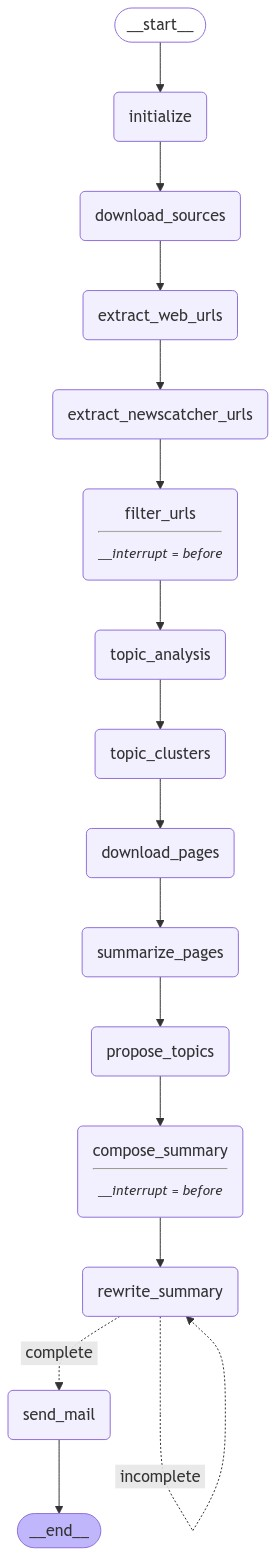

In [47]:
# Image(lg_agent.graph.get_graph().draw_png())
Image(lg_agent.app.get_graph().draw_mermaid_png())


In [ ]:
do_download = True
before_date = None
# before_date="2024-07-22 10:00:00"


In [ ]:
# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}
# initial state
state = AgentState()
state["before_date"] = before_date
state["do_download"] = do_download
log(f"Starting with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")


In [ ]:
state = lg_agent.run(state, config)

In [ ]:
state.items()

In [ ]:
user_approval = input("Edit topics? (yes/no): ")


In [ ]:
if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in lg_agent.graph.stream(None, config, stream_mode="debug"):
        if step["type"] == "checkpoint":
            display(f'Step {step["step"]}')
else:
    print("Operation cancelled by user.")


In [ ]:
# get last state
last_state = lg_agent.graph.get_state(config)
pd.DataFrame(last_state.values['AIdf'])


In [ ]:
# update state as node
# lg_agent.graph.update_state(config, {"foo": 2, "bar": ["b"]}, as_node="revise_summary")


In [ ]:
# resume from error starting at a node
# result = lg_agent.graph.invoke(None, {'configurable': {'thread_id': 'newsbot-thread-5'}, "next": "topic_analysis"})

In [ ]:
# Import packages
# Default packages
import time
import csv
import os
import json


# Preinstalled packages
import requests
import pandas


In [ ]:
# URL of our News API
base_url = 'https://api.newscatcherapi.com/v2/search'

